In [1]:
from urllib.parse import urljoin
import datetime as datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import csv
from csv import reader
import numpy as np 
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV,RidgeCV,ElasticNetCV
from sklearn import metrics 
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd 
import math

In [2]:
def df_info(df):
    len_df = len(df)
    sample = []
    p_nan = []
    corrSP = []
    all_uniq = []
    feature = df.columns[3]
    for i in df.columns:
        head_col = str(list(df[i].head(5)))
        sample.append(head_col)
        all_nan = df[i].isna().sum() #.sum()
        if all_nan == len_df:
            p_nan.append(100)
        elif all_nan == 0:
            p_nan.append(0)
        else:
            p_nan.append(round(all_nan / len_df * 100, 2))
         
        if df[i].nunique() <= 5:
            all_uniq.append(str(list(set(df[i]))))
        else:
            all_uniq.append("Several")
 
    if "Imbalance_price" in df:
        corrSP = df.corr(method='pearson').Imbalance_price
    else:
        corrSP = np.nan

    list_of_numerics = df.select_dtypes(include = ['float','int']).columns
    outl = df.apply(lambda x: sum(
                     (x<(x.quantile(0.05) - 1.5 * (x.quantile(0.95)-x.quantile(0.05)))) |
                     (x>(x.quantile(0.95) + 1.5 * (x.quantile(0.95)-x.quantile(0.05))))
                     if x.name in list_of_numerics else '') )

    df_resume = pd.DataFrame({ 
                        'type': list(df.dtypes),
                        'Sample': sample,
                        "% of NaN": p_nan,
                        "Corr_with_y": corrSP,
                        'Duplicates' : (df.duplicated()).sum(),
                        'Amount Uniques' : df.nunique(),
                        'Uniques' : all_uniq,                        
                        'Outliers' : outl } , index = df.columns)
    
    return df_resume

pd.set_option('max_rows', None)


In [3]:
def make_dt_index(df, timestamp_col, dt_offset=None):
    df.index = pd.to_datetime(
        df.loc[:, timestamp_col], format='%Y-%m-%dT%H:%M:%S.%f'
    )

    if dt_offset:
        df.index = df.index + dt_offset

    df.drop(timestamp_col, axis=1, inplace=True)

    df.sort_index(inplace=True)

    return df


def check_duplicate_index(df, verbose=True):
    """ checks for duplicates in the index of a dataframe """
    dupes = df[df.index.duplicated()]
    num = dupes.shape[0]
    print('{} index duplicates'.format(num))

    if verbose == True:
        print('duplicates are:')
        print(dupes.head(3))

    return df[df.index.duplicated(keep=False)]


def drop_duplicate_index(df):
    return df[~df.index.duplicated(keep='first')]


def check_duplicate_rows(df, verbose=True):
    duplicated_bools = df.duplicated()
    num = np.sum(duplicated_bools)
    print('{} row duplicates'.format(num))

    if verbose:
        df[duplicated_bools].head(3)

    return df[df.duplicated(keep=False)]


def check_nans(df, verbose=True):
    """ checks for NANs in a dataframe """
    nans = df[df.isnull().any(axis=1)]
    num = nans.shape[0]

    print('{} nan rows'.format(num))
    if verbose:
        print('nan values are:')
        print(nans.head())

    return nans


def check_index_length(df, freq, verbose=True):
    """ compare a DatetimeIndex with the expected length """
    ideal = pd.DatetimeIndex(start=df.index[0],
                             end=df.index[-1],
                             freq=freq)

    ideal_len = ideal.shape[0]
    actual_len = df.shape[0]
    num_missing = ideal_len - actual_len
    print('ideal index len {} actual {} missing {}'.format(
        ideal_len, actual_len, num_missing))

    if ideal.shape[0] != df.shape[0]:
        missing = set(df.index).symmetric_difference(set(ideal))

        if verbose:
            print('missing are:')
            print(missing)

        return missing, ideal

    else:
        return None, df.index


def make_df_fill_dt_index(df, freq, method='ffill'):

    missing, ideal = check_index_length(df, freq)

    ideal_idx_df = pd.DataFrame(index=ideal)

    df = pd.concat([ideal_idx_df, df], axis=1)

    return df.fillna(method=method)


def check_dataframe(df, freq, verbose=False):
    """ wraps together all the checks """
    duplicate_index = check_duplicate_index(df, verbose)

    duplicate_rows = check_duplicate_rows(df, verbose)

    nans = check_nans(df, verbose)

    missing_index, ideal_index = check_index_length(df, freq, verbose)

    return {
        'duplicate_index': duplicate_index,
        'duplicate_rows': duplicate_rows,
        'nans': nans,
        'missing_index': missing_index,
        'ideal_index': ideal_index
    }
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

In [4]:
all_data = pd.read_csv('All_data.csv')


In [5]:
all_data.head()
columns_data = all_data.columns

In [6]:
all_data[columns_data[0]] = pd.to_datetime(all_data[columns_data[0]])
all_data.set_index(columns_data[0], drop=True, inplace=True)
all_data.index.name = None

In [9]:
all_data.head()


,Total Activated Balancing Energy UP (MWh),Total Activated Balancing Energy Down (MWh),Total Activated Balancing Energy (MWh),Imbalance Price (€/MWh),mFRR Price UP (€/MWh),mFRR Price Down (€/MWh),Uplift Account 1 (€/MWh),Uplift Account 2 (€/MWh),Uplift Account 3 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,Day_ahead_price,Day_ahead_Balancing_diff,Diff_direction,Date
2021-08-15 00:00:00,64.696300,162.704473,-98.008173,38.036567,141.3900,40.7625,2.738548,0.662670,5.481142,1820.0,5515.5,50.0,914.0,95.16,57.123433,1,2021-08-15 00:00:00
2021-08-15 01:00:00,47.823965,117.162650,-69.338685,23.803718,86.9275,26.3325,2.375837,1.098814,2.754350,1930.0,5299.0,50.0,939.0,103.16,79.356282,1,2021-08-15 01:00:00
2021-08-15 02:00:00,37.976323,56.592600,-18.616277,25.178707,27.8250,0.0100,2.143069,1.201918,3.213499,2000.0,5127.5,50.0,949.0,91.91,66.731293,1,2021-08-15 02:00:00
2021-08-15 03:00:00,36.129990,105.814593,-69.684602,0.010000,28.5925,0.0100,2.043232,1.117085,3.079745,2035.0,5038.0,63.0,939.0,77.00,76.990000,1,2021-08-15 03:00:00
2021-08-15 04:00:00,34.597000,90.711290,-56.114290,17.827500,28.5925,17.8275,2.227400,1.156230,2.383576,2055.0,4951.5,76.0,1079.0,83.80,65.972500,1,2021-08-15 04:00:00


In [255]:
all_data[columns_data[15]].loc[all_data[columns_data[15]]<= -600 ] = -600

In [257]:
x = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[7],columns_data[8],columns_data[9],columns_data[14],columns_data[15],columns_data[16],columns_data[17]], axis=1)
x.head()



,RES,Load,Mandatory Hydro,Total FRR
2021-08-15 00:00:00,1820.0,5515.5,50.0,914.0
2021-08-15 01:00:00,1930.0,5299.0,50.0,939.0
2021-08-15 02:00:00,2000.0,5127.5,50.0,949.0
2021-08-15 03:00:00,2035.0,5038.0,63.0,939.0
2021-08-15 04:00:00,2055.0,4951.5,76.0,1079.0


In [258]:
y = all_data['Day_ahead_Balancing_diff']
min(y)

-600.0

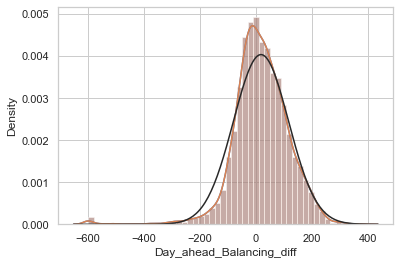

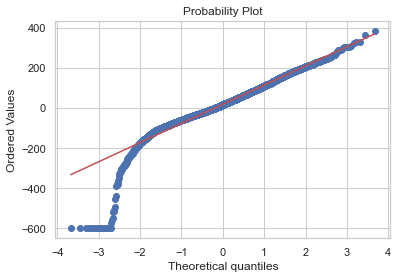

In [259]:
from scipy.stats import norm
from scipy import stats
sns.distplot(y);
sns.distplot(y, fit=norm)
fig = plt.figure()
res = stats.probplot(y, plot=plt)



In [325]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score


train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.25)

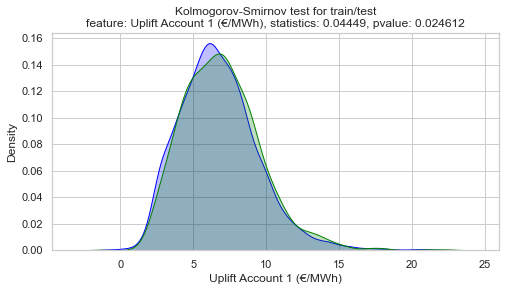

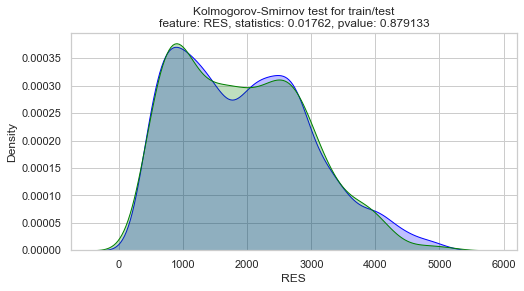

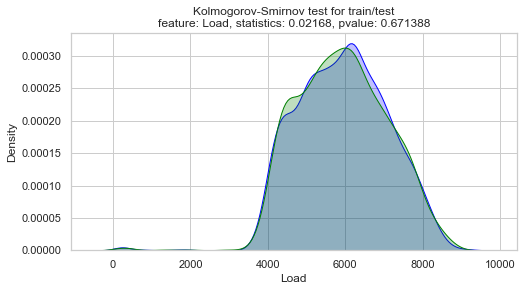

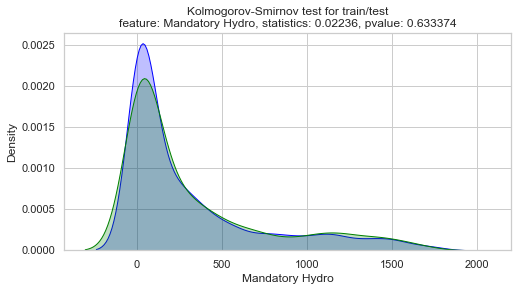

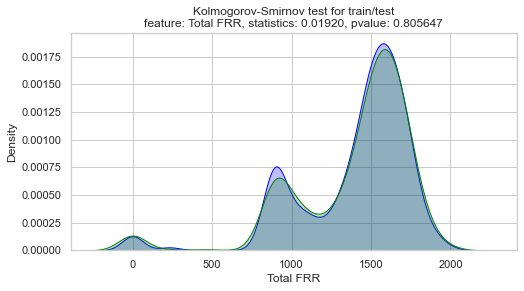

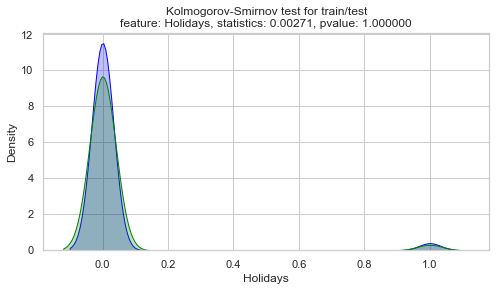

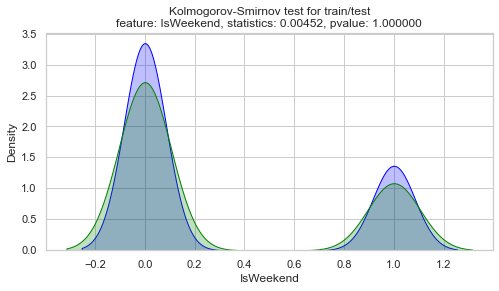

In [326]:
from scipy.stats import ks_2samp
hypothesisnotrejected = []
hypothesisrejected = []

for col in train_X.columns:
    statistic, pvalue = ks_2samp(train_X[col], test_X[col])
    if pvalue>=statistic:
        hypothesisnotrejected.append(col)
    if pvalue<statistic:
        hypothesisrejected.append(col)
        
    plt.figure(figsize=(8,4))
    plt.title("Kolmogorov-Smirnov test for train/test\n"
              "feature: {}, statistics: {:.5f}, pvalue: {:5f}".format(col, statistic, pvalue))
    sns.kdeplot(train_X[col], color='blue', shade=True, label='Train')
    sns.kdeplot(test_X[col], color='green', shade=True, label='Test')

    plt.show()

$\textbf{I want to test the distribution between Test and Train Dataset after the Split}$

In [327]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = ["Uplift Account 1 (€/MWh)","RES","Load","Mandatory Hydro","Total FRR"]

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X)

$\textbf{CatBoost Regression}$

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMS:  82.22403912842528


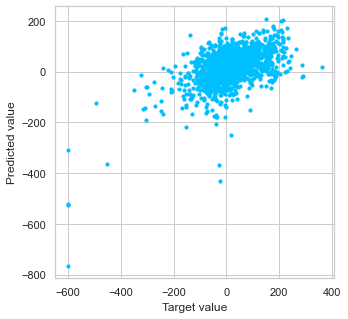

In [328]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

train_pool = Pool(train_X, 
                  train_y)
test_pool = Pool(test_X) 


####{'colsample_bylevel': 4, 'learning_rate': 5, 'max_depth': 4}, 

#### Grid Search 
# {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}
modelCB = CatBoostRegressor(iterations=8000,
                           depth=4,
                           learning_rate=0.08,
                           loss_function='RMSE',
                           silent=True)

modelCB.fit(train_pool,plot=True)

preds1 = modelCB.predict(test_pool)

preds_train=modelCB.predict(train_pool)
# evaluate predictions
rms1 = mean_squared_error(test_y, preds1, squared=False) #np.sqrt(np.mean((preds1 - test_y) ** 2))
print("RMS: ", rms1)
#print(preds1)



plt.figure(figsize=(5,5))
plt.scatter(test_y, preds1, s=10, color="deepskyblue")
plt.xlabel("Target value")
plt.ylabel("Predicted value")
print(train_pool)

In [329]:
val_preds = modelCB.predict(test_X)
MAPE=np.mean(np.abs((test_y - val_preds) / test_y)) * 100
# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(val_preds, test_y))
print("Accuracy is : ",  100-MAPE)

Accuracy is :  -264.8450956180183


In [330]:
def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None, 
                  title="Residual Plot", figsize=(9,6)):
    """ Residual plot to evaluate performance of our simple linear regressor """
    plt.figure(figsize=figsize)
    plt.scatter(train_preds, train_preds - train_labels, c='blue', alpha=0.1,
                marker='o', edgecolors='white', label='Training')
    
    if test_labels is not None:
        plt.scatter(test_preds, test_preds - test_labels, c='red', alpha=0.1,
                    marker='^', edgecolors='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    
    if test_labels is not None:
        plt.legend(loc='best')
    plt.title(title)
    plt.show()
    return

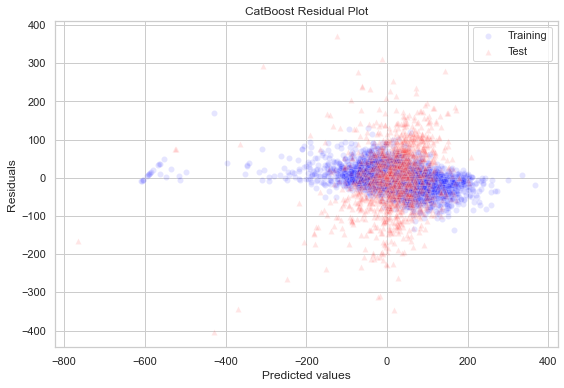

In [331]:
train_preds = modelCB.predict(train_X)

residual_plot(train_y, train_preds, 
              test_y, val_preds, 
              title="CatBoost Residual Plot")

Evaluation on test data
RMSE: 82.22
R2: 0.27
Adjusted R2: 0.26


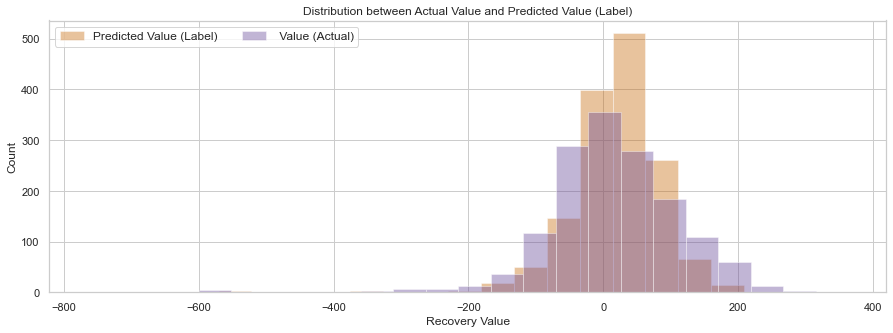

In [332]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_CATBOOST = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_CATBOOST["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_CATBOOST["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")
plt.legend(( 'Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



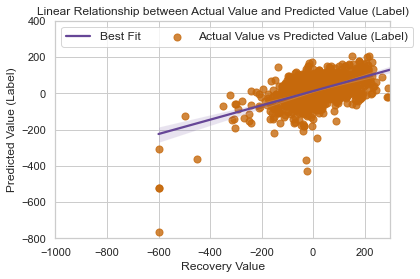

In [333]:
# We can plot the Predicted Value (Label) and Actual Value over the entire dataset. 
sns.regplot(x="Real", y="Prediction", data=output_data_CATBOOST, lowess=False, scatter_kws ={'s':50}, line_kws={"color": "#664697"}, color="#c6690c")
plt.title("Linear Relationship between Actual Value and Predicted Value (Label)")
plt.ylabel("Predicted Value (Label)")
plt.xlabel("Recovery Value")
plt.xlim([-1000, 300])
plt.ylim([-800,400])
plt.legend(('Best Fit', 'Actual Value vs Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)

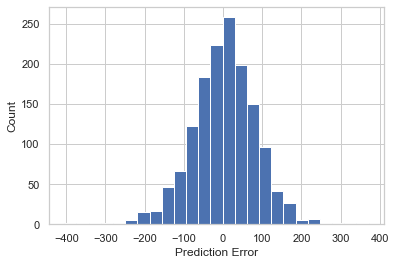

In [334]:
error = preds1 - test_y
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [335]:
output_data_CATBOOST.head(50)
output_data_CATBOOST["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_CATBOOST["Prediction"]]
output_data_CATBOOST["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_CATBOOST["Real"]]

In [336]:
output_data_CATBOOST.head(50)
comparison_column = np.where(output_data_CATBOOST["Prediction_sign"] == output_data_CATBOOST["Real_sign"], True, False)

In [337]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  1013


In [338]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6863143631436315


In [339]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from catboost import cv
def cross_val(model):
    pred = cross_val_score(model, x, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square
#### Cat Boost
print('Test set evaluation:\n_____________________________________')
print_evaluate(test_y, val_preds)
print('Train set evaluation:\n_____________________________________')
print_evaluate(train_y, train_preds)


#### Light GBM 
results_bsic_Catboost = pd.DataFrame(data=[["Cat Boost", *evaluate(train_y, train_preds) ,cross_val(CatBoostRegressor())]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_bsic_Catboost




Test set evaluation:
_____________________________________
MAE: 62.579650775393965
MSE: 6760.792610592812
RMSE: 82.22403912842528
R2 Square 0.2661099682613616
__________________________________
Train set evaluation:
_____________________________________
MAE: 21.454357025353126
MSE: 818.4941255457655
RMSE: 28.609336335290365
R2 Square 0.9177088621299526
__________________________________
Learning rate set to 0.052543
0:	learn: 102.0583372	total: 7.46ms	remaining: 7.45s
1:	learn: 101.4685772	total: 11.6ms	remaining: 5.8s
2:	learn: 100.9235928	total: 16ms	remaining: 5.32s
3:	learn: 100.4894685	total: 21.3ms	remaining: 5.3s
4:	learn: 100.0764385	total: 26.8ms	remaining: 5.33s
5:	learn: 99.5953477	total: 31.5ms	remaining: 5.22s
6:	learn: 99.1386114	total: 36ms	remaining: 5.11s
7:	learn: 98.7414212	total: 40.4ms	remaining: 5.01s
8:	learn: 98.3916947	total: 44.2ms	remaining: 4.87s
9:	learn: 98.0428807	total: 48.1ms	remaining: 4.76s
10:	learn: 97.6865849	total: 51.9ms	remaining: 4.66s
11:	lear

149:	learn: 82.2147119	total: 635ms	remaining: 3.6s
150:	learn: 82.1630721	total: 639ms	remaining: 3.59s
151:	learn: 82.1228524	total: 643ms	remaining: 3.58s
152:	learn: 82.0777697	total: 646ms	remaining: 3.58s
153:	learn: 82.0465130	total: 650ms	remaining: 3.57s
154:	learn: 82.0202916	total: 653ms	remaining: 3.56s
155:	learn: 81.9826731	total: 663ms	remaining: 3.58s
156:	learn: 81.9311531	total: 671ms	remaining: 3.6s
157:	learn: 81.8645790	total: 680ms	remaining: 3.62s
158:	learn: 81.8084980	total: 683ms	remaining: 3.61s
159:	learn: 81.7763083	total: 687ms	remaining: 3.61s
160:	learn: 81.7386433	total: 691ms	remaining: 3.6s
161:	learn: 81.6421807	total: 695ms	remaining: 3.59s
162:	learn: 81.5963002	total: 698ms	remaining: 3.58s
163:	learn: 81.5434457	total: 702ms	remaining: 3.58s
164:	learn: 81.4675064	total: 705ms	remaining: 3.57s
165:	learn: 81.4053670	total: 709ms	remaining: 3.56s
166:	learn: 81.3520692	total: 712ms	remaining: 3.55s
167:	learn: 81.2962715	total: 718ms	remaining: 3.

305:	learn: 75.2826430	total: 1.28s	remaining: 2.89s
306:	learn: 75.2452448	total: 1.28s	remaining: 2.89s
307:	learn: 75.2091757	total: 1.28s	remaining: 2.89s
308:	learn: 75.1785219	total: 1.29s	remaining: 2.88s
309:	learn: 75.1450978	total: 1.29s	remaining: 2.88s
310:	learn: 75.1127835	total: 1.29s	remaining: 2.87s
311:	learn: 75.0839075	total: 1.3s	remaining: 2.87s
312:	learn: 75.0517454	total: 1.3s	remaining: 2.86s
313:	learn: 75.0068572	total: 1.31s	remaining: 2.86s
314:	learn: 74.9678767	total: 1.31s	remaining: 2.85s
315:	learn: 74.9336770	total: 1.31s	remaining: 2.85s
316:	learn: 74.9057873	total: 1.32s	remaining: 2.84s
317:	learn: 74.8496193	total: 1.32s	remaining: 2.84s
318:	learn: 74.8182272	total: 1.33s	remaining: 2.83s
319:	learn: 74.7935661	total: 1.33s	remaining: 2.83s
320:	learn: 74.7604756	total: 1.34s	remaining: 2.83s
321:	learn: 74.7222722	total: 1.34s	remaining: 2.82s
322:	learn: 74.6978813	total: 1.34s	remaining: 2.82s
323:	learn: 74.6665745	total: 1.35s	remaining: 2

469:	learn: 70.3351574	total: 1.94s	remaining: 2.19s
470:	learn: 70.3144423	total: 1.95s	remaining: 2.19s
471:	learn: 70.2736851	total: 1.95s	remaining: 2.18s
472:	learn: 70.2424749	total: 1.95s	remaining: 2.17s
473:	learn: 70.2246012	total: 1.96s	remaining: 2.17s
474:	learn: 70.2068367	total: 1.96s	remaining: 2.17s
475:	learn: 70.1794135	total: 1.97s	remaining: 2.16s
476:	learn: 70.1573873	total: 1.97s	remaining: 2.16s
477:	learn: 70.1348124	total: 1.97s	remaining: 2.15s
478:	learn: 70.1019410	total: 1.98s	remaining: 2.15s
479:	learn: 70.0645417	total: 1.98s	remaining: 2.15s
480:	learn: 70.0418777	total: 1.99s	remaining: 2.14s
481:	learn: 70.0046961	total: 1.99s	remaining: 2.14s
482:	learn: 69.9861087	total: 1.99s	remaining: 2.13s
483:	learn: 69.9541978	total: 2s	remaining: 2.13s
484:	learn: 69.9276200	total: 2s	remaining: 2.12s
485:	learn: 69.9107704	total: 2s	remaining: 2.12s
486:	learn: 69.8894835	total: 2.01s	remaining: 2.12s
487:	learn: 69.8572448	total: 2.01s	remaining: 2.11s
48

628:	learn: 66.6061808	total: 2.64s	remaining: 1.56s
629:	learn: 66.5863039	total: 2.65s	remaining: 1.55s
630:	learn: 66.5627830	total: 2.65s	remaining: 1.55s
631:	learn: 66.5509625	total: 2.65s	remaining: 1.54s
632:	learn: 66.5221442	total: 2.66s	remaining: 1.54s
633:	learn: 66.5161447	total: 2.66s	remaining: 1.54s
634:	learn: 66.4953555	total: 2.67s	remaining: 1.53s
635:	learn: 66.4588515	total: 2.67s	remaining: 1.53s
636:	learn: 66.4473818	total: 2.68s	remaining: 1.52s
637:	learn: 66.4238849	total: 2.68s	remaining: 1.52s
638:	learn: 66.4065128	total: 2.68s	remaining: 1.52s
639:	learn: 66.3538181	total: 2.69s	remaining: 1.51s
640:	learn: 66.3310871	total: 2.69s	remaining: 1.51s
641:	learn: 66.3082408	total: 2.69s	remaining: 1.5s
642:	learn: 66.2922973	total: 2.7s	remaining: 1.5s
643:	learn: 66.2686347	total: 2.7s	remaining: 1.49s
644:	learn: 66.2500858	total: 2.71s	remaining: 1.49s
645:	learn: 66.2339455	total: 2.71s	remaining: 1.49s
646:	learn: 66.2066628	total: 2.71s	remaining: 1.4

796:	learn: 63.2480072	total: 3.29s	remaining: 839ms
797:	learn: 63.2360017	total: 3.3s	remaining: 835ms
798:	learn: 63.2145641	total: 3.3s	remaining: 831ms
799:	learn: 63.1911653	total: 3.31s	remaining: 826ms
800:	learn: 63.1694552	total: 3.31s	remaining: 822ms
801:	learn: 63.1278194	total: 3.31s	remaining: 818ms
802:	learn: 63.1132059	total: 3.32s	remaining: 814ms
803:	learn: 63.0883643	total: 3.32s	remaining: 810ms
804:	learn: 63.0659922	total: 3.33s	remaining: 806ms
805:	learn: 63.0517783	total: 3.33s	remaining: 801ms
806:	learn: 63.0370681	total: 3.33s	remaining: 797ms
807:	learn: 63.0160691	total: 3.34s	remaining: 793ms
808:	learn: 63.0108947	total: 3.34s	remaining: 789ms
809:	learn: 62.9962781	total: 3.35s	remaining: 785ms
810:	learn: 62.9829839	total: 3.35s	remaining: 781ms
811:	learn: 62.9769666	total: 3.35s	remaining: 777ms
812:	learn: 62.9514947	total: 3.36s	remaining: 773ms
813:	learn: 62.9384449	total: 3.36s	remaining: 769ms
814:	learn: 62.9242232	total: 3.37s	remaining: 7

964:	learn: 60.3142528	total: 3.97s	remaining: 144ms
965:	learn: 60.3006826	total: 3.97s	remaining: 140ms
966:	learn: 60.2879230	total: 3.98s	remaining: 136ms
967:	learn: 60.2691123	total: 3.98s	remaining: 132ms
968:	learn: 60.2401917	total: 3.98s	remaining: 128ms
969:	learn: 60.2212097	total: 3.99s	remaining: 123ms
970:	learn: 60.2070857	total: 3.99s	remaining: 119ms
971:	learn: 60.1948567	total: 4s	remaining: 115ms
972:	learn: 60.1667174	total: 4s	remaining: 111ms
973:	learn: 60.1449800	total: 4s	remaining: 107ms
974:	learn: 60.1134323	total: 4.01s	remaining: 103ms
975:	learn: 60.0994312	total: 4.01s	remaining: 98.7ms
976:	learn: 60.0836203	total: 4.02s	remaining: 94.6ms
977:	learn: 60.0635654	total: 4.02s	remaining: 90.5ms
978:	learn: 60.0456163	total: 4.03s	remaining: 86.4ms
979:	learn: 60.0318662	total: 4.03s	remaining: 82.2ms
980:	learn: 60.0203134	total: 4.04s	remaining: 78.2ms
981:	learn: 60.0021425	total: 4.04s	remaining: 74ms
982:	learn: 59.9942295	total: 4.04s	remaining: 69.

125:	learn: 83.8047019	total: 493ms	remaining: 3.42s
126:	learn: 83.7652583	total: 497ms	remaining: 3.42s
127:	learn: 83.7106737	total: 502ms	remaining: 3.42s
128:	learn: 83.6146324	total: 505ms	remaining: 3.41s
129:	learn: 83.5573174	total: 510ms	remaining: 3.41s
130:	learn: 83.5088017	total: 514ms	remaining: 3.41s
131:	learn: 83.4292918	total: 517ms	remaining: 3.4s
132:	learn: 83.3763099	total: 522ms	remaining: 3.4s
133:	learn: 83.2991171	total: 526ms	remaining: 3.4s
134:	learn: 83.2257658	total: 530ms	remaining: 3.4s
135:	learn: 83.1793881	total: 534ms	remaining: 3.39s
136:	learn: 83.1345992	total: 538ms	remaining: 3.39s
137:	learn: 83.0759644	total: 542ms	remaining: 3.39s
138:	learn: 83.0186868	total: 546ms	remaining: 3.38s
139:	learn: 82.9693705	total: 550ms	remaining: 3.38s
140:	learn: 82.9007274	total: 554ms	remaining: 3.37s
141:	learn: 82.8451056	total: 558ms	remaining: 3.37s
142:	learn: 82.7847674	total: 562ms	remaining: 3.37s
143:	learn: 82.7208261	total: 567ms	remaining: 3.3

289:	learn: 76.0074804	total: 1.17s	remaining: 2.86s
290:	learn: 75.9589914	total: 1.17s	remaining: 2.86s
291:	learn: 75.9220375	total: 1.18s	remaining: 2.86s
292:	learn: 75.8959519	total: 1.18s	remaining: 2.85s
293:	learn: 75.8697178	total: 1.19s	remaining: 2.85s
294:	learn: 75.8234891	total: 1.19s	remaining: 2.85s
295:	learn: 75.7877996	total: 1.19s	remaining: 2.84s
296:	learn: 75.7499982	total: 1.2s	remaining: 2.84s
297:	learn: 75.7086661	total: 1.2s	remaining: 2.84s
298:	learn: 75.6808866	total: 1.21s	remaining: 2.83s
299:	learn: 75.6540445	total: 1.21s	remaining: 2.83s
300:	learn: 75.6336643	total: 1.22s	remaining: 2.82s
301:	learn: 75.5989134	total: 1.22s	remaining: 2.82s
302:	learn: 75.5578664	total: 1.23s	remaining: 2.82s
303:	learn: 75.5266283	total: 1.23s	remaining: 2.81s
304:	learn: 75.4938610	total: 1.23s	remaining: 2.81s
305:	learn: 75.4478723	total: 1.24s	remaining: 2.8s
306:	learn: 75.4187132	total: 1.24s	remaining: 2.8s
307:	learn: 75.3947335	total: 1.25s	remaining: 2.8

464:	learn: 70.5117674	total: 1.85s	remaining: 2.13s
465:	learn: 70.4827767	total: 1.86s	remaining: 2.13s
466:	learn: 70.4642003	total: 1.86s	remaining: 2.13s
467:	learn: 70.4176253	total: 1.87s	remaining: 2.12s
468:	learn: 70.4036413	total: 1.87s	remaining: 2.12s
469:	learn: 70.3769354	total: 1.87s	remaining: 2.11s
470:	learn: 70.3424754	total: 1.88s	remaining: 2.11s
471:	learn: 70.3261553	total: 1.88s	remaining: 2.1s
472:	learn: 70.3035237	total: 1.89s	remaining: 2.1s
473:	learn: 70.2778472	total: 1.89s	remaining: 2.1s
474:	learn: 70.2493781	total: 1.89s	remaining: 2.09s
475:	learn: 70.2143765	total: 1.9s	remaining: 2.09s
476:	learn: 70.1933908	total: 1.9s	remaining: 2.08s
477:	learn: 70.1733297	total: 1.91s	remaining: 2.08s
478:	learn: 70.1497015	total: 1.91s	remaining: 2.08s
479:	learn: 70.1266085	total: 1.92s	remaining: 2.07s
480:	learn: 70.1072796	total: 1.92s	remaining: 2.07s
481:	learn: 70.0859472	total: 1.92s	remaining: 2.07s
482:	learn: 70.0600447	total: 1.93s	remaining: 2.06

632:	learn: 66.4294011	total: 2.53s	remaining: 1.47s
633:	learn: 66.4103011	total: 2.53s	remaining: 1.46s
634:	learn: 66.3955459	total: 2.54s	remaining: 1.46s
635:	learn: 66.3602966	total: 2.54s	remaining: 1.45s
636:	learn: 66.3347363	total: 2.54s	remaining: 1.45s
637:	learn: 66.3075257	total: 2.55s	remaining: 1.45s
638:	learn: 66.2786376	total: 2.55s	remaining: 1.44s
639:	learn: 66.2614862	total: 2.56s	remaining: 1.44s
640:	learn: 66.2285897	total: 2.56s	remaining: 1.44s
641:	learn: 66.2147393	total: 2.57s	remaining: 1.43s
642:	learn: 66.1930205	total: 2.57s	remaining: 1.43s
643:	learn: 66.1769186	total: 2.57s	remaining: 1.42s
644:	learn: 66.1556011	total: 2.58s	remaining: 1.42s
645:	learn: 66.1351272	total: 2.58s	remaining: 1.42s
646:	learn: 66.1094890	total: 2.59s	remaining: 1.41s
647:	learn: 66.0852562	total: 2.59s	remaining: 1.41s
648:	learn: 66.0659082	total: 2.6s	remaining: 1.4s
649:	learn: 66.0516905	total: 2.6s	remaining: 1.4s
650:	learn: 66.0249845	total: 2.6s	remaining: 1.4s

804:	learn: 63.0806740	total: 3.21s	remaining: 777ms
805:	learn: 63.0549926	total: 3.21s	remaining: 774ms
806:	learn: 63.0372615	total: 3.22s	remaining: 770ms
807:	learn: 63.0106847	total: 3.22s	remaining: 766ms
808:	learn: 63.0017334	total: 3.23s	remaining: 762ms
809:	learn: 62.9855753	total: 3.23s	remaining: 758ms
810:	learn: 62.9638044	total: 3.24s	remaining: 754ms
811:	learn: 62.9572612	total: 3.24s	remaining: 751ms
812:	learn: 62.9367150	total: 3.25s	remaining: 747ms
813:	learn: 62.9042797	total: 3.25s	remaining: 743ms
814:	learn: 62.8946823	total: 3.25s	remaining: 739ms
815:	learn: 62.8770764	total: 3.26s	remaining: 734ms
816:	learn: 62.8724676	total: 3.26s	remaining: 730ms
817:	learn: 62.8573781	total: 3.26s	remaining: 726ms
818:	learn: 62.8258034	total: 3.27s	remaining: 722ms
819:	learn: 62.8088165	total: 3.27s	remaining: 718ms
820:	learn: 62.7956971	total: 3.27s	remaining: 714ms
821:	learn: 62.7761910	total: 3.28s	remaining: 710ms
822:	learn: 62.7414527	total: 3.28s	remaining:

967:	learn: 60.3915100	total: 3.87s	remaining: 128ms
968:	learn: 60.3836647	total: 3.88s	remaining: 124ms
969:	learn: 60.3702352	total: 3.88s	remaining: 120ms
970:	learn: 60.3484671	total: 3.89s	remaining: 116ms
971:	learn: 60.3394854	total: 3.89s	remaining: 112ms
972:	learn: 60.3288504	total: 3.89s	remaining: 108ms
973:	learn: 60.3070071	total: 3.9s	remaining: 104ms
974:	learn: 60.2741332	total: 3.9s	remaining: 100ms
975:	learn: 60.2547660	total: 3.91s	remaining: 96.1ms
976:	learn: 60.2368451	total: 3.91s	remaining: 92ms
977:	learn: 60.2223207	total: 3.91s	remaining: 88ms
978:	learn: 60.2126768	total: 3.92s	remaining: 84ms
979:	learn: 60.1879721	total: 3.92s	remaining: 80ms
980:	learn: 60.1817120	total: 3.93s	remaining: 76.1ms
981:	learn: 60.1720420	total: 3.93s	remaining: 72.1ms
982:	learn: 60.1451058	total: 3.93s	remaining: 68ms
983:	learn: 60.1200590	total: 3.94s	remaining: 64.1ms
984:	learn: 60.1020845	total: 3.94s	remaining: 60ms
985:	learn: 60.0846395	total: 3.95s	remaining: 56m

127:	learn: 80.8211294	total: 503ms	remaining: 3.42s
128:	learn: 80.7445918	total: 506ms	remaining: 3.42s
129:	learn: 80.6801759	total: 510ms	remaining: 3.41s
130:	learn: 80.6435695	total: 513ms	remaining: 3.4s
131:	learn: 80.5701642	total: 517ms	remaining: 3.4s
132:	learn: 80.5182767	total: 520ms	remaining: 3.39s
133:	learn: 80.4434994	total: 524ms	remaining: 3.39s
134:	learn: 80.3864632	total: 529ms	remaining: 3.39s
135:	learn: 80.3353638	total: 532ms	remaining: 3.38s
136:	learn: 80.2884728	total: 536ms	remaining: 3.38s
137:	learn: 80.2051181	total: 543ms	remaining: 3.39s
138:	learn: 80.1705738	total: 553ms	remaining: 3.43s
139:	learn: 80.0936816	total: 559ms	remaining: 3.43s
140:	learn: 80.0294061	total: 563ms	remaining: 3.43s
141:	learn: 79.9589830	total: 567ms	remaining: 3.42s
142:	learn: 79.8990172	total: 571ms	remaining: 3.42s
143:	learn: 79.8542825	total: 575ms	remaining: 3.42s
144:	learn: 79.8046226	total: 579ms	remaining: 3.41s
145:	learn: 79.7417524	total: 583ms	remaining: 3

303:	learn: 72.7530410	total: 1.35s	remaining: 3.09s
304:	learn: 72.7287182	total: 1.35s	remaining: 3.08s
305:	learn: 72.6974720	total: 1.36s	remaining: 3.08s
306:	learn: 72.6647589	total: 1.36s	remaining: 3.07s
307:	learn: 72.6306148	total: 1.36s	remaining: 3.06s
308:	learn: 72.5755768	total: 1.37s	remaining: 3.06s
309:	learn: 72.5377036	total: 1.37s	remaining: 3.05s
310:	learn: 72.5092522	total: 1.38s	remaining: 3.05s
311:	learn: 72.4774708	total: 1.38s	remaining: 3.04s
312:	learn: 72.4597148	total: 1.38s	remaining: 3.04s
313:	learn: 72.4116871	total: 1.39s	remaining: 3.03s
314:	learn: 72.3778280	total: 1.39s	remaining: 3.03s
315:	learn: 72.3402924	total: 1.4s	remaining: 3.02s
316:	learn: 72.3033906	total: 1.4s	remaining: 3.02s
317:	learn: 72.2741353	total: 1.4s	remaining: 3.01s
318:	learn: 72.2515490	total: 1.41s	remaining: 3s
319:	learn: 72.2088385	total: 1.41s	remaining: 3s
320:	learn: 72.1762982	total: 1.42s	remaining: 2.99s
321:	learn: 72.1603839	total: 1.42s	remaining: 2.99s
32

480:	learn: 67.5865155	total: 2.02s	remaining: 2.18s
481:	learn: 67.5772334	total: 2.03s	remaining: 2.18s
482:	learn: 67.5537550	total: 2.03s	remaining: 2.17s
483:	learn: 67.5321590	total: 2.04s	remaining: 2.17s
484:	learn: 67.4956073	total: 2.04s	remaining: 2.17s
485:	learn: 67.4501899	total: 2.04s	remaining: 2.16s
486:	learn: 67.4159077	total: 2.05s	remaining: 2.15s
487:	learn: 67.3867534	total: 2.05s	remaining: 2.15s
488:	learn: 67.3640724	total: 2.06s	remaining: 2.15s
489:	learn: 67.3422014	total: 2.06s	remaining: 2.14s
490:	learn: 67.3282708	total: 2.06s	remaining: 2.14s
491:	learn: 67.3018939	total: 2.07s	remaining: 2.13s
492:	learn: 67.2798231	total: 2.07s	remaining: 2.13s
493:	learn: 67.2696607	total: 2.07s	remaining: 2.12s
494:	learn: 67.2548208	total: 2.08s	remaining: 2.12s
495:	learn: 67.2303564	total: 2.08s	remaining: 2.12s
496:	learn: 67.2020246	total: 2.08s	remaining: 2.11s
497:	learn: 67.1675696	total: 2.09s	remaining: 2.11s
498:	learn: 67.1447678	total: 2.09s	remaining:

658:	learn: 63.6219570	total: 2.7s	remaining: 1.4s
659:	learn: 63.6036594	total: 2.71s	remaining: 1.39s
660:	learn: 63.5819310	total: 2.71s	remaining: 1.39s
661:	learn: 63.5637587	total: 2.71s	remaining: 1.38s
662:	learn: 63.5486856	total: 2.72s	remaining: 1.38s
663:	learn: 63.5154778	total: 2.72s	remaining: 1.38s
664:	learn: 63.5021674	total: 2.72s	remaining: 1.37s
665:	learn: 63.4924816	total: 2.73s	remaining: 1.37s
666:	learn: 63.4699126	total: 2.73s	remaining: 1.36s
667:	learn: 63.4498901	total: 2.73s	remaining: 1.36s
668:	learn: 63.4325910	total: 2.74s	remaining: 1.35s
669:	learn: 63.4202605	total: 2.74s	remaining: 1.35s
670:	learn: 63.4014201	total: 2.75s	remaining: 1.35s
671:	learn: 63.3839349	total: 2.75s	remaining: 1.34s
672:	learn: 63.3674774	total: 2.75s	remaining: 1.34s
673:	learn: 63.3495487	total: 2.76s	remaining: 1.33s
674:	learn: 63.3247944	total: 2.76s	remaining: 1.33s
675:	learn: 63.3144130	total: 2.77s	remaining: 1.32s
676:	learn: 63.2914655	total: 2.77s	remaining: 1

831:	learn: 60.3700433	total: 3.37s	remaining: 681ms
832:	learn: 60.3455509	total: 3.38s	remaining: 677ms
833:	learn: 60.3247248	total: 3.38s	remaining: 674ms
834:	learn: 60.3064251	total: 3.39s	remaining: 670ms
835:	learn: 60.2851887	total: 3.39s	remaining: 666ms
836:	learn: 60.2725851	total: 3.4s	remaining: 662ms
837:	learn: 60.2328872	total: 3.4s	remaining: 658ms
838:	learn: 60.2209243	total: 3.4s	remaining: 653ms
839:	learn: 60.1945406	total: 3.41s	remaining: 649ms
840:	learn: 60.1768076	total: 3.41s	remaining: 646ms
841:	learn: 60.1648308	total: 3.42s	remaining: 642ms
842:	learn: 60.1439300	total: 3.42s	remaining: 637ms
843:	learn: 60.1258919	total: 3.43s	remaining: 633ms
844:	learn: 60.1090334	total: 3.43s	remaining: 629ms
845:	learn: 60.0905126	total: 3.43s	remaining: 625ms
846:	learn: 60.0765494	total: 3.44s	remaining: 621ms
847:	learn: 60.0610871	total: 3.44s	remaining: 617ms
848:	learn: 60.0390903	total: 3.45s	remaining: 613ms
849:	learn: 60.0210470	total: 3.45s	remaining: 60

Learning rate set to 0.052543
0:	learn: 99.8282917	total: 4.3ms	remaining: 4.29s
1:	learn: 99.2631957	total: 8.05ms	remaining: 4.01s
2:	learn: 98.7552758	total: 13.3ms	remaining: 4.42s
3:	learn: 98.2952052	total: 16.7ms	remaining: 4.17s
4:	learn: 97.8929844	total: 20.4ms	remaining: 4.07s
5:	learn: 97.4872595	total: 24.4ms	remaining: 4.04s
6:	learn: 97.0113866	total: 28ms	remaining: 3.97s
7:	learn: 96.5905582	total: 32ms	remaining: 3.97s
8:	learn: 96.2570365	total: 35.9ms	remaining: 3.95s
9:	learn: 95.9307768	total: 40.1ms	remaining: 3.97s
10:	learn: 95.5938549	total: 43.8ms	remaining: 3.94s
11:	learn: 95.2360347	total: 47.4ms	remaining: 3.9s
12:	learn: 94.9341849	total: 50.9ms	remaining: 3.87s
13:	learn: 94.6746659	total: 56.5ms	remaining: 3.98s
14:	learn: 94.3631795	total: 59.9ms	remaining: 3.93s
15:	learn: 94.0735803	total: 63.7ms	remaining: 3.92s
16:	learn: 93.8166341	total: 67.8ms	remaining: 3.92s
17:	learn: 93.5644818	total: 73.5ms	remaining: 4.01s
18:	learn: 93.3376654	total: 77.

169:	learn: 79.5392833	total: 682ms	remaining: 3.33s
170:	learn: 79.5066107	total: 686ms	remaining: 3.33s
171:	learn: 79.4533998	total: 690ms	remaining: 3.32s
172:	learn: 79.4188517	total: 693ms	remaining: 3.31s
173:	learn: 79.3795542	total: 697ms	remaining: 3.31s
174:	learn: 79.3159585	total: 701ms	remaining: 3.31s
175:	learn: 79.2647391	total: 705ms	remaining: 3.3s
176:	learn: 79.2308589	total: 708ms	remaining: 3.29s
177:	learn: 79.1837864	total: 712ms	remaining: 3.29s
178:	learn: 79.1300927	total: 715ms	remaining: 3.28s
179:	learn: 79.0972066	total: 719ms	remaining: 3.28s
180:	learn: 79.0616358	total: 725ms	remaining: 3.28s
181:	learn: 79.0088341	total: 728ms	remaining: 3.27s
182:	learn: 78.9651727	total: 733ms	remaining: 3.27s
183:	learn: 78.9017575	total: 737ms	remaining: 3.27s
184:	learn: 78.8558451	total: 741ms	remaining: 3.26s
185:	learn: 78.8120368	total: 744ms	remaining: 3.26s
186:	learn: 78.7822134	total: 748ms	remaining: 3.25s
187:	learn: 78.7482186	total: 752ms	remaining: 

355:	learn: 72.1864457	total: 1.36s	remaining: 2.47s
356:	learn: 72.1575580	total: 1.37s	remaining: 2.46s
357:	learn: 72.1052146	total: 1.37s	remaining: 2.46s
358:	learn: 72.0834979	total: 1.37s	remaining: 2.45s
359:	learn: 72.0531855	total: 1.38s	remaining: 2.45s
360:	learn: 72.0315072	total: 1.38s	remaining: 2.45s
361:	learn: 72.0056126	total: 1.39s	remaining: 2.44s
362:	learn: 71.9837036	total: 1.39s	remaining: 2.44s
363:	learn: 71.9496996	total: 1.39s	remaining: 2.43s
364:	learn: 71.9311504	total: 1.4s	remaining: 2.43s
365:	learn: 71.9046488	total: 1.4s	remaining: 2.43s
366:	learn: 71.8775851	total: 1.4s	remaining: 2.42s
367:	learn: 71.8463127	total: 1.41s	remaining: 2.42s
368:	learn: 71.8184623	total: 1.41s	remaining: 2.41s
369:	learn: 71.8035745	total: 1.42s	remaining: 2.41s
370:	learn: 71.7777392	total: 1.42s	remaining: 2.41s
371:	learn: 71.7597203	total: 1.42s	remaining: 2.4s
372:	learn: 71.7381592	total: 1.43s	remaining: 2.4s
373:	learn: 71.7195882	total: 1.43s	remaining: 2.39

542:	learn: 67.0314718	total: 2.04s	remaining: 1.72s
543:	learn: 67.0036953	total: 2.05s	remaining: 1.72s
544:	learn: 66.9746072	total: 2.05s	remaining: 1.71s
545:	learn: 66.9534328	total: 2.06s	remaining: 1.71s
546:	learn: 66.9364103	total: 2.06s	remaining: 1.71s
547:	learn: 66.9231619	total: 2.07s	remaining: 1.7s
548:	learn: 66.9007850	total: 2.07s	remaining: 1.7s
549:	learn: 66.8751443	total: 2.08s	remaining: 1.7s
550:	learn: 66.8566233	total: 2.08s	remaining: 1.7s
551:	learn: 66.8291782	total: 2.08s	remaining: 1.69s
552:	learn: 66.8002111	total: 2.09s	remaining: 1.69s
553:	learn: 66.7718010	total: 2.09s	remaining: 1.69s
554:	learn: 66.7512661	total: 2.1s	remaining: 1.69s
555:	learn: 66.7319354	total: 2.11s	remaining: 1.68s
556:	learn: 66.7100827	total: 2.11s	remaining: 1.68s
557:	learn: 66.6948586	total: 2.12s	remaining: 1.68s
558:	learn: 66.6578326	total: 2.12s	remaining: 1.67s
559:	learn: 66.6245225	total: 2.13s	remaining: 1.67s
560:	learn: 66.6065626	total: 2.13s	remaining: 1.67

701:	learn: 63.6696478	total: 2.72s	remaining: 1.16s
702:	learn: 63.6471095	total: 2.73s	remaining: 1.15s
703:	learn: 63.6311636	total: 2.73s	remaining: 1.15s
704:	learn: 63.6034921	total: 2.74s	remaining: 1.15s
705:	learn: 63.5849298	total: 2.75s	remaining: 1.14s
706:	learn: 63.5761468	total: 2.75s	remaining: 1.14s
707:	learn: 63.5570579	total: 2.76s	remaining: 1.14s
708:	learn: 63.5502674	total: 2.76s	remaining: 1.13s
709:	learn: 63.5320159	total: 2.76s	remaining: 1.13s
710:	learn: 63.5101543	total: 2.77s	remaining: 1.13s
711:	learn: 63.4961864	total: 2.77s	remaining: 1.12s
712:	learn: 63.4831229	total: 2.78s	remaining: 1.12s
713:	learn: 63.4704946	total: 2.79s	remaining: 1.12s
714:	learn: 63.4514015	total: 2.79s	remaining: 1.11s
715:	learn: 63.4370007	total: 2.79s	remaining: 1.11s
716:	learn: 63.4215041	total: 2.8s	remaining: 1.1s
717:	learn: 63.3890144	total: 2.81s	remaining: 1.1s
718:	learn: 63.3726342	total: 2.81s	remaining: 1.1s
719:	learn: 63.3570583	total: 2.82s	remaining: 1.1

867:	learn: 60.6557902	total: 3.4s	remaining: 517ms
868:	learn: 60.6425708	total: 3.4s	remaining: 513ms
869:	learn: 60.6192923	total: 3.4s	remaining: 509ms
870:	learn: 60.6042810	total: 3.41s	remaining: 505ms
871:	learn: 60.5864144	total: 3.41s	remaining: 501ms
872:	learn: 60.5638535	total: 3.42s	remaining: 497ms
873:	learn: 60.5542149	total: 3.42s	remaining: 493ms
874:	learn: 60.5384377	total: 3.42s	remaining: 489ms
875:	learn: 60.5327201	total: 3.43s	remaining: 485ms
876:	learn: 60.5130917	total: 3.43s	remaining: 481ms
877:	learn: 60.4889103	total: 3.43s	remaining: 477ms
878:	learn: 60.4764563	total: 3.44s	remaining: 473ms
879:	learn: 60.4625915	total: 3.44s	remaining: 469ms
880:	learn: 60.4480949	total: 3.44s	remaining: 465ms
881:	learn: 60.4320758	total: 3.45s	remaining: 461ms
882:	learn: 60.4152835	total: 3.45s	remaining: 457ms
883:	learn: 60.4054624	total: 3.46s	remaining: 454ms
884:	learn: 60.3705602	total: 3.46s	remaining: 450ms
885:	learn: 60.3493057	total: 3.46s	remaining: 44

38:	learn: 86.5328509	total: 164ms	remaining: 4.03s
39:	learn: 86.4467651	total: 167ms	remaining: 4.01s
40:	learn: 86.3437891	total: 171ms	remaining: 4s
41:	learn: 86.1992054	total: 175ms	remaining: 3.98s
42:	learn: 86.0711853	total: 181ms	remaining: 4.03s
43:	learn: 85.9765528	total: 185ms	remaining: 4.01s
44:	learn: 85.8755070	total: 188ms	remaining: 3.99s
45:	learn: 85.7298915	total: 192ms	remaining: 3.98s
46:	learn: 85.5953556	total: 197ms	remaining: 4s
47:	learn: 85.5048748	total: 201ms	remaining: 3.98s
48:	learn: 85.3690425	total: 205ms	remaining: 3.97s
49:	learn: 85.2658579	total: 209ms	remaining: 3.97s
50:	learn: 85.1474743	total: 212ms	remaining: 3.95s
51:	learn: 85.0703822	total: 216ms	remaining: 3.94s
52:	learn: 84.9596904	total: 220ms	remaining: 3.94s
53:	learn: 84.8633861	total: 224ms	remaining: 3.93s
54:	learn: 84.7422928	total: 229ms	remaining: 3.93s
55:	learn: 84.6194113	total: 233ms	remaining: 3.92s
56:	learn: 84.5191620	total: 237ms	remaining: 3.91s
57:	learn: 84.3996

225:	learn: 74.7207970	total: 841ms	remaining: 2.88s
226:	learn: 74.6867609	total: 845ms	remaining: 2.88s
227:	learn: 74.6404312	total: 848ms	remaining: 2.87s
228:	learn: 74.6082163	total: 852ms	remaining: 2.87s
229:	learn: 74.5634009	total: 856ms	remaining: 2.87s
230:	learn: 74.5137165	total: 860ms	remaining: 2.86s
231:	learn: 74.4870296	total: 865ms	remaining: 2.86s
232:	learn: 74.4363024	total: 870ms	remaining: 2.86s
233:	learn: 74.4067383	total: 875ms	remaining: 2.86s
234:	learn: 74.3431877	total: 882ms	remaining: 2.87s
235:	learn: 74.2770949	total: 887ms	remaining: 2.87s
236:	learn: 74.2483259	total: 892ms	remaining: 2.87s
237:	learn: 74.2160305	total: 897ms	remaining: 2.87s
238:	learn: 74.1557738	total: 903ms	remaining: 2.87s
239:	learn: 74.1153814	total: 909ms	remaining: 2.88s
240:	learn: 74.0608447	total: 913ms	remaining: 2.88s
241:	learn: 74.0259262	total: 918ms	remaining: 2.88s
242:	learn: 73.9989614	total: 923ms	remaining: 2.88s
243:	learn: 73.9639782	total: 929ms	remaining:

387:	learn: 69.1642118	total: 1.52s	remaining: 2.39s
388:	learn: 69.1340261	total: 1.52s	remaining: 2.39s
389:	learn: 69.0964332	total: 1.52s	remaining: 2.38s
390:	learn: 69.0825637	total: 1.53s	remaining: 2.38s
391:	learn: 69.0509229	total: 1.53s	remaining: 2.37s
392:	learn: 69.0223231	total: 1.53s	remaining: 2.37s
393:	learn: 68.9806635	total: 1.54s	remaining: 2.37s
394:	learn: 68.9444204	total: 1.54s	remaining: 2.36s
395:	learn: 68.9248593	total: 1.54s	remaining: 2.36s
396:	learn: 68.8854443	total: 1.55s	remaining: 2.35s
397:	learn: 68.8685320	total: 1.55s	remaining: 2.35s
398:	learn: 68.8422016	total: 1.55s	remaining: 2.34s
399:	learn: 68.8155133	total: 1.56s	remaining: 2.34s
400:	learn: 68.7888928	total: 1.56s	remaining: 2.33s
401:	learn: 68.7375629	total: 1.57s	remaining: 2.33s
402:	learn: 68.7197984	total: 1.57s	remaining: 2.33s
403:	learn: 68.7043292	total: 1.58s	remaining: 2.33s
404:	learn: 68.6805955	total: 1.58s	remaining: 2.32s
405:	learn: 68.6440024	total: 1.58s	remaining:

561:	learn: 64.7480361	total: 2.19s	remaining: 1.71s
562:	learn: 64.7237924	total: 2.19s	remaining: 1.7s
563:	learn: 64.7029690	total: 2.2s	remaining: 1.7s
564:	learn: 64.6696739	total: 2.2s	remaining: 1.7s
565:	learn: 64.6488186	total: 2.21s	remaining: 1.69s
566:	learn: 64.6198010	total: 2.21s	remaining: 1.69s
567:	learn: 64.6080695	total: 2.21s	remaining: 1.68s
568:	learn: 64.5868965	total: 2.22s	remaining: 1.68s
569:	learn: 64.5712176	total: 2.22s	remaining: 1.68s
570:	learn: 64.5437139	total: 2.22s	remaining: 1.67s
571:	learn: 64.5206110	total: 2.23s	remaining: 1.67s
572:	learn: 64.4864335	total: 2.23s	remaining: 1.66s
573:	learn: 64.4691416	total: 2.24s	remaining: 1.66s
574:	learn: 64.4474784	total: 2.24s	remaining: 1.66s
575:	learn: 64.4269156	total: 2.24s	remaining: 1.65s
576:	learn: 64.4065632	total: 2.25s	remaining: 1.65s
577:	learn: 64.3927462	total: 2.25s	remaining: 1.65s
578:	learn: 64.3748923	total: 2.26s	remaining: 1.64s
579:	learn: 64.3602491	total: 2.26s	remaining: 1.64

750:	learn: 60.9500948	total: 2.87s	remaining: 951ms
751:	learn: 60.9255063	total: 2.87s	remaining: 947ms
752:	learn: 60.9109509	total: 2.88s	remaining: 943ms
753:	learn: 60.8960934	total: 2.88s	remaining: 940ms
754:	learn: 60.8869529	total: 2.88s	remaining: 936ms
755:	learn: 60.8583873	total: 2.89s	remaining: 932ms
756:	learn: 60.8277867	total: 2.89s	remaining: 928ms
757:	learn: 60.8136939	total: 2.89s	remaining: 924ms
758:	learn: 60.7969665	total: 2.9s	remaining: 920ms
759:	learn: 60.7703803	total: 2.9s	remaining: 916ms
760:	learn: 60.7561540	total: 2.9s	remaining: 913ms
761:	learn: 60.7397551	total: 2.91s	remaining: 909ms
762:	learn: 60.7202634	total: 2.91s	remaining: 905ms
763:	learn: 60.7060507	total: 2.92s	remaining: 901ms
764:	learn: 60.6790239	total: 2.92s	remaining: 897ms
765:	learn: 60.6631265	total: 2.93s	remaining: 894ms
766:	learn: 60.6462013	total: 2.93s	remaining: 890ms
767:	learn: 60.6320625	total: 2.93s	remaining: 886ms
768:	learn: 60.6108917	total: 2.94s	remaining: 88

934:	learn: 57.8298867	total: 3.55s	remaining: 247ms
935:	learn: 57.8158194	total: 3.55s	remaining: 243ms
936:	learn: 57.7972130	total: 3.55s	remaining: 239ms
937:	learn: 57.7807884	total: 3.56s	remaining: 235ms
938:	learn: 57.7640162	total: 3.56s	remaining: 231ms
939:	learn: 57.7576336	total: 3.57s	remaining: 228ms
940:	learn: 57.7354743	total: 3.57s	remaining: 224ms
941:	learn: 57.7243940	total: 3.58s	remaining: 220ms
942:	learn: 57.7030103	total: 3.58s	remaining: 216ms
943:	learn: 57.6876379	total: 3.58s	remaining: 213ms
944:	learn: 57.6722350	total: 3.59s	remaining: 209ms
945:	learn: 57.6530473	total: 3.59s	remaining: 205ms
946:	learn: 57.6372711	total: 3.6s	remaining: 201ms
947:	learn: 57.6201503	total: 3.6s	remaining: 198ms
948:	learn: 57.5980387	total: 3.61s	remaining: 194ms
949:	learn: 57.5697176	total: 3.61s	remaining: 190ms
950:	learn: 57.5538841	total: 3.61s	remaining: 186ms
951:	learn: 57.5400211	total: 3.62s	remaining: 182ms
952:	learn: 57.5198559	total: 3.62s	remaining: 1

107:	learn: 80.4083176	total: 386ms	remaining: 3.19s
108:	learn: 80.3320238	total: 390ms	remaining: 3.19s
109:	learn: 80.2839867	total: 393ms	remaining: 3.18s
110:	learn: 80.2547016	total: 397ms	remaining: 3.18s
111:	learn: 80.2071302	total: 401ms	remaining: 3.18s
112:	learn: 80.1664217	total: 405ms	remaining: 3.17s
113:	learn: 80.1174068	total: 408ms	remaining: 3.17s
114:	learn: 80.0631773	total: 412ms	remaining: 3.17s
115:	learn: 80.0097182	total: 416ms	remaining: 3.17s
116:	learn: 79.9458813	total: 419ms	remaining: 3.16s
117:	learn: 79.9077268	total: 423ms	remaining: 3.16s
118:	learn: 79.8639122	total: 427ms	remaining: 3.16s
119:	learn: 79.8179245	total: 431ms	remaining: 3.16s
120:	learn: 79.7448351	total: 435ms	remaining: 3.16s
121:	learn: 79.7086023	total: 439ms	remaining: 3.16s
122:	learn: 79.6495076	total: 443ms	remaining: 3.16s
123:	learn: 79.6122153	total: 447ms	remaining: 3.16s
124:	learn: 79.5916525	total: 450ms	remaining: 3.15s
125:	learn: 79.5423808	total: 454ms	remaining:

290:	learn: 72.9006447	total: 1.06s	remaining: 2.58s
291:	learn: 72.8641277	total: 1.06s	remaining: 2.58s
292:	learn: 72.8271067	total: 1.07s	remaining: 2.57s
293:	learn: 72.7950195	total: 1.07s	remaining: 2.57s
294:	learn: 72.7722632	total: 1.07s	remaining: 2.57s
295:	learn: 72.7494073	total: 1.08s	remaining: 2.56s
296:	learn: 72.7274082	total: 1.08s	remaining: 2.56s
297:	learn: 72.6976990	total: 1.08s	remaining: 2.56s
298:	learn: 72.6682613	total: 1.09s	remaining: 2.55s
299:	learn: 72.6328699	total: 1.09s	remaining: 2.55s
300:	learn: 72.6037767	total: 1.1s	remaining: 2.55s
301:	learn: 72.5579110	total: 1.1s	remaining: 2.54s
302:	learn: 72.5339587	total: 1.1s	remaining: 2.54s
303:	learn: 72.4873964	total: 1.11s	remaining: 2.54s
304:	learn: 72.4678260	total: 1.11s	remaining: 2.53s
305:	learn: 72.4167052	total: 1.11s	remaining: 2.53s
306:	learn: 72.4008364	total: 1.12s	remaining: 2.53s
307:	learn: 72.3682995	total: 1.12s	remaining: 2.52s
308:	learn: 72.3492835	total: 1.13s	remaining: 2.

483:	learn: 67.5743236	total: 1.75s	remaining: 1.86s
484:	learn: 67.5540118	total: 1.75s	remaining: 1.86s
485:	learn: 67.5142181	total: 1.75s	remaining: 1.86s
486:	learn: 67.4784431	total: 1.76s	remaining: 1.85s
487:	learn: 67.4620169	total: 1.76s	remaining: 1.85s
488:	learn: 67.4452454	total: 1.77s	remaining: 1.84s
489:	learn: 67.4239855	total: 1.77s	remaining: 1.84s
490:	learn: 67.4082289	total: 1.77s	remaining: 1.84s
491:	learn: 67.3842249	total: 1.78s	remaining: 1.83s
492:	learn: 67.3663025	total: 1.78s	remaining: 1.83s
493:	learn: 67.3390187	total: 1.78s	remaining: 1.83s
494:	learn: 67.3159554	total: 1.79s	remaining: 1.82s
495:	learn: 67.3022862	total: 1.79s	remaining: 1.82s
496:	learn: 67.2699098	total: 1.8s	remaining: 1.82s
497:	learn: 67.2548389	total: 1.8s	remaining: 1.81s
498:	learn: 67.2303535	total: 1.8s	remaining: 1.81s
499:	learn: 67.2103531	total: 1.81s	remaining: 1.81s
500:	learn: 67.1867470	total: 1.81s	remaining: 1.8s
501:	learn: 67.1675013	total: 1.82s	remaining: 1.8

667:	learn: 63.4299721	total: 2.42s	remaining: 1.2s
668:	learn: 63.4048457	total: 2.42s	remaining: 1.2s
669:	learn: 63.3833902	total: 2.43s	remaining: 1.2s
670:	learn: 63.3538707	total: 2.43s	remaining: 1.19s
671:	learn: 63.3312472	total: 2.44s	remaining: 1.19s
672:	learn: 63.2917180	total: 2.44s	remaining: 1.19s
673:	learn: 63.2774248	total: 2.44s	remaining: 1.18s
674:	learn: 63.2642045	total: 2.45s	remaining: 1.18s
675:	learn: 63.2475599	total: 2.45s	remaining: 1.17s
676:	learn: 63.2176523	total: 2.45s	remaining: 1.17s
677:	learn: 63.1986487	total: 2.46s	remaining: 1.17s
678:	learn: 63.1733745	total: 2.46s	remaining: 1.16s
679:	learn: 63.1519269	total: 2.47s	remaining: 1.16s
680:	learn: 63.1147218	total: 2.47s	remaining: 1.16s
681:	learn: 63.0825734	total: 2.48s	remaining: 1.15s
682:	learn: 63.0659253	total: 2.48s	remaining: 1.15s
683:	learn: 63.0370553	total: 2.48s	remaining: 1.15s
684:	learn: 63.0133451	total: 2.49s	remaining: 1.14s
685:	learn: 62.9965010	total: 2.49s	remaining: 1.

858:	learn: 59.8437693	total: 3.1s	remaining: 508ms
859:	learn: 59.8264738	total: 3.1s	remaining: 505ms
860:	learn: 59.8073174	total: 3.1s	remaining: 501ms
861:	learn: 59.8035838	total: 3.11s	remaining: 498ms
862:	learn: 59.7862283	total: 3.11s	remaining: 494ms
863:	learn: 59.7734292	total: 3.12s	remaining: 490ms
864:	learn: 59.7557724	total: 3.12s	remaining: 487ms
865:	learn: 59.7160847	total: 3.12s	remaining: 483ms
866:	learn: 59.7012100	total: 3.13s	remaining: 480ms
867:	learn: 59.6891098	total: 3.13s	remaining: 476ms
868:	learn: 59.6717600	total: 3.13s	remaining: 472ms
869:	learn: 59.6496723	total: 3.14s	remaining: 469ms
870:	learn: 59.6390001	total: 3.14s	remaining: 465ms
871:	learn: 59.6272546	total: 3.15s	remaining: 462ms
872:	learn: 59.6030419	total: 3.15s	remaining: 458ms
873:	learn: 59.5841082	total: 3.15s	remaining: 455ms
874:	learn: 59.5684813	total: 3.16s	remaining: 451ms
875:	learn: 59.5645766	total: 3.16s	remaining: 447ms
876:	learn: 59.5448636	total: 3.16s	remaining: 44

37:	learn: 87.9157320	total: 160ms	remaining: 4.05s
38:	learn: 87.8105683	total: 165ms	remaining: 4.07s
39:	learn: 87.6716672	total: 170ms	remaining: 4.08s
40:	learn: 87.5537066	total: 175ms	remaining: 4.1s
41:	learn: 87.3903354	total: 180ms	remaining: 4.11s
42:	learn: 87.2919927	total: 185ms	remaining: 4.12s
43:	learn: 87.1348029	total: 190ms	remaining: 4.13s
44:	learn: 87.0399343	total: 194ms	remaining: 4.12s
45:	learn: 86.9134081	total: 199ms	remaining: 4.12s
46:	learn: 86.8156288	total: 202ms	remaining: 4.1s
47:	learn: 86.7173374	total: 206ms	remaining: 4.09s
48:	learn: 86.6186730	total: 210ms	remaining: 4.08s
49:	learn: 86.4949556	total: 214ms	remaining: 4.06s
50:	learn: 86.3781891	total: 218ms	remaining: 4.06s
51:	learn: 86.2713499	total: 222ms	remaining: 4.04s
52:	learn: 86.1747351	total: 225ms	remaining: 4.03s
53:	learn: 86.0975529	total: 229ms	remaining: 4.01s
54:	learn: 86.0104858	total: 232ms	remaining: 3.99s
55:	learn: 85.9098326	total: 236ms	remaining: 3.98s
56:	learn: 85.

225:	learn: 75.9424998	total: 836ms	remaining: 2.86s
226:	learn: 75.9035293	total: 840ms	remaining: 2.86s
227:	learn: 75.8794907	total: 844ms	remaining: 2.86s
228:	learn: 75.8380287	total: 848ms	remaining: 2.85s
229:	learn: 75.8044536	total: 851ms	remaining: 2.85s
230:	learn: 75.7748520	total: 855ms	remaining: 2.85s
231:	learn: 75.7385861	total: 859ms	remaining: 2.84s
232:	learn: 75.6934630	total: 863ms	remaining: 2.84s
233:	learn: 75.6435775	total: 866ms	remaining: 2.83s
234:	learn: 75.6058164	total: 869ms	remaining: 2.83s
235:	learn: 75.5716048	total: 873ms	remaining: 2.83s
236:	learn: 75.5365274	total: 877ms	remaining: 2.82s
237:	learn: 75.5026762	total: 881ms	remaining: 2.82s
238:	learn: 75.4638729	total: 884ms	remaining: 2.81s
239:	learn: 75.4253565	total: 888ms	remaining: 2.81s
240:	learn: 75.3906597	total: 893ms	remaining: 2.81s
241:	learn: 75.3459868	total: 897ms	remaining: 2.81s
242:	learn: 75.3075333	total: 900ms	remaining: 2.8s
243:	learn: 75.2751855	total: 904ms	remaining: 

417:	learn: 69.8446797	total: 1.51s	remaining: 2.1s
418:	learn: 69.8029269	total: 1.51s	remaining: 2.1s
419:	learn: 69.7613525	total: 1.52s	remaining: 2.1s
420:	learn: 69.7277297	total: 1.52s	remaining: 2.09s
421:	learn: 69.6944460	total: 1.53s	remaining: 2.09s
422:	learn: 69.6701442	total: 1.53s	remaining: 2.09s
423:	learn: 69.6459656	total: 1.53s	remaining: 2.08s
424:	learn: 69.6200536	total: 1.54s	remaining: 2.08s
425:	learn: 69.5967574	total: 1.54s	remaining: 2.08s
426:	learn: 69.5678679	total: 1.55s	remaining: 2.08s
427:	learn: 69.5264027	total: 1.55s	remaining: 2.07s
428:	learn: 69.4931709	total: 1.55s	remaining: 2.07s
429:	learn: 69.4561639	total: 1.56s	remaining: 2.07s
430:	learn: 69.4392625	total: 1.56s	remaining: 2.06s
431:	learn: 69.4177203	total: 1.57s	remaining: 2.06s
432:	learn: 69.3809808	total: 1.57s	remaining: 2.06s
433:	learn: 69.3621670	total: 1.57s	remaining: 2.05s
434:	learn: 69.3465802	total: 1.58s	remaining: 2.05s
435:	learn: 69.3137138	total: 1.58s	remaining: 2.

606:	learn: 65.1560033	total: 2.19s	remaining: 1.42s
607:	learn: 65.1293463	total: 2.19s	remaining: 1.41s
608:	learn: 65.0990541	total: 2.19s	remaining: 1.41s
609:	learn: 65.0761773	total: 2.2s	remaining: 1.41s
610:	learn: 65.0551649	total: 2.2s	remaining: 1.4s
611:	learn: 65.0395843	total: 2.21s	remaining: 1.4s
612:	learn: 65.0112344	total: 2.21s	remaining: 1.4s
613:	learn: 64.9852642	total: 2.21s	remaining: 1.39s
614:	learn: 64.9658202	total: 2.22s	remaining: 1.39s
615:	learn: 64.9283092	total: 2.22s	remaining: 1.39s
616:	learn: 64.9182759	total: 2.23s	remaining: 1.38s
617:	learn: 64.8871359	total: 2.23s	remaining: 1.38s
618:	learn: 64.8572307	total: 2.24s	remaining: 1.38s
619:	learn: 64.8384417	total: 2.24s	remaining: 1.37s
620:	learn: 64.8189176	total: 2.25s	remaining: 1.37s
621:	learn: 64.7989504	total: 2.25s	remaining: 1.37s
622:	learn: 64.7766102	total: 2.25s	remaining: 1.36s
623:	learn: 64.7599515	total: 2.26s	remaining: 1.36s
624:	learn: 64.7408310	total: 2.26s	remaining: 1.36

784:	learn: 61.5245097	total: 2.87s	remaining: 785ms
785:	learn: 61.5046675	total: 2.87s	remaining: 782ms
786:	learn: 61.4934605	total: 2.88s	remaining: 778ms
787:	learn: 61.4830925	total: 2.88s	remaining: 775ms
788:	learn: 61.4665333	total: 2.88s	remaining: 771ms
789:	learn: 61.4517029	total: 2.89s	remaining: 767ms
790:	learn: 61.4389633	total: 2.89s	remaining: 764ms
791:	learn: 61.4229585	total: 2.89s	remaining: 760ms
792:	learn: 61.4032905	total: 2.9s	remaining: 756ms
793:	learn: 61.3918886	total: 2.9s	remaining: 753ms
794:	learn: 61.3784874	total: 2.9s	remaining: 749ms
795:	learn: 61.3659959	total: 2.91s	remaining: 746ms
796:	learn: 61.3484308	total: 2.91s	remaining: 742ms
797:	learn: 61.3357926	total: 2.92s	remaining: 738ms
798:	learn: 61.3103497	total: 2.92s	remaining: 735ms
799:	learn: 61.2940245	total: 2.93s	remaining: 732ms
800:	learn: 61.2793598	total: 2.93s	remaining: 728ms
801:	learn: 61.2676651	total: 2.93s	remaining: 724ms
802:	learn: 61.2553983	total: 2.94s	remaining: 72

968:	learn: 58.4117992	total: 3.54s	remaining: 113ms
969:	learn: 58.3987002	total: 3.55s	remaining: 110ms
970:	learn: 58.3823023	total: 3.55s	remaining: 106ms
971:	learn: 58.3635951	total: 3.55s	remaining: 102ms
972:	learn: 58.3552460	total: 3.56s	remaining: 98.8ms
973:	learn: 58.3439604	total: 3.56s	remaining: 95.1ms
974:	learn: 58.3267113	total: 3.57s	remaining: 91.5ms
975:	learn: 58.3162690	total: 3.57s	remaining: 87.8ms
976:	learn: 58.2969985	total: 3.58s	remaining: 84.2ms
977:	learn: 58.2873810	total: 3.58s	remaining: 80.5ms
978:	learn: 58.2652407	total: 3.58s	remaining: 76.9ms
979:	learn: 58.2461798	total: 3.59s	remaining: 73.2ms
980:	learn: 58.2309006	total: 3.59s	remaining: 69.6ms
981:	learn: 58.2088236	total: 3.6s	remaining: 65.9ms
982:	learn: 58.1787316	total: 3.6s	remaining: 62.3ms
983:	learn: 58.1631061	total: 3.6s	remaining: 58.6ms
984:	learn: 58.1315226	total: 3.61s	remaining: 54.9ms
985:	learn: 58.1184824	total: 3.61s	remaining: 51.3ms
986:	learn: 58.1019880	total: 3.62s

134:	learn: 80.7522426	total: 500ms	remaining: 3.21s
135:	learn: 80.7001458	total: 504ms	remaining: 3.2s
136:	learn: 80.6474443	total: 508ms	remaining: 3.2s
137:	learn: 80.5858692	total: 512ms	remaining: 3.19s
138:	learn: 80.5246388	total: 516ms	remaining: 3.19s
139:	learn: 80.4378336	total: 519ms	remaining: 3.19s
140:	learn: 80.3633746	total: 524ms	remaining: 3.19s
141:	learn: 80.3198458	total: 529ms	remaining: 3.2s
142:	learn: 80.2768685	total: 533ms	remaining: 3.19s
143:	learn: 80.2146397	total: 537ms	remaining: 3.19s
144:	learn: 80.1594363	total: 541ms	remaining: 3.19s
145:	learn: 80.1030592	total: 545ms	remaining: 3.19s
146:	learn: 80.0661492	total: 548ms	remaining: 3.18s
147:	learn: 79.9800407	total: 552ms	remaining: 3.18s
148:	learn: 79.9050807	total: 556ms	remaining: 3.17s
149:	learn: 79.8679581	total: 560ms	remaining: 3.17s
150:	learn: 79.8092491	total: 564ms	remaining: 3.17s
151:	learn: 79.7555428	total: 569ms	remaining: 3.18s
152:	learn: 79.7141276	total: 574ms	remaining: 3.

305:	learn: 73.0404342	total: 1.18s	remaining: 2.67s
306:	learn: 73.0155817	total: 1.18s	remaining: 2.66s
307:	learn: 72.9745734	total: 1.18s	remaining: 2.66s
308:	learn: 72.9188634	total: 1.19s	remaining: 2.65s
309:	learn: 72.8807835	total: 1.19s	remaining: 2.65s
310:	learn: 72.8522043	total: 1.2s	remaining: 2.65s
311:	learn: 72.8173549	total: 1.2s	remaining: 2.64s
312:	learn: 72.7870804	total: 1.2s	remaining: 2.64s
313:	learn: 72.7566427	total: 1.21s	remaining: 2.64s
314:	learn: 72.7249624	total: 1.21s	remaining: 2.63s
315:	learn: 72.6992532	total: 1.21s	remaining: 2.63s
316:	learn: 72.6670947	total: 1.22s	remaining: 2.62s
317:	learn: 72.6434880	total: 1.22s	remaining: 2.62s
318:	learn: 72.5932731	total: 1.23s	remaining: 2.62s
319:	learn: 72.5579662	total: 1.23s	remaining: 2.61s
320:	learn: 72.5181558	total: 1.23s	remaining: 2.61s
321:	learn: 72.4864974	total: 1.24s	remaining: 2.61s
322:	learn: 72.4546054	total: 1.24s	remaining: 2.6s
323:	learn: 72.4250407	total: 1.25s	remaining: 2.6

490:	learn: 67.6438159	total: 1.85s	remaining: 1.92s
491:	learn: 67.6152389	total: 1.86s	remaining: 1.92s
492:	learn: 67.5956131	total: 1.86s	remaining: 1.92s
493:	learn: 67.5634043	total: 1.87s	remaining: 1.91s
494:	learn: 67.5425587	total: 1.87s	remaining: 1.91s
495:	learn: 67.5120257	total: 1.88s	remaining: 1.91s
496:	learn: 67.4904243	total: 1.88s	remaining: 1.9s
497:	learn: 67.4648176	total: 1.88s	remaining: 1.9s
498:	learn: 67.4402692	total: 1.89s	remaining: 1.9s
499:	learn: 67.4179736	total: 1.89s	remaining: 1.89s
500:	learn: 67.3907523	total: 1.9s	remaining: 1.89s
501:	learn: 67.3741254	total: 1.9s	remaining: 1.88s
502:	learn: 67.3412572	total: 1.9s	remaining: 1.88s
503:	learn: 67.3177758	total: 1.91s	remaining: 1.88s
504:	learn: 67.2988376	total: 1.91s	remaining: 1.88s
505:	learn: 67.2669253	total: 1.92s	remaining: 1.87s
506:	learn: 67.2366821	total: 1.92s	remaining: 1.87s
507:	learn: 67.2184504	total: 1.93s	remaining: 1.86s
508:	learn: 67.1926669	total: 1.93s	remaining: 1.86s

660:	learn: 63.6925372	total: 2.53s	remaining: 1.3s
661:	learn: 63.6665510	total: 2.54s	remaining: 1.29s
662:	learn: 63.6553246	total: 2.54s	remaining: 1.29s
663:	learn: 63.6417768	total: 2.54s	remaining: 1.29s
664:	learn: 63.6169590	total: 2.55s	remaining: 1.28s
665:	learn: 63.5986579	total: 2.55s	remaining: 1.28s
666:	learn: 63.5560291	total: 2.55s	remaining: 1.27s
667:	learn: 63.5202161	total: 2.56s	remaining: 1.27s
668:	learn: 63.4939632	total: 2.56s	remaining: 1.27s
669:	learn: 63.4640393	total: 2.57s	remaining: 1.26s
670:	learn: 63.4450327	total: 2.57s	remaining: 1.26s
671:	learn: 63.4244909	total: 2.58s	remaining: 1.26s
672:	learn: 63.4088999	total: 2.58s	remaining: 1.25s
673:	learn: 63.3849626	total: 2.58s	remaining: 1.25s
674:	learn: 63.3715036	total: 2.59s	remaining: 1.25s
675:	learn: 63.3449887	total: 2.59s	remaining: 1.24s
676:	learn: 63.3238080	total: 2.6s	remaining: 1.24s
677:	learn: 63.3065316	total: 2.6s	remaining: 1.24s
678:	learn: 63.2877356	total: 2.6s	remaining: 1.2

845:	learn: 60.1549034	total: 3.2s	remaining: 583ms
846:	learn: 60.1383583	total: 3.21s	remaining: 580ms
847:	learn: 60.1188217	total: 3.21s	remaining: 576ms
848:	learn: 60.1038922	total: 3.21s	remaining: 572ms
849:	learn: 60.0880615	total: 3.22s	remaining: 568ms
850:	learn: 60.0641879	total: 3.22s	remaining: 564ms
851:	learn: 60.0574025	total: 3.23s	remaining: 561ms
852:	learn: 60.0370540	total: 3.23s	remaining: 557ms
853:	learn: 60.0187314	total: 3.24s	remaining: 553ms
854:	learn: 59.9990575	total: 3.24s	remaining: 549ms
855:	learn: 59.9873301	total: 3.24s	remaining: 546ms
856:	learn: 59.9679438	total: 3.25s	remaining: 542ms
857:	learn: 59.9547206	total: 3.25s	remaining: 538ms
858:	learn: 59.9309051	total: 3.25s	remaining: 534ms
859:	learn: 59.9207568	total: 3.26s	remaining: 531ms
860:	learn: 59.8912937	total: 3.26s	remaining: 527ms
861:	learn: 59.8775476	total: 3.27s	remaining: 523ms
862:	learn: 59.8552120	total: 3.27s	remaining: 519ms
863:	learn: 59.8459668	total: 3.27s	remaining: 

14:	learn: 90.8680670	total: 55.9ms	remaining: 3.67s
15:	learn: 90.5327826	total: 59.9ms	remaining: 3.68s
16:	learn: 90.2702319	total: 63.8ms	remaining: 3.69s
17:	learn: 89.9698768	total: 67.7ms	remaining: 3.69s
18:	learn: 89.7155651	total: 71.7ms	remaining: 3.7s
19:	learn: 89.4731199	total: 75.4ms	remaining: 3.69s
20:	learn: 89.2486103	total: 79.5ms	remaining: 3.71s
21:	learn: 88.9901208	total: 83.4ms	remaining: 3.71s
22:	learn: 88.7461134	total: 86.9ms	remaining: 3.69s
23:	learn: 88.5369636	total: 90.4ms	remaining: 3.67s
24:	learn: 88.3170867	total: 94.2ms	remaining: 3.67s
25:	learn: 88.1521204	total: 98.4ms	remaining: 3.69s
26:	learn: 87.9809846	total: 102ms	remaining: 3.67s
27:	learn: 87.7795589	total: 106ms	remaining: 3.67s
28:	learn: 87.5219277	total: 109ms	remaining: 3.66s
29:	learn: 87.3743180	total: 113ms	remaining: 3.67s
30:	learn: 87.1909842	total: 118ms	remaining: 3.7s
31:	learn: 87.0070855	total: 122ms	remaining: 3.69s
32:	learn: 86.8225847	total: 125ms	remaining: 3.67s
33

199:	learn: 75.4887025	total: 732ms	remaining: 2.93s
200:	learn: 75.4518229	total: 735ms	remaining: 2.92s
201:	learn: 75.4082041	total: 739ms	remaining: 2.92s
202:	learn: 75.3555699	total: 743ms	remaining: 2.92s
203:	learn: 75.2830736	total: 747ms	remaining: 2.91s
204:	learn: 75.2549768	total: 750ms	remaining: 2.91s
205:	learn: 75.2164200	total: 754ms	remaining: 2.9s
206:	learn: 75.1667953	total: 758ms	remaining: 2.9s
207:	learn: 75.1284500	total: 762ms	remaining: 2.9s
208:	learn: 75.0897394	total: 766ms	remaining: 2.9s
209:	learn: 75.0500843	total: 769ms	remaining: 2.89s
210:	learn: 75.0147870	total: 773ms	remaining: 2.89s
211:	learn: 74.9574673	total: 777ms	remaining: 2.89s
212:	learn: 74.9185018	total: 781ms	remaining: 2.89s
213:	learn: 74.8693272	total: 785ms	remaining: 2.88s
214:	learn: 74.8215452	total: 789ms	remaining: 2.88s
215:	learn: 74.7867496	total: 792ms	remaining: 2.88s
216:	learn: 74.7433333	total: 796ms	remaining: 2.87s
217:	learn: 74.7070109	total: 800ms	remaining: 2.8

361:	learn: 69.7920355	total: 1.42s	remaining: 2.51s
362:	learn: 69.7587797	total: 1.43s	remaining: 2.51s
363:	learn: 69.7266942	total: 1.44s	remaining: 2.51s
364:	learn: 69.6995146	total: 1.44s	remaining: 2.51s
365:	learn: 69.6546882	total: 1.48s	remaining: 2.56s
366:	learn: 69.6172479	total: 1.48s	remaining: 2.56s
367:	learn: 69.5660147	total: 1.49s	remaining: 2.56s
368:	learn: 69.5487332	total: 1.5s	remaining: 2.56s
369:	learn: 69.5194600	total: 1.5s	remaining: 2.56s
370:	learn: 69.4953457	total: 1.51s	remaining: 2.56s
371:	learn: 69.4518678	total: 1.52s	remaining: 2.56s
372:	learn: 69.4209660	total: 1.52s	remaining: 2.56s
373:	learn: 69.4034877	total: 1.53s	remaining: 2.55s
374:	learn: 69.3908911	total: 1.53s	remaining: 2.55s
375:	learn: 69.3674624	total: 1.53s	remaining: 2.55s
376:	learn: 69.3316994	total: 1.54s	remaining: 2.54s
377:	learn: 69.3013712	total: 1.54s	remaining: 2.54s
378:	learn: 69.2779946	total: 1.55s	remaining: 2.53s
379:	learn: 69.2713121	total: 1.55s	remaining: 2

522:	learn: 65.6571096	total: 2.11s	remaining: 1.92s
523:	learn: 65.6433826	total: 2.11s	remaining: 1.92s
524:	learn: 65.6139331	total: 2.12s	remaining: 1.92s
525:	learn: 65.5969408	total: 2.12s	remaining: 1.91s
526:	learn: 65.5730449	total: 2.13s	remaining: 1.91s
527:	learn: 65.5474371	total: 2.13s	remaining: 1.9s
528:	learn: 65.5284247	total: 2.13s	remaining: 1.9s
529:	learn: 65.4971405	total: 2.14s	remaining: 1.89s
530:	learn: 65.4666791	total: 2.14s	remaining: 1.89s
531:	learn: 65.4503251	total: 2.14s	remaining: 1.89s
532:	learn: 65.4279017	total: 2.15s	remaining: 1.88s
533:	learn: 65.4052802	total: 2.15s	remaining: 1.88s
534:	learn: 65.3966284	total: 2.15s	remaining: 1.87s
535:	learn: 65.3848950	total: 2.16s	remaining: 1.87s
536:	learn: 65.3617797	total: 2.16s	remaining: 1.86s
537:	learn: 65.3362965	total: 2.17s	remaining: 1.86s
538:	learn: 65.3125068	total: 2.17s	remaining: 1.86s
539:	learn: 65.2943222	total: 2.17s	remaining: 1.85s
540:	learn: 65.2724721	total: 2.18s	remaining: 1

712:	learn: 61.6913001	total: 2.78s	remaining: 1.12s
713:	learn: 61.6879699	total: 2.78s	remaining: 1.11s
714:	learn: 61.6776511	total: 2.79s	remaining: 1.11s
715:	learn: 61.6631000	total: 2.79s	remaining: 1.11s
716:	learn: 61.6341271	total: 2.79s	remaining: 1.1s
717:	learn: 61.6127415	total: 2.8s	remaining: 1.1s
718:	learn: 61.6086715	total: 2.8s	remaining: 1.09s
719:	learn: 61.5833515	total: 2.8s	remaining: 1.09s
720:	learn: 61.5691984	total: 2.81s	remaining: 1.09s
721:	learn: 61.5502708	total: 2.81s	remaining: 1.08s
722:	learn: 61.5134187	total: 2.81s	remaining: 1.08s
723:	learn: 61.4920385	total: 2.82s	remaining: 1.07s
724:	learn: 61.4495395	total: 2.82s	remaining: 1.07s
725:	learn: 61.4208893	total: 2.83s	remaining: 1.07s
726:	learn: 61.4041750	total: 2.83s	remaining: 1.06s
727:	learn: 61.3947609	total: 2.83s	remaining: 1.06s
728:	learn: 61.3903420	total: 2.84s	remaining: 1.05s
729:	learn: 61.3658483	total: 2.84s	remaining: 1.05s
730:	learn: 61.3444536	total: 2.84s	remaining: 1.05

909:	learn: 58.3581848	total: 3.47s	remaining: 343ms
910:	learn: 58.3410014	total: 3.47s	remaining: 339ms
911:	learn: 58.3352363	total: 3.48s	remaining: 335ms
912:	learn: 58.3221368	total: 3.48s	remaining: 332ms
913:	learn: 58.3104021	total: 3.48s	remaining: 328ms
914:	learn: 58.2969846	total: 3.49s	remaining: 324ms
915:	learn: 58.2912572	total: 3.49s	remaining: 320ms
916:	learn: 58.2560432	total: 3.49s	remaining: 316ms
917:	learn: 58.2336865	total: 3.5s	remaining: 312ms
918:	learn: 58.2075163	total: 3.5s	remaining: 309ms
919:	learn: 58.1897534	total: 3.5s	remaining: 305ms
920:	learn: 58.1638809	total: 3.51s	remaining: 301ms
921:	learn: 58.1471956	total: 3.51s	remaining: 297ms
922:	learn: 58.1414007	total: 3.52s	remaining: 293ms
923:	learn: 58.1283912	total: 3.52s	remaining: 290ms
924:	learn: 58.1193218	total: 3.52s	remaining: 286ms
925:	learn: 58.1013990	total: 3.53s	remaining: 282ms
926:	learn: 58.0869201	total: 3.53s	remaining: 278ms
927:	learn: 58.0724671	total: 3.54s	remaining: 27

83:	learn: 80.9160018	total: 431ms	remaining: 4.7s
84:	learn: 80.7830588	total: 441ms	remaining: 4.75s
85:	learn: 80.7098038	total: 446ms	remaining: 4.74s
86:	learn: 80.6169584	total: 455ms	remaining: 4.78s
87:	learn: 80.5472801	total: 460ms	remaining: 4.76s
88:	learn: 80.4728461	total: 470ms	remaining: 4.81s
89:	learn: 80.4059877	total: 476ms	remaining: 4.81s
90:	learn: 80.3434689	total: 488ms	remaining: 4.88s
91:	learn: 80.2617845	total: 493ms	remaining: 4.87s
92:	learn: 80.1794696	total: 502ms	remaining: 4.9s
93:	learn: 80.1212986	total: 507ms	remaining: 4.89s
94:	learn: 80.0709330	total: 515ms	remaining: 4.91s
95:	learn: 79.9934355	total: 520ms	remaining: 4.89s
96:	learn: 79.9185759	total: 524ms	remaining: 4.88s
97:	learn: 79.8377465	total: 532ms	remaining: 4.89s
98:	learn: 79.7724431	total: 536ms	remaining: 4.88s
99:	learn: 79.6975818	total: 540ms	remaining: 4.86s
100:	learn: 79.6344416	total: 545ms	remaining: 4.85s
101:	learn: 79.5542371	total: 552ms	remaining: 4.86s
102:	learn: 

263:	learn: 71.4990170	total: 1.12s	remaining: 3.13s
264:	learn: 71.4430701	total: 1.13s	remaining: 3.12s
265:	learn: 71.4047389	total: 1.13s	remaining: 3.12s
266:	learn: 71.3492664	total: 1.13s	remaining: 3.11s
267:	learn: 71.3214096	total: 1.14s	remaining: 3.11s
268:	learn: 71.2748258	total: 1.14s	remaining: 3.1s
269:	learn: 71.2480798	total: 1.15s	remaining: 3.1s
270:	learn: 71.1942013	total: 1.15s	remaining: 3.09s
271:	learn: 71.1415815	total: 1.15s	remaining: 3.08s
272:	learn: 71.1125554	total: 1.16s	remaining: 3.08s
273:	learn: 71.0781608	total: 1.16s	remaining: 3.07s
274:	learn: 71.0416948	total: 1.16s	remaining: 3.07s
275:	learn: 71.0055343	total: 1.17s	remaining: 3.06s
276:	learn: 70.9778701	total: 1.17s	remaining: 3.06s
277:	learn: 70.9437307	total: 1.18s	remaining: 3.05s
278:	learn: 70.9107467	total: 1.18s	remaining: 3.05s
279:	learn: 70.8784324	total: 1.18s	remaining: 3.04s
280:	learn: 70.8480846	total: 1.19s	remaining: 3.04s
281:	learn: 70.8197580	total: 1.19s	remaining: 3

434:	learn: 66.3239683	total: 1.79s	remaining: 2.33s
435:	learn: 66.3100479	total: 1.8s	remaining: 2.32s
436:	learn: 66.2888294	total: 1.8s	remaining: 2.32s
437:	learn: 66.2688929	total: 1.81s	remaining: 2.32s
438:	learn: 66.2499092	total: 1.81s	remaining: 2.31s
439:	learn: 66.2166625	total: 1.82s	remaining: 2.32s
440:	learn: 66.1939692	total: 1.82s	remaining: 2.31s
441:	learn: 66.1847018	total: 1.83s	remaining: 2.31s
442:	learn: 66.1527516	total: 1.83s	remaining: 2.31s
443:	learn: 66.1393351	total: 1.84s	remaining: 2.3s
444:	learn: 66.1125670	total: 1.84s	remaining: 2.3s
445:	learn: 66.0845555	total: 1.85s	remaining: 2.3s
446:	learn: 66.0633054	total: 1.86s	remaining: 2.3s
447:	learn: 66.0437097	total: 1.86s	remaining: 2.3s
448:	learn: 66.0231485	total: 1.87s	remaining: 2.29s
449:	learn: 66.0022829	total: 1.87s	remaining: 2.29s
450:	learn: 65.9816294	total: 1.88s	remaining: 2.29s
451:	learn: 65.9585213	total: 1.89s	remaining: 2.29s
452:	learn: 65.9074005	total: 1.89s	remaining: 2.29s


619:	learn: 62.2543968	total: 2.62s	remaining: 1.6s
620:	learn: 62.2345104	total: 2.62s	remaining: 1.6s
621:	learn: 62.2212868	total: 2.63s	remaining: 1.6s
622:	learn: 62.2030588	total: 2.63s	remaining: 1.59s
623:	learn: 62.1813157	total: 2.64s	remaining: 1.59s
624:	learn: 62.1545784	total: 2.64s	remaining: 1.58s
625:	learn: 62.1307554	total: 2.65s	remaining: 1.58s
626:	learn: 62.1142717	total: 2.65s	remaining: 1.58s
627:	learn: 62.0890550	total: 2.65s	remaining: 1.57s
628:	learn: 62.0686723	total: 2.66s	remaining: 1.57s
629:	learn: 62.0483700	total: 2.67s	remaining: 1.56s
630:	learn: 62.0282551	total: 2.67s	remaining: 1.56s
631:	learn: 62.0222281	total: 2.68s	remaining: 1.56s
632:	learn: 62.0001846	total: 2.68s	remaining: 1.55s
633:	learn: 61.9800938	total: 2.68s	remaining: 1.55s
634:	learn: 61.9735740	total: 2.69s	remaining: 1.55s
635:	learn: 61.9319906	total: 2.7s	remaining: 1.54s
636:	learn: 61.9276751	total: 2.7s	remaining: 1.54s
637:	learn: 61.9244117	total: 2.71s	remaining: 1.54

817:	learn: 58.6234467	total: 3.46s	remaining: 770ms
818:	learn: 58.6169132	total: 3.47s	remaining: 766ms
819:	learn: 58.5962779	total: 3.47s	remaining: 762ms
820:	learn: 58.5763110	total: 3.47s	remaining: 757ms
821:	learn: 58.5529760	total: 3.48s	remaining: 753ms
822:	learn: 58.5295299	total: 3.48s	remaining: 749ms
823:	learn: 58.5199197	total: 3.48s	remaining: 745ms
824:	learn: 58.5102439	total: 3.49s	remaining: 740ms
825:	learn: 58.4968072	total: 3.49s	remaining: 736ms
826:	learn: 58.4840138	total: 3.5s	remaining: 732ms
827:	learn: 58.4750356	total: 3.5s	remaining: 727ms
828:	learn: 58.4640749	total: 3.5s	remaining: 723ms
829:	learn: 58.4529627	total: 3.51s	remaining: 719ms
830:	learn: 58.4217098	total: 3.51s	remaining: 714ms
831:	learn: 58.4026607	total: 3.52s	remaining: 710ms
832:	learn: 58.3800015	total: 3.52s	remaining: 706ms
833:	learn: 58.3566785	total: 3.52s	remaining: 702ms
834:	learn: 58.3490238	total: 3.53s	remaining: 697ms
835:	learn: 58.3379572	total: 3.53s	remaining: 69

981:	learn: 56.0305380	total: 4.14s	remaining: 75.9ms
982:	learn: 56.0081346	total: 4.15s	remaining: 71.7ms
983:	learn: 55.9855514	total: 4.15s	remaining: 67.5ms
984:	learn: 55.9746447	total: 4.16s	remaining: 63.3ms
985:	learn: 55.9604256	total: 4.16s	remaining: 59.1ms
986:	learn: 55.9427623	total: 4.17s	remaining: 54.9ms
987:	learn: 55.9220326	total: 4.17s	remaining: 50.7ms
988:	learn: 55.9092349	total: 4.18s	remaining: 46.5ms
989:	learn: 55.9036089	total: 4.18s	remaining: 42.3ms
990:	learn: 55.8832481	total: 4.19s	remaining: 38ms
991:	learn: 55.8678677	total: 4.19s	remaining: 33.8ms
992:	learn: 55.8571170	total: 4.2s	remaining: 29.6ms
993:	learn: 55.8419712	total: 4.2s	remaining: 25.4ms
994:	learn: 55.8305730	total: 4.21s	remaining: 21.2ms
995:	learn: 55.8168275	total: 4.21s	remaining: 16.9ms
996:	learn: 55.8019693	total: 4.22s	remaining: 12.7ms
997:	learn: 55.7891649	total: 4.22s	remaining: 8.47ms
998:	learn: 55.7785052	total: 4.23s	remaining: 4.23ms
999:	learn: 55.7665585	total: 4.

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Cat Boost,21.454357,818.494126,28.609336,0.917709,-0.66653


In [340]:
#feat_importances = modelCB.get_feature_importance(prettified=True)
#feat_importances
#plt.figure(figsize=(12, 10))
#sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:, :])
#plt.title('CatBoost features importance:')
#feat_importances.tail(100)
#feat_importances.loc[:, :]

$\textbf{Random Forest Regression}$

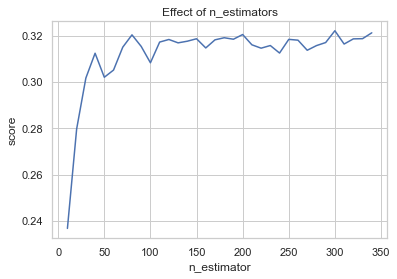

In [341]:
# Scale the data to be between -1 and 1
rf = RandomForestRegressor(n_jobs=-1)

# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 343, 10)
scores = []
for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(train_X, train_y)
    scores.append(rf.score(test_X, test_y))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [342]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
rf_score = cross_val_score(rf, x, y, cv=kfolds, scoring='neg_mean_squared_error')
rf_rmse =  np.sqrt(-rf_score.mean())
# Printing out Ridge Score and STD
print("Random Forest Model RMSE: ", rf_rmse)
print("Random Forest Model STD: ", rf_score.std())

Random Forest Model RMSE:  82.93054864035737
Random Forest Model STD:  239.24880936876679


In [343]:
preds_train=rf.predict(train_X)
preds1 = rf.predict(test_X)

Evaluation on test data
RMSE: 79.07
R2: 0.32
Adjusted R2: 0.32


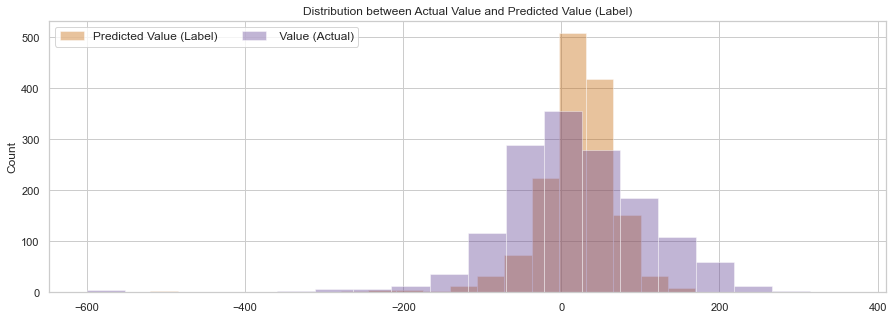

In [344]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_random_forest = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_random_forest["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_random_forest["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("")

plt.legend(( 'Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



In [345]:
output_data_random_forest.head(50)

output_data_random_forest["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Prediction"]]
output_data_random_forest["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Real"]]

In [346]:
output_data_random_forest.head(50)
comparison_column = np.where(output_data_random_forest["Prediction_sign"] == output_data_random_forest["Real_sign"], True, False)

In [347]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  993


In [348]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6727642276422764


$\textbf{Light GBM}$

In [349]:

lightgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, 
                                      min_sum_hessian_in_leaf = 11))

# Printing out LightGBM Score and STD
lightgbm_score = cross_val_score(lightgbm, x, y, cv=kfolds, scoring='neg_mean_squared_error')
lightgbm_rmse = np.sqrt(-lightgbm_score.mean())
print("LIGHTGBM RMSE: ", lightgbm_rmse)
print("LIGHTGBM STD: ", lightgbm_score.std())

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [350]:
# Training Model for later
lightgbm.fit(train_X, train_y)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lgbmregressor',
                 LGBMRegressor(bagging_fraction=0.8, bagging_freq=5,
                               bagging_seed=9, feature_fraction=0.2319,
                               feature_fraction_seed=9, learning_rate=0.05,
                               max_bin=55, min_data_in_leaf=6,
                               min_sum_hessian_in_leaf=11, n_estimators=720,
                               num_leaves=5, objective='regression'))])

In [351]:
preds_train=lightgbm.predict(train_X)
preds1 = lightgbm.predict(test_X)

Evaluation on test data
RMSE: 84.24
R2: 0.23
Adjusted R2: 0.23


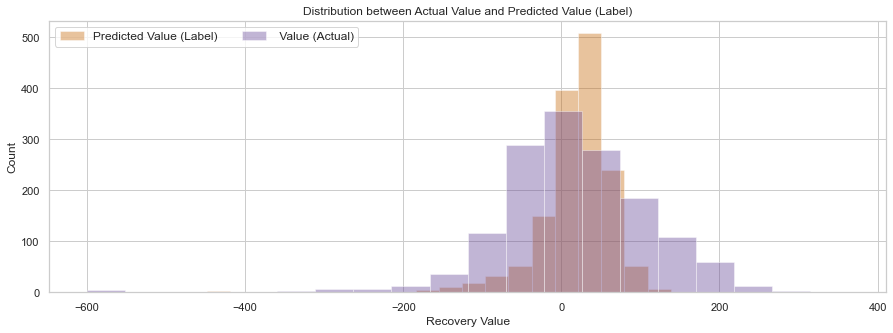

In [352]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_lightgbm = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_lightgbm["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_lightgbm["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(('Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



In [353]:
output_data_lightgbm.head(50)

output_data_lightgbm["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_lightgbm["Prediction"]]
output_data_lightgbm["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_lightgbm["Real"]]

In [354]:
output_data_lightgbm.head(50)
comparison_column = np.where(output_data_lightgbm["Prediction_sign"] == output_data_lightgbm["Real_sign"], True, False)

In [355]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  964


In [356]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6531165311653117


$\textbf{Ridge Regression}$

In [357]:
# Parameters for models
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]


ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = alphas_alt, cv=kfolds))
ridge_score = cross_val_score(ridge, x, y, cv=kfolds, scoring='neg_mean_squared_error')
ridge_rmse =  np.sqrt(-ridge_score.mean())
# Printing out Ridge Score and STD
print("RIDGE RMSE: ", ridge_rmse)
print("RIDGE STD: ", ridge_score.std())

RIDGE RMSE:  94.39076697032995
RIDGE STD:  99.120522093356


In [358]:
ridge.fit(train_X,train_y)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5]),
                         cv=KFold(n_splits=5, random_state=42, shuffle=True)))])

In [359]:
preds_train=lightgbm.predict(train_X)
preds1 = lightgbm.predict(test_X)

Evaluation on test data
RMSE: 84.24
R2: 0.23
Adjusted R2: 0.23


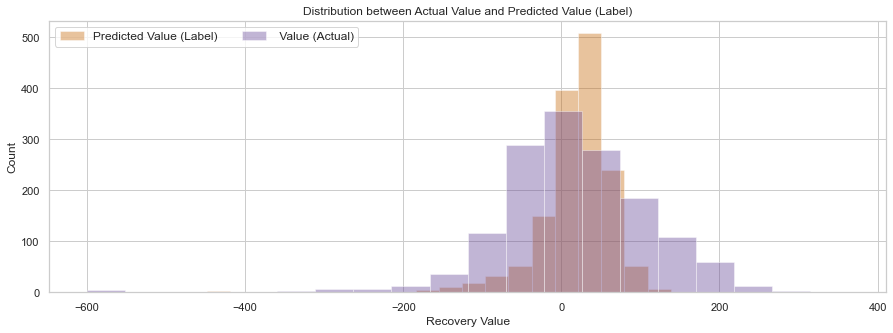

In [360]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_ridge_regression = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_ridge_regression["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_ridge_regression["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(( 'Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



In [361]:
output_data_ridge_regression["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_ridge_regression["Prediction"]]
output_data_ridge_regression["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_ridge_regression["Real"]]

In [362]:
comparison_column = np.where(output_data_ridge_regression["Prediction_sign"] == output_data_ridge_regression["Real_sign"], True, False)

In [363]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  964


In [364]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6531165311653117


$\textbf{Lasso Regression}$

In [365]:
# Lasso Model
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas = alphas2, random_state = 42, cv=kfolds))

# Printing Lasso Score with Cross-Validation
lasso_score = cross_val_score(lasso, x, y, cv=kfolds, scoring='neg_mean_squared_error')
lasso_rmse = np.sqrt(-lasso_score.mean())
print("LASSO RMSE: ", lasso_rmse)
print("LASSO STD: ", lasso_score.std())

LASSO RMSE:  94.3891771955021
LASSO STD:  99.80161529788215


In [366]:
#train_X, test_X, train_y, y_test
lasso.fit(train_X,train_y)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lassocv',
                 LassoCV(alphas=[5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                 0.0006, 0.0007, 0.0008],
                         cv=KFold(n_splits=5, random_state=42, shuffle=True),
                         max_iter=10000000.0, random_state=42))])

In [367]:
preds_train=lasso.predict(train_X)
preds1 = lasso.predict(test_X)

Evaluation on test data
RMSE: 92.71
R2: 0.07
Adjusted R2: 0.06


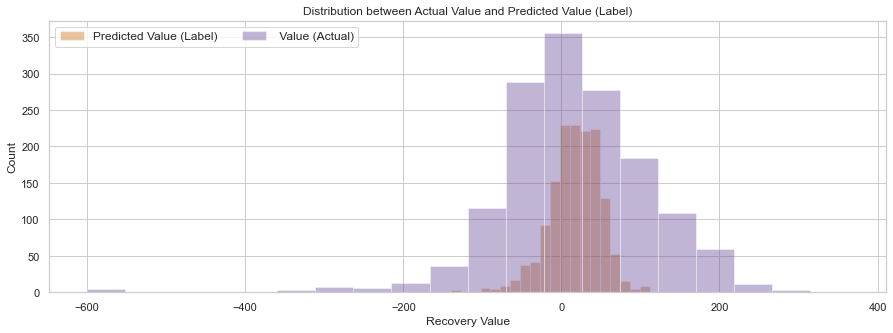

In [368]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_lasso_regression = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_lasso_regression["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_lasso_regression["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(('Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



In [369]:
output_data_lasso_regression["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_lasso_regression["Prediction"]]
output_data_lasso_regression["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_lasso_regression["Real"]]

In [370]:
comparison_column = np.where(output_data_lasso_regression["Prediction_sign"] == output_data_lasso_regression["Real_sign"], True, False)

In [371]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  921


In [372]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6239837398373984


$\textbf{Stacked Models}$

In [373]:
stack_gen = StackingCVRegressor(regressors=(modelCB,rf,ridge), 
                               meta_regressor=rf,
                               use_features_in_secondary=True)

stack_score = cross_val_score(stack_gen, x, y, cv=kfolds, scoring='neg_mean_squared_error')
stack_rmse = np.sqrt(-stack_score.mean())
print("STACK RMSE: ", stack_rmse)
print("STACK STD: ", stack_score.std())

STACK RMSE:  84.03400641041517
STACK STD:  141.967074915793


In [374]:
#Training Model for later
stack_gen.fit(train_X,train_y)

StackingCVRegressor(meta_regressor=RandomForestRegressor(n_estimators=340,
                                                         n_jobs=-1),
                    regressors=(<catboost.core.CatBoostRegressor object at 0x000001EE700CB6D0>,
                                RandomForestRegressor(n_estimators=340,
                                                      n_jobs=-1),
                                Pipeline(steps=[('robustscaler',
                                                 RobustScaler()),
                                                ('ridgecv',
                                                 RidgeCV(alphas=array([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5]),
                                                         cv=KFold(n_splits=5, random_state=42, shuffle=True)))])),
                    use_features_in_secondary=True)

In [375]:
preds_train=stack_gen.predict(train_X)
preds1 = stack_gen.predict(test_X)

Evaluation on test data
RMSE: 80.45
R2: 0.30
Adjusted R2: 0.30


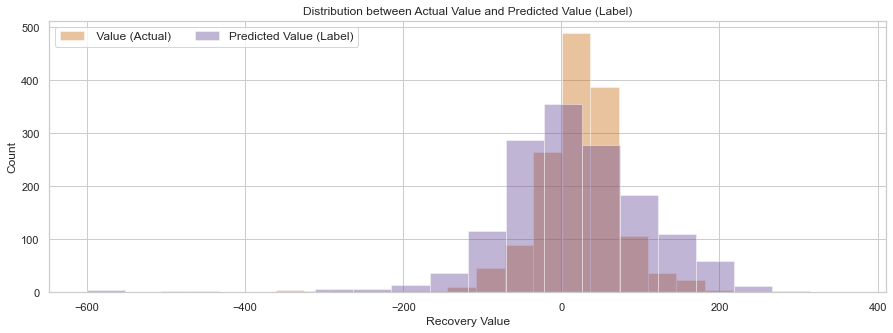

In [376]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_stacked_model = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_stacked_model["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_stacked_model["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



In [377]:
output_data_stacked_model["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_stacked_model["Prediction"]]
output_data_stacked_model["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_stacked_model["Real"]]

In [378]:
comparison_column = np.where(output_data_stacked_model["Prediction_sign"] == output_data_stacked_model["Real_sign"], True, False)

In [379]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  1001


In [380]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6781842818428184


$\textbf{Now we are going to add the Uplift feature i=1,2,3 and Holidays with is Weekend Categorical}$

* Random Forest Regression 
* CatBoost Regression

In [381]:
##### Add Uplift 1 
x = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[8],columns_data[9],columns_data[14],columns_data[15],columns_data[16],columns_data[17]], axis=1)
x.tail()

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR
2022-04-17 19:00:00,8.102876,2390.0,5708.0,498.5,1791.0
2022-04-17 20:00:00,9.936461,2395.0,5485.0,405.0,1766.0
2022-04-17 21:00:00,9.842898,2370.0,5065.0,140.0,1701.0
2022-04-17 22:00:00,9.795277,2320.0,4551.5,15.0,1606.0
2022-04-17 23:00:00,8.651543,2280.0,4201.0,0.0,1586.0


In [382]:
df_info(x)

,type,Sample,% of NaN,Corr_with_y,Duplicates,Amount Uniques,Uniques,Outliers
Uplift Account 1 (€/MWh),float64,"[2.7385476725, 2.3758374875, 2.143069245000000...",0,NaN,0,5904,Several,0
RES,float64,"[1820.0, 1930.0, 2000.0, 2035.0, 2055.0]",0,NaN,0,857,Several,0
Load,float64,"[5515.5, 5299.0, 5127.5, 5038.0, 4951.5]",0,NaN,0,4219,Several,0
Mandatory Hydro,float64,"[50.0, 50.0, 50.0, 63.0, 76.0]",0,NaN,0,1553,Several,0
Total FRR,float64,"[914.0, 939.0, 949.0, 939.0, 1079.0]",0,NaN,0,475,Several,0


Boxplot, IQR, qutliner for Uplift account 1 (€/mwh)


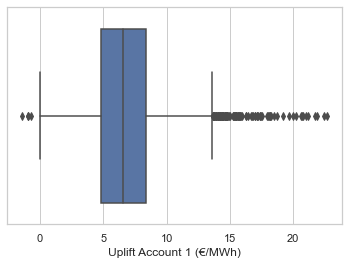

IQR For Uplift account 1 (€/mwh) Column :  3.505742676249998
There are 116 outliers out of 5904 data points.
There are many outliners in Uplift account 1 (€/mwh) columns
Boxplot, IQR, qutliner for Res


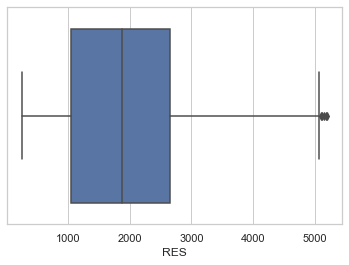

IQR For Res Column :  1610.0
There are 5 outliers out of 5904 data points.
There are many outliners in Res columns
Boxplot, IQR, qutliner for Load


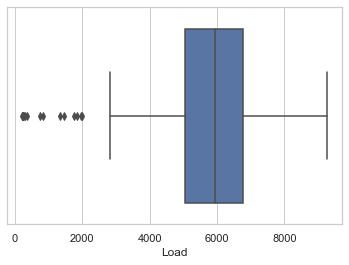

IQR For Load Column :  1709.75
There are 23 outliers out of 5904 data points.
There are many outliners in Load columns
Boxplot, IQR, qutliner for Mandatory hydro


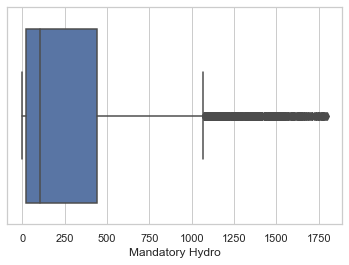

IQR For Mandatory hydro Column :  420.0
There are 598 outliers out of 5904 data points.
There are many outliners in Mandatory hydro columns
Boxplot, IQR, qutliner for Total frr


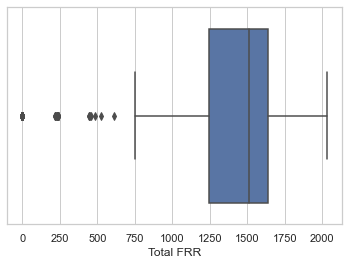

IQR For Total frr Column :  392.0
There are 168 outliers out of 5904 data points.
There are many outliners in Total frr columns


In [383]:
%matplotlib inline
from scipy import stats
n = x[x.columns[0]].count()
new_df = x.copy()

for name in x.columns: # this was "for name in names"
    print(f"Boxplot, IQR, qutliner for {name.capitalize()}")
    sns.boxplot(x=x[name])
    q1 = x[name].quantile(0.25)
    q3 = x[name].quantile(0.75)
    lower = q1 - 1.5 * stats.iqr(x[name],axis=0)
    upper = q3 + 1.5 * stats.iqr(x[name],axis=0)
    n_outliers = x[x[name] > upper][name].count() + x[x[name] < lower][name].count()
    plt.show()
    print(f"IQR For {name.capitalize()} Column : ",stats.iqr(x[name],axis=0))
    print(f"There are {n_outliers} outliers out of {n} data points.")
    if n_outliers != 0:
        p = n/n_outliers
        if p > 0.1:
            print(f"There are many outliners in {name.capitalize()} columns")
    
    new_df = new_df[new_df[name] < upper]
    new_df = new_df[new_df[name] > lower]

In [384]:
from holidays import Greece
greek_holidays = Greece()
# Have a look at all the holidays
[greek_holidays[date] for date in greek_holidays[datetime.date(2021,8,15):datetime.date(2022,4,17)]]
def get_holiday(date):
  try:
    day_type = greek_holidays[date]
  except KeyError:
    day_type = 'None'
  return day_type

x['Holidays'] = x.index.map(lambda x: get_holiday(x))

x.head()
holidays=[greek_holidays[date] for date in greek_holidays[datetime.date(2021,8,15):datetime.date(2022,4,17)]]


x.loc[x['Holidays'] =='None','Holidays'] = 0
x.loc[x["Holidays"].isin(holidays),'Holidays'] = 1
x.head()

x["Date"] = pd.to_datetime(x.index)
x["IsWeekend"] = x["Date"].dt.weekday >= 5

x.replace({False: 0, True: 1}, inplace=True)

x = x.drop("Date",axis=1)
# display the dataframe


x.head()

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,Holidays,IsWeekend
2021-08-15 00:00:00,2.738548,1820.0,5515.5,50.0,914.0,1,1
2021-08-15 01:00:00,2.375837,1930.0,5299.0,50.0,939.0,1,1
2021-08-15 02:00:00,2.143069,2000.0,5127.5,50.0,949.0,1,1
2021-08-15 03:00:00,2.043232,2035.0,5038.0,63.0,939.0,1,1
2021-08-15 04:00:00,2.227400,2055.0,4951.5,76.0,1079.0,1,1


In [385]:
x.head()

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,Holidays,IsWeekend
2021-08-15 00:00:00,2.738548,1820.0,5515.5,50.0,914.0,1,1
2021-08-15 01:00:00,2.375837,1930.0,5299.0,50.0,939.0,1,1
2021-08-15 02:00:00,2.143069,2000.0,5127.5,50.0,949.0,1,1
2021-08-15 03:00:00,2.043232,2035.0,5038.0,63.0,939.0,1,1
2021-08-15 04:00:00,2.227400,2055.0,4951.5,76.0,1079.0,1,1


In [386]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.25)

In [387]:
train_X.head()

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,Holidays,IsWeekend
2021-09-04 11:00:00,3.052043,2875.0,6549.0,19.0,1674.0,0,1
2021-08-29 05:00:00,2.737946,485.0,5050.0,154.0,1399.0,0,1
2021-12-31 05:00:00,2.750249,3045.0,4998.5,1082.0,1634.0,0,0
2021-10-15 16:00:00,8.483408,1555.0,5804.0,155.0,1569.0,0,0
2022-03-12 01:00:00,9.137718,755.0,5421.5,0.0,856.0,0,1


In [388]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = ["Uplift Account 1 (€/MWh)","RES","Load","Mandatory Hydro","Total FRR"]

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X)

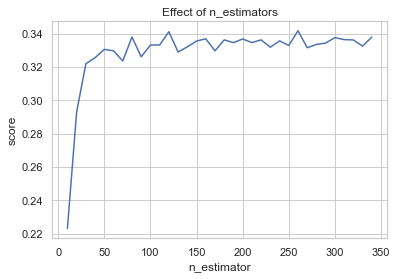

In [389]:
# Scale the data to be between -1 and 1
rf = RandomForestRegressor(n_jobs=-1)

# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 343, 10)
scores = []
for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(train_X, train_y)
    scores.append(rf.score(test_X, test_y))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [390]:
rf_score = cross_val_score(rf, x, y, cv=kfolds, scoring='neg_mean_squared_error')
rf_rmse =  np.sqrt(-rf_score.mean())
# Printing out Ridge Score and STD
print("Random Forest Model RMSE: ", rf_rmse)
print("Random Forest Model STD: ", rf_score.std())

Random Forest Model RMSE:  83.12609961755955
Random Forest Model STD:  246.85546176580777


In [391]:
preds_train=rf.predict(train_X)
preds1 = rf.predict(test_X)

Evaluation on test data
RMSE: 78.98
R2: 0.34
Adjusted R2: 0.34


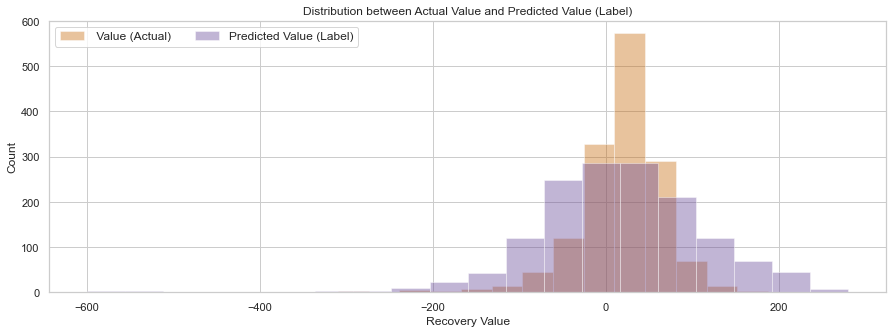

In [392]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_random_forest = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_random_forest["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_random_forest["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



In [393]:
output_data_random_forest.head(50)
output_data_random_forest["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Prediction"]]
output_data_random_forest["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Real"]]

In [394]:
output_data_random_forest.head(50)
comparison_column = np.where(output_data_random_forest["Prediction_sign"] == output_data_random_forest["Real_sign"], True, False)

In [395]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  1037


In [396]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.7025745257452575


Evaluation on test data
RMSE: 81.10
R2: 0.30
Adjusted R2: 0.30
We have a total of True values :  1012
Accuracy of True values compared to the total observations : 0.6856368563685636


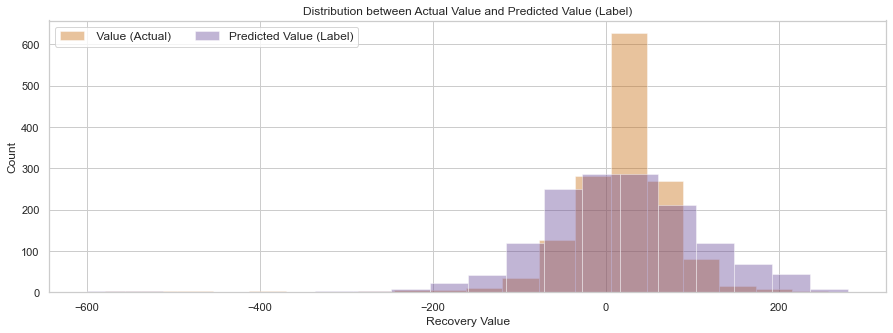

In [397]:
#Training Model for later
stack_gen.fit(train_X,train_y)

preds_train=stack_gen.predict(train_X)
preds1 = stack_gen.predict(test_X)

import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_stacked_model = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_stacked_model["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_stacked_model["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



output_data_stacked_model["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_stacked_model["Prediction"]]
output_data_stacked_model["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_stacked_model["Real"]]

comparison_column = np.where(output_data_stacked_model["Prediction_sign"] == output_data_stacked_model["Real_sign"], True, False)

count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

$\textbf{We are going to test the Model is some Data fro  2022/04/26 until 2022/04/30}$

In [398]:
Data_Test = pd.read_csv('Data_classification.csv')
columns_data_test = Data_Test.columns

In [399]:
Data_Test.head()

,Unnamed: 0,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,Diff_direction,Gradient_Boosting_Classification,Neural_network_Classification,Holidays,IsWeekend,Day_ahead_Balancing_diff,Date
0,2022-04-26 00:00:00,9.139706,960.0,4196.0,0.0,841.0,1,0,1,0,0,235.420,2022-04-26 00:00:00
1,2022-04-26 01:00:00,8.887252,910.0,4081.0,0.0,846.0,1,0,1,0,0,222.745,2022-04-26 01:00:00
2,2022-04-26 02:00:00,8.544882,875.0,3999.5,0.0,846.0,1,0,1,0,0,228.630,2022-04-26 02:00:00
3,2022-04-26 03:00:00,8.319490,840.0,4007.5,13.0,861.0,1,0,1,0,0,218.865,2022-04-26 03:00:00
4,2022-04-26 04:00:00,8.380914,780.0,4083.5,86.0,1031.0,1,0,0,0,0,218.980,2022-04-26 04:00:00


In [400]:
Data_Test[columns_data_test[0]] = pd.to_datetime(Data_Test[columns_data_test[0]])
Data_Test.set_index(columns_data_test[0], drop=True, inplace=True)
Data_Test.index.name = None

In [401]:
Data_Test = Data_Test.drop("Date",axis=1)

In [402]:
Data_Test.head()

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,Diff_direction,Gradient_Boosting_Classification,Neural_network_Classification,Holidays,IsWeekend,Day_ahead_Balancing_diff
2022-04-26 00:00:00,9.139706,960.0,4196.0,0.0,841.0,1,0,1,0,0,235.420
2022-04-26 01:00:00,8.887252,910.0,4081.0,0.0,846.0,1,0,1,0,0,222.745
2022-04-26 02:00:00,8.544882,875.0,3999.5,0.0,846.0,1,0,1,0,0,228.630
2022-04-26 03:00:00,8.319490,840.0,4007.5,13.0,861.0,1,0,1,0,0,218.865
2022-04-26 04:00:00,8.380914,780.0,4083.5,86.0,1031.0,1,0,0,0,0,218.980


In [403]:
direction_classification = Data_Test[[columns_data_test[6],columns_data_test[7],columns_data_test[8]]]
Data_Test = Data_Test.drop([columns_data_test[6],columns_data_test[7],columns_data_test[8]],axis=1)


In [404]:
y_validation = Data_Test["Day_ahead_Balancing_diff"]

X_validation = Data_Test.drop("Day_ahead_Balancing_diff",axis=1)

In [405]:
X_validation.head()

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,Holidays,IsWeekend
2022-04-26 00:00:00,9.139706,960.0,4196.0,0.0,841.0,0,0
2022-04-26 01:00:00,8.887252,910.0,4081.0,0.0,846.0,0,0
2022-04-26 02:00:00,8.544882,875.0,3999.5,0.0,846.0,0,0
2022-04-26 03:00:00,8.319490,840.0,4007.5,13.0,861.0,0,0
2022-04-26 04:00:00,8.380914,780.0,4083.5,86.0,1031.0,0,0


In [406]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = ["Uplift Account 1 (€/MWh)","RES","Load","Mandatory Hydro","Total FRR"]

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X_validation = ct.fit_transform(X_validation)
#test_X = ct.transform(test_X)

In [407]:
train_X_validation

array([[ 0.80758852,  0.09692671,  0.21313152, ..., -2.124887  ,
         0.        ,  0.        ],
       [ 0.7757646 ,  0.08510638,  0.16608713, ..., -2.10569488,
         0.        ,  0.        ],
       [ 0.73260589,  0.07683215,  0.13274698, ..., -2.10569488,
         0.        ,  0.        ],
       ...,
       [ 0.61992233,  0.27068558,  0.43996727, ...,  0.52362487,
         0.        ,  1.        ],
       [ 0.58123772,  0.26359338,  0.24503989, ...,  0.5620091 ,
         0.        ,  1.        ],
       [ 0.6131758 ,  0.26004728,  0.0957251 , ...,  0.50443276,
         0.        ,  1.        ]])

Evaluation on test data
RMSE: 159.48
R2: -0.24
Adjusted R2: -0.38


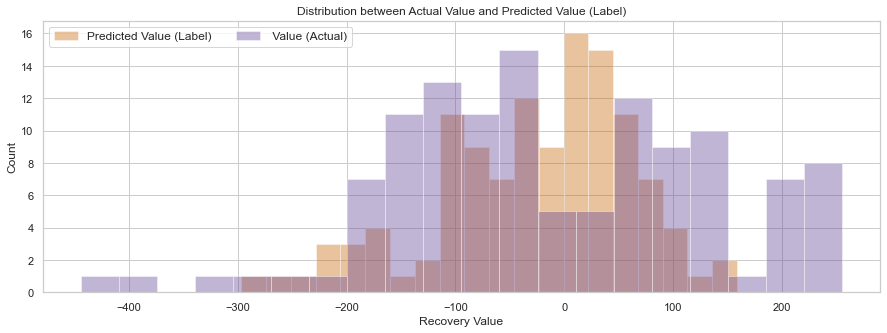

In [410]:
preds_train_validation = stack_gen.predict(train_X_validation)
preds1_stacked_model = stack_gen.predict(train_X_validation)
#preds1 = rf.predict(test_X)

import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(y_validation,preds_train_validation))
#R2 Score
r2_test = r2_score(y_validation,preds_train_validation)
# Adjusted R2 Score
n= train_X_validation.shape[0] # total no of datapoints
p= train_X_validation.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_random_forest = pd.DataFrame({
                      'Prediction': preds_train_validation,'Real': y_validation})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_random_forest["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_random_forest["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(('Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)





In [411]:
output_data_random_forest.head(50)

output_data_random_forest["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Prediction"]]
output_data_random_forest["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Real"]]

output_data_random_forest.head(50)
comparison_column = np.where(output_data_random_forest["Prediction_sign"] == output_data_random_forest["Real_sign"], True, False)

count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

We have a total of True values :  62
Accuracy of True values compared to the total observations : 0.5166666666666667


In [412]:
output_data_random_forest

,Prediction,Real,Prediction_sign,Real_sign
2022-04-26 00:00:00,-85.659552,235.420000,0,1
2022-04-26 01:00:00,-95.656400,222.745000,0,1
2022-04-26 02:00:00,-59.423043,228.630000,0,1
2022-04-26 03:00:00,-67.243529,218.865000,0,1
2022-04-26 04:00:00,-16.285283,218.980000,0,1
2022-04-26 05:00:00,-63.937673,190.497828,0,1
2022-04-26 06:00:00,-53.116863,73.965872,0,1
2022-04-26 07:00:00,-97.901423,134.943521,0,1
2022-04-26 08:00:00,2.021164,185.818925,1,1
2022-04-26 09:00:00,7.914114,131.404649,1,1


In [305]:
Data_test_final = pd.read_csv('Data_classification.csv')
Data_test_final["Prediction_Random_Forest_Regression"] = output_data_random_forest["Prediction_sign"].values

In [292]:
##### Add Uplift 1 
x = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[8],columns_data[9],columns_data[14],columns_data[15],columns_data[16],columns_data[17]], axis=1)
x.head()



,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR
2021-08-15 00:00:00,2.738548,1820.0,5515.5,50.0,914.0
2021-08-15 01:00:00,2.375837,1930.0,5299.0,50.0,939.0
2021-08-15 02:00:00,2.143069,2000.0,5127.5,50.0,949.0
2021-08-15 03:00:00,2.043232,2035.0,5038.0,63.0,939.0
2021-08-15 04:00:00,2.227400,2055.0,4951.5,76.0,1079.0


In [293]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score


train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.25)

In [294]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = train_X.columns

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMS:  89.97503332579825


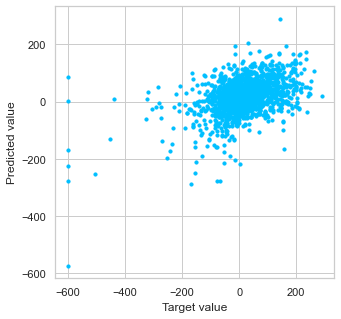

In [295]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

train_pool = Pool(train_X, 
                  train_y)
test_pool = Pool(test_X) 


####{'colsample_bylevel': 4, 'learning_rate': 5, 'max_depth': 4}, 

#### Grid Search 
# {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}
modelCB = CatBoostRegressor(iterations=8000,
                           depth=4,
                           learning_rate=0.08,
                           loss_function='RMSE',
                           silent=True)

modelCB.fit(train_pool,plot=True)

preds1 = modelCB.predict(test_pool)

preds_train=modelCB.predict(train_pool)
# evaluate predictions
rms1 = mean_squared_error(test_y, preds1, squared=False) #np.sqrt(np.mean((preds1 - test_y) ** 2))
print("RMS: ", rms1)
#print(preds1)



plt.figure(figsize=(5,5))
plt.scatter(test_y, preds1, s=10, color="deepskyblue")
plt.xlabel("Target value")
plt.ylabel("Predicted value")
print(train_pool)

Accuracy is :  -203.56052802726896


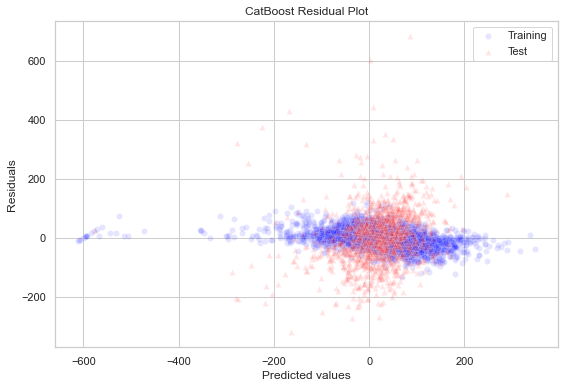

Evaluation on test data
RMSE: 89.98
R2: 0.16
Adjusted R2: 0.16
We have a total of True values :  963
Accuracy of True values compared to the total observations : 0.6524390243902439
Test set evaluation:
_____________________________________
MAE: 66.74849362568084
MSE: 8095.506621978506
RMSE: 89.97503332579825
R2 Square 0.16060137646481554
__________________________________
Train set evaluation:
_____________________________________
MAE: 21.74787897810217
MSE: 822.8535059824767
RMSE: 28.685423231712594
R2 Square 0.9160409474749318
__________________________________
Learning rate set to 0.052543
0:	learn: 102.1978165	total: 10.7ms	remaining: 10.7s
1:	learn: 101.5624586	total: 14.4ms	remaining: 7.17s
2:	learn: 101.0179821	total: 18ms	remaining: 5.99s
3:	learn: 100.5346062	total: 22.4ms	remaining: 5.57s
4:	learn: 100.0849358	total: 25.9ms	remaining: 5.16s
5:	learn: 99.5692605	total: 29.5ms	remaining: 4.89s
6:	learn: 99.1364292	total: 33.3ms	remaining: 4.73s
7:	learn: 98.7494503	total: 37ms	

189:	learn: 81.2721056	total: 807ms	remaining: 3.44s
190:	learn: 81.2400667	total: 811ms	remaining: 3.43s
191:	learn: 81.1967429	total: 814ms	remaining: 3.43s
192:	learn: 81.1505603	total: 818ms	remaining: 3.42s
193:	learn: 81.1073570	total: 822ms	remaining: 3.42s
194:	learn: 81.0641278	total: 826ms	remaining: 3.41s
195:	learn: 81.0151144	total: 830ms	remaining: 3.4s
196:	learn: 80.9706789	total: 833ms	remaining: 3.4s
197:	learn: 80.9269642	total: 837ms	remaining: 3.39s
198:	learn: 80.8955604	total: 841ms	remaining: 3.38s
199:	learn: 80.8535506	total: 844ms	remaining: 3.38s
200:	learn: 80.7866250	total: 847ms	remaining: 3.37s
201:	learn: 80.7389941	total: 851ms	remaining: 3.36s
202:	learn: 80.6857688	total: 856ms	remaining: 3.36s
203:	learn: 80.6393738	total: 860ms	remaining: 3.35s
204:	learn: 80.5948060	total: 863ms	remaining: 3.35s
205:	learn: 80.5306991	total: 867ms	remaining: 3.34s
206:	learn: 80.4942546	total: 870ms	remaining: 3.33s
207:	learn: 80.4399543	total: 874ms	remaining: 3

364:	learn: 74.7615221	total: 1.65s	remaining: 2.87s
365:	learn: 74.7419929	total: 1.65s	remaining: 2.87s
366:	learn: 74.6992977	total: 1.66s	remaining: 2.87s
367:	learn: 74.6600478	total: 1.67s	remaining: 2.86s
368:	learn: 74.6311601	total: 1.67s	remaining: 2.86s
369:	learn: 74.6165934	total: 1.68s	remaining: 2.86s
370:	learn: 74.5846638	total: 1.68s	remaining: 2.85s
371:	learn: 74.5703118	total: 1.69s	remaining: 2.85s
372:	learn: 74.5452047	total: 1.69s	remaining: 2.85s
373:	learn: 74.5021743	total: 1.7s	remaining: 2.84s
374:	learn: 74.4905918	total: 1.7s	remaining: 2.83s
375:	learn: 74.4396316	total: 1.71s	remaining: 2.83s
376:	learn: 74.4299710	total: 1.71s	remaining: 2.83s
377:	learn: 74.4070867	total: 1.71s	remaining: 2.82s
378:	learn: 74.3835456	total: 1.72s	remaining: 2.81s
379:	learn: 74.3564047	total: 1.72s	remaining: 2.81s
380:	learn: 74.3250249	total: 1.73s	remaining: 2.8s
381:	learn: 74.3064225	total: 1.73s	remaining: 2.8s
382:	learn: 74.2855277	total: 1.74s	remaining: 2.8

528:	learn: 70.4739908	total: 2.46s	remaining: 2.19s
529:	learn: 70.4554089	total: 2.46s	remaining: 2.18s
530:	learn: 70.4357625	total: 2.46s	remaining: 2.17s
531:	learn: 70.4092209	total: 2.47s	remaining: 2.17s
532:	learn: 70.3835264	total: 2.48s	remaining: 2.17s
533:	learn: 70.3537256	total: 2.48s	remaining: 2.16s
534:	learn: 70.3292439	total: 2.49s	remaining: 2.16s
535:	learn: 70.3005834	total: 2.49s	remaining: 2.16s
536:	learn: 70.2876613	total: 2.49s	remaining: 2.15s
537:	learn: 70.2626074	total: 2.5s	remaining: 2.15s
538:	learn: 70.2419383	total: 2.51s	remaining: 2.14s
539:	learn: 70.2195441	total: 2.51s	remaining: 2.14s
540:	learn: 70.1884421	total: 2.52s	remaining: 2.13s
541:	learn: 70.1697771	total: 2.52s	remaining: 2.13s
542:	learn: 70.1447021	total: 2.53s	remaining: 2.13s
543:	learn: 70.1222265	total: 2.53s	remaining: 2.12s
544:	learn: 70.0902407	total: 2.54s	remaining: 2.12s
545:	learn: 70.0708775	total: 2.54s	remaining: 2.12s
546:	learn: 70.0483884	total: 2.55s	remaining: 

691:	learn: 66.9837084	total: 3.28s	remaining: 1.46s
692:	learn: 66.9603493	total: 3.29s	remaining: 1.46s
693:	learn: 66.9391421	total: 3.29s	remaining: 1.45s
694:	learn: 66.9226079	total: 3.3s	remaining: 1.45s
695:	learn: 66.8986762	total: 3.3s	remaining: 1.44s
696:	learn: 66.8861331	total: 3.31s	remaining: 1.44s
697:	learn: 66.8648015	total: 3.31s	remaining: 1.43s
698:	learn: 66.8483100	total: 3.32s	remaining: 1.43s
699:	learn: 66.8239361	total: 3.33s	remaining: 1.43s
700:	learn: 66.8102957	total: 3.33s	remaining: 1.42s
701:	learn: 66.7948553	total: 3.33s	remaining: 1.41s
702:	learn: 66.7804875	total: 3.34s	remaining: 1.41s
703:	learn: 66.7656912	total: 3.34s	remaining: 1.41s
704:	learn: 66.7479537	total: 3.35s	remaining: 1.4s
705:	learn: 66.7221292	total: 3.36s	remaining: 1.4s
706:	learn: 66.6975604	total: 3.36s	remaining: 1.39s
707:	learn: 66.6666812	total: 3.36s	remaining: 1.39s
708:	learn: 66.6442821	total: 3.37s	remaining: 1.38s
709:	learn: 66.6327436	total: 3.38s	remaining: 1.3

854:	learn: 64.1139593	total: 4.12s	remaining: 698ms
855:	learn: 64.1064239	total: 4.12s	remaining: 694ms
856:	learn: 64.0932037	total: 4.13s	remaining: 689ms
857:	learn: 64.0868802	total: 4.13s	remaining: 684ms
858:	learn: 64.0779995	total: 4.14s	remaining: 679ms
859:	learn: 64.0638850	total: 4.14s	remaining: 675ms
860:	learn: 64.0560659	total: 4.15s	remaining: 670ms
861:	learn: 64.0436271	total: 4.15s	remaining: 665ms
862:	learn: 64.0126909	total: 4.16s	remaining: 660ms
863:	learn: 64.0025926	total: 4.16s	remaining: 655ms
864:	learn: 63.9872753	total: 4.17s	remaining: 650ms
865:	learn: 63.9828714	total: 4.17s	remaining: 646ms
866:	learn: 63.9624235	total: 4.18s	remaining: 641ms
867:	learn: 63.9527116	total: 4.18s	remaining: 636ms
868:	learn: 63.9466154	total: 4.19s	remaining: 631ms
869:	learn: 63.9339861	total: 4.19s	remaining: 626ms
870:	learn: 63.9174449	total: 4.2s	remaining: 622ms
871:	learn: 63.8986570	total: 4.21s	remaining: 618ms
872:	learn: 63.8940642	total: 4.21s	remaining: 

12:	learn: 97.2702604	total: 57.6ms	remaining: 4.37s
13:	learn: 97.0045984	total: 62ms	remaining: 4.37s
14:	learn: 96.7040447	total: 65.5ms	remaining: 4.3s
15:	learn: 96.4577725	total: 72.1ms	remaining: 4.43s
16:	learn: 96.1656117	total: 76.1ms	remaining: 4.4s
17:	learn: 95.9898806	total: 79.5ms	remaining: 4.34s
18:	learn: 95.7799162	total: 86.2ms	remaining: 4.45s
19:	learn: 95.6043648	total: 90.6ms	remaining: 4.44s
20:	learn: 95.4143462	total: 94ms	remaining: 4.38s
21:	learn: 95.2072213	total: 98.2ms	remaining: 4.37s
22:	learn: 94.9490287	total: 104ms	remaining: 4.44s
23:	learn: 94.7367447	total: 108ms	remaining: 4.4s
24:	learn: 94.5443290	total: 112ms	remaining: 4.38s
25:	learn: 94.3670639	total: 119ms	remaining: 4.46s
26:	learn: 94.1480087	total: 123ms	remaining: 4.43s
27:	learn: 93.9650131	total: 130ms	remaining: 4.51s
28:	learn: 93.7997006	total: 137ms	remaining: 4.58s
29:	learn: 93.6193723	total: 141ms	remaining: 4.55s
30:	learn: 93.4000618	total: 148ms	remaining: 4.64s
31:	learn

187:	learn: 81.6859806	total: 893ms	remaining: 3.86s
188:	learn: 81.6295669	total: 897ms	remaining: 3.85s
189:	learn: 81.5871325	total: 902ms	remaining: 3.85s
190:	learn: 81.5437810	total: 907ms	remaining: 3.84s
191:	learn: 81.5097081	total: 911ms	remaining: 3.83s
192:	learn: 81.4603088	total: 916ms	remaining: 3.83s
193:	learn: 81.4172522	total: 921ms	remaining: 3.83s
194:	learn: 81.3837136	total: 925ms	remaining: 3.82s
195:	learn: 81.3437836	total: 930ms	remaining: 3.81s
196:	learn: 81.3056492	total: 935ms	remaining: 3.81s
197:	learn: 81.2681330	total: 940ms	remaining: 3.81s
198:	learn: 81.2179811	total: 944ms	remaining: 3.8s
199:	learn: 81.1777803	total: 952ms	remaining: 3.81s
200:	learn: 81.1304445	total: 956ms	remaining: 3.8s
201:	learn: 81.0824398	total: 960ms	remaining: 3.79s
202:	learn: 81.0445633	total: 964ms	remaining: 3.78s
203:	learn: 80.9956471	total: 969ms	remaining: 3.78s
204:	learn: 80.9429254	total: 973ms	remaining: 3.77s
205:	learn: 80.8531599	total: 977ms	remaining: 3

369:	learn: 74.5839275	total: 1.57s	remaining: 2.68s
370:	learn: 74.5352079	total: 1.58s	remaining: 2.68s
371:	learn: 74.4914942	total: 1.58s	remaining: 2.67s
372:	learn: 74.4642134	total: 1.59s	remaining: 2.67s
373:	learn: 74.4368179	total: 1.59s	remaining: 2.67s
374:	learn: 74.4167282	total: 1.6s	remaining: 2.66s
375:	learn: 74.3866143	total: 1.6s	remaining: 2.65s
376:	learn: 74.3559669	total: 1.6s	remaining: 2.65s
377:	learn: 74.3271394	total: 1.61s	remaining: 2.65s
378:	learn: 74.3081385	total: 1.61s	remaining: 2.65s
379:	learn: 74.2943582	total: 1.62s	remaining: 2.64s
380:	learn: 74.2709788	total: 1.62s	remaining: 2.64s
381:	learn: 74.2418758	total: 1.63s	remaining: 2.63s
382:	learn: 74.2051930	total: 1.63s	remaining: 2.63s
383:	learn: 74.1854648	total: 1.64s	remaining: 2.63s
384:	learn: 74.1578979	total: 1.64s	remaining: 2.63s
385:	learn: 74.1308123	total: 1.65s	remaining: 2.62s
386:	learn: 74.1066862	total: 1.66s	remaining: 2.62s
387:	learn: 74.0769914	total: 1.66s	remaining: 2.

535:	learn: 70.0646329	total: 2.25s	remaining: 1.95s
536:	learn: 70.0219232	total: 2.25s	remaining: 1.94s
537:	learn: 70.0043117	total: 2.25s	remaining: 1.94s
538:	learn: 69.9849591	total: 2.26s	remaining: 1.93s
539:	learn: 69.9510301	total: 2.26s	remaining: 1.93s
540:	learn: 69.9153924	total: 2.26s	remaining: 1.92s
541:	learn: 69.8939659	total: 2.27s	remaining: 1.92s
542:	learn: 69.8755168	total: 2.27s	remaining: 1.91s
543:	learn: 69.8573741	total: 2.27s	remaining: 1.91s
544:	learn: 69.8337821	total: 2.28s	remaining: 1.9s
545:	learn: 69.8145463	total: 2.28s	remaining: 1.9s
546:	learn: 69.7907045	total: 2.29s	remaining: 1.89s
547:	learn: 69.7720203	total: 2.29s	remaining: 1.89s
548:	learn: 69.7566838	total: 2.29s	remaining: 1.88s
549:	learn: 69.7426103	total: 2.3s	remaining: 1.88s
550:	learn: 69.7118684	total: 2.3s	remaining: 1.87s
551:	learn: 69.6674399	total: 2.3s	remaining: 1.87s
552:	learn: 69.6540718	total: 2.31s	remaining: 1.87s
553:	learn: 69.6223400	total: 2.31s	remaining: 1.86

705:	learn: 66.3964401	total: 2.9s	remaining: 1.21s
706:	learn: 66.3789489	total: 2.91s	remaining: 1.2s
707:	learn: 66.3572683	total: 2.92s	remaining: 1.2s
708:	learn: 66.3252033	total: 2.92s	remaining: 1.2s
709:	learn: 66.3031747	total: 2.92s	remaining: 1.19s
710:	learn: 66.2858827	total: 2.93s	remaining: 1.19s
711:	learn: 66.2679316	total: 2.93s	remaining: 1.19s
712:	learn: 66.2485356	total: 2.94s	remaining: 1.18s
713:	learn: 66.2247343	total: 2.94s	remaining: 1.18s
714:	learn: 66.2040568	total: 2.95s	remaining: 1.17s
715:	learn: 66.1870166	total: 2.95s	remaining: 1.17s
716:	learn: 66.1757527	total: 2.96s	remaining: 1.17s
717:	learn: 66.1621228	total: 2.96s	remaining: 1.16s
718:	learn: 66.1340741	total: 2.97s	remaining: 1.16s
719:	learn: 66.1281448	total: 2.97s	remaining: 1.16s
720:	learn: 66.1249619	total: 2.98s	remaining: 1.15s
721:	learn: 66.1029494	total: 2.98s	remaining: 1.15s
722:	learn: 66.0878278	total: 2.98s	remaining: 1.14s
723:	learn: 66.0601711	total: 2.99s	remaining: 1.1

869:	learn: 63.5162081	total: 3.57s	remaining: 534ms
870:	learn: 63.4888126	total: 3.58s	remaining: 530ms
871:	learn: 63.4828813	total: 3.58s	remaining: 526ms
872:	learn: 63.4654073	total: 3.59s	remaining: 522ms
873:	learn: 63.4500112	total: 3.59s	remaining: 518ms
874:	learn: 63.4415483	total: 3.6s	remaining: 514ms
875:	learn: 63.4111487	total: 3.6s	remaining: 510ms
876:	learn: 63.3972407	total: 3.61s	remaining: 506ms
877:	learn: 63.3875091	total: 3.61s	remaining: 502ms
878:	learn: 63.3664305	total: 3.62s	remaining: 498ms
879:	learn: 63.3507739	total: 3.62s	remaining: 494ms
880:	learn: 63.3303651	total: 3.63s	remaining: 490ms
881:	learn: 63.3054653	total: 3.63s	remaining: 486ms
882:	learn: 63.2881835	total: 3.63s	remaining: 482ms
883:	learn: 63.2666016	total: 3.64s	remaining: 478ms
884:	learn: 63.2559008	total: 3.65s	remaining: 474ms
885:	learn: 63.2403849	total: 3.65s	remaining: 470ms
886:	learn: 63.2322518	total: 3.66s	remaining: 466ms
887:	learn: 63.2051182	total: 3.66s	remaining: 4

36:	learn: 89.1892676	total: 132ms	remaining: 3.43s
37:	learn: 88.9868473	total: 135ms	remaining: 3.43s
38:	learn: 88.8793066	total: 139ms	remaining: 3.43s
39:	learn: 88.7620722	total: 143ms	remaining: 3.43s
40:	learn: 88.6465570	total: 147ms	remaining: 3.43s
41:	learn: 88.5454338	total: 150ms	remaining: 3.43s
42:	learn: 88.3719723	total: 154ms	remaining: 3.43s
43:	learn: 88.2695227	total: 158ms	remaining: 3.43s
44:	learn: 88.1542489	total: 162ms	remaining: 3.43s
45:	learn: 88.0344942	total: 165ms	remaining: 3.42s
46:	learn: 87.9486988	total: 169ms	remaining: 3.42s
47:	learn: 87.8304450	total: 173ms	remaining: 3.42s
48:	learn: 87.7019705	total: 176ms	remaining: 3.42s
49:	learn: 87.6000374	total: 180ms	remaining: 3.43s
50:	learn: 87.4669674	total: 185ms	remaining: 3.45s
51:	learn: 87.3435700	total: 189ms	remaining: 3.44s
52:	learn: 87.2346082	total: 193ms	remaining: 3.44s
53:	learn: 87.1029809	total: 196ms	remaining: 3.44s
54:	learn: 87.0295636	total: 200ms	remaining: 3.43s
55:	learn: 8

200:	learn: 78.4726213	total: 805ms	remaining: 3.2s
201:	learn: 78.4039451	total: 810ms	remaining: 3.2s
202:	learn: 78.3645243	total: 816ms	remaining: 3.2s
203:	learn: 78.2829343	total: 819ms	remaining: 3.19s
204:	learn: 78.2095832	total: 823ms	remaining: 3.19s
205:	learn: 78.1381355	total: 826ms	remaining: 3.19s
206:	learn: 78.0949554	total: 830ms	remaining: 3.18s
207:	learn: 78.0656381	total: 834ms	remaining: 3.17s
208:	learn: 78.0277746	total: 838ms	remaining: 3.17s
209:	learn: 77.9950743	total: 842ms	remaining: 3.17s
210:	learn: 77.9353345	total: 845ms	remaining: 3.16s
211:	learn: 77.8983553	total: 849ms	remaining: 3.16s
212:	learn: 77.8473137	total: 853ms	remaining: 3.15s
213:	learn: 77.8051172	total: 857ms	remaining: 3.15s
214:	learn: 77.7586118	total: 860ms	remaining: 3.14s
215:	learn: 77.7182523	total: 865ms	remaining: 3.14s
216:	learn: 77.6786658	total: 870ms	remaining: 3.14s
217:	learn: 77.6418159	total: 876ms	remaining: 3.14s
218:	learn: 77.5838684	total: 880ms	remaining: 3.

362:	learn: 72.3520486	total: 1.47s	remaining: 2.57s
363:	learn: 72.3040299	total: 1.47s	remaining: 2.57s
364:	learn: 72.2747292	total: 1.47s	remaining: 2.56s
365:	learn: 72.2335675	total: 1.48s	remaining: 2.56s
366:	learn: 72.2141447	total: 1.48s	remaining: 2.55s
367:	learn: 72.1752704	total: 1.48s	remaining: 2.55s
368:	learn: 72.1382660	total: 1.49s	remaining: 2.54s
369:	learn: 72.1215951	total: 1.49s	remaining: 2.54s
370:	learn: 72.0934312	total: 1.49s	remaining: 2.53s
371:	learn: 72.0594515	total: 1.5s	remaining: 2.53s
372:	learn: 72.0248311	total: 1.5s	remaining: 2.52s
373:	learn: 71.9872145	total: 1.5s	remaining: 2.52s
374:	learn: 71.9607587	total: 1.51s	remaining: 2.52s
375:	learn: 71.9171646	total: 1.51s	remaining: 2.51s
376:	learn: 71.8694934	total: 1.52s	remaining: 2.51s
377:	learn: 71.8348667	total: 1.52s	remaining: 2.5s
378:	learn: 71.8029024	total: 1.52s	remaining: 2.5s
379:	learn: 71.7725189	total: 1.53s	remaining: 2.49s
380:	learn: 71.7493577	total: 1.53s	remaining: 2.49

536:	learn: 67.7022294	total: 2.14s	remaining: 1.85s
537:	learn: 67.6825821	total: 2.15s	remaining: 1.84s
538:	learn: 67.6588413	total: 2.15s	remaining: 1.84s
539:	learn: 67.6404863	total: 2.15s	remaining: 1.83s
540:	learn: 67.6172224	total: 2.16s	remaining: 1.83s
541:	learn: 67.5953621	total: 2.16s	remaining: 1.83s
542:	learn: 67.5774433	total: 2.17s	remaining: 1.82s
543:	learn: 67.5610424	total: 2.17s	remaining: 1.82s
544:	learn: 67.5386680	total: 2.18s	remaining: 1.82s
545:	learn: 67.5016456	total: 2.18s	remaining: 1.81s
546:	learn: 67.4753633	total: 2.19s	remaining: 1.81s
547:	learn: 67.4403897	total: 2.19s	remaining: 1.81s
548:	learn: 67.3907125	total: 2.2s	remaining: 1.8s
549:	learn: 67.3698590	total: 2.2s	remaining: 1.8s
550:	learn: 67.3404435	total: 2.21s	remaining: 1.8s
551:	learn: 67.3169235	total: 2.21s	remaining: 1.79s
552:	learn: 67.2925490	total: 2.21s	remaining: 1.79s
553:	learn: 67.2633359	total: 2.22s	remaining: 1.78s
554:	learn: 67.2458623	total: 2.22s	remaining: 1.78

706:	learn: 64.0357707	total: 2.81s	remaining: 1.16s
707:	learn: 64.0237762	total: 2.81s	remaining: 1.16s
708:	learn: 64.0005446	total: 2.82s	remaining: 1.16s
709:	learn: 63.9675913	total: 2.82s	remaining: 1.15s
710:	learn: 63.9483445	total: 2.83s	remaining: 1.15s
711:	learn: 63.9315077	total: 2.83s	remaining: 1.14s
712:	learn: 63.9097207	total: 2.83s	remaining: 1.14s
713:	learn: 63.8918630	total: 2.84s	remaining: 1.14s
714:	learn: 63.8713087	total: 2.84s	remaining: 1.13s
715:	learn: 63.8551115	total: 2.84s	remaining: 1.13s
716:	learn: 63.8406895	total: 2.85s	remaining: 1.12s
717:	learn: 63.8190104	total: 2.85s	remaining: 1.12s
718:	learn: 63.8002321	total: 2.85s	remaining: 1.12s
719:	learn: 63.7740505	total: 2.86s	remaining: 1.11s
720:	learn: 63.7592640	total: 2.86s	remaining: 1.11s
721:	learn: 63.7350453	total: 2.87s	remaining: 1.1s
722:	learn: 63.7160912	total: 2.87s	remaining: 1.1s
723:	learn: 63.6992194	total: 2.88s	remaining: 1.1s
724:	learn: 63.6828872	total: 2.88s	remaining: 1.

872:	learn: 60.9892807	total: 3.48s	remaining: 507ms
873:	learn: 60.9720878	total: 3.49s	remaining: 503ms
874:	learn: 60.9538794	total: 3.49s	remaining: 499ms
875:	learn: 60.9375774	total: 3.5s	remaining: 495ms
876:	learn: 60.9152771	total: 3.5s	remaining: 491ms
877:	learn: 60.8990889	total: 3.51s	remaining: 487ms
878:	learn: 60.8898040	total: 3.51s	remaining: 483ms
879:	learn: 60.8778667	total: 3.51s	remaining: 479ms
880:	learn: 60.8609516	total: 3.52s	remaining: 475ms
881:	learn: 60.8488341	total: 3.52s	remaining: 471ms
882:	learn: 60.8305343	total: 3.52s	remaining: 467ms
883:	learn: 60.8199927	total: 3.53s	remaining: 463ms
884:	learn: 60.8146978	total: 3.53s	remaining: 459ms
885:	learn: 60.7989111	total: 3.54s	remaining: 455ms
886:	learn: 60.7691352	total: 3.54s	remaining: 451ms
887:	learn: 60.7588625	total: 3.55s	remaining: 447ms
888:	learn: 60.7354948	total: 3.55s	remaining: 443ms
889:	learn: 60.7189784	total: 3.55s	remaining: 439ms
890:	learn: 60.6870139	total: 3.56s	remaining: 4

32:	learn: 90.5884822	total: 121ms	remaining: 3.55s
33:	learn: 90.4356051	total: 125ms	remaining: 3.55s
34:	learn: 90.2816511	total: 129ms	remaining: 3.56s
35:	learn: 90.1202516	total: 133ms	remaining: 3.56s
36:	learn: 89.9372656	total: 137ms	remaining: 3.56s
37:	learn: 89.8084068	total: 140ms	remaining: 3.55s
38:	learn: 89.6927199	total: 144ms	remaining: 3.55s
39:	learn: 89.5652190	total: 148ms	remaining: 3.54s
40:	learn: 89.4038387	total: 151ms	remaining: 3.54s
41:	learn: 89.2939441	total: 155ms	remaining: 3.54s
42:	learn: 89.1291798	total: 159ms	remaining: 3.54s
43:	learn: 89.0311368	total: 164ms	remaining: 3.56s
44:	learn: 88.9109265	total: 167ms	remaining: 3.55s
45:	learn: 88.7995446	total: 170ms	remaining: 3.53s
46:	learn: 88.6929277	total: 174ms	remaining: 3.54s
47:	learn: 88.5824492	total: 178ms	remaining: 3.53s
48:	learn: 88.4602591	total: 181ms	remaining: 3.52s
49:	learn: 88.3570940	total: 185ms	remaining: 3.51s
50:	learn: 88.2394345	total: 188ms	remaining: 3.5s
51:	learn: 88

211:	learn: 78.6873280	total: 798ms	remaining: 2.96s
212:	learn: 78.6131161	total: 803ms	remaining: 2.97s
213:	learn: 78.5728205	total: 807ms	remaining: 2.96s
214:	learn: 78.5239019	total: 810ms	remaining: 2.96s
215:	learn: 78.4821129	total: 814ms	remaining: 2.95s
216:	learn: 78.4342658	total: 818ms	remaining: 2.95s
217:	learn: 78.3999039	total: 822ms	remaining: 2.95s
218:	learn: 78.3533477	total: 826ms	remaining: 2.94s
219:	learn: 78.3063983	total: 829ms	remaining: 2.94s
220:	learn: 78.2675079	total: 834ms	remaining: 2.94s
221:	learn: 78.1971820	total: 837ms	remaining: 2.93s
222:	learn: 78.1517343	total: 841ms	remaining: 2.93s
223:	learn: 78.0889700	total: 849ms	remaining: 2.94s
224:	learn: 78.0162566	total: 853ms	remaining: 2.94s
225:	learn: 77.9651227	total: 857ms	remaining: 2.94s
226:	learn: 77.9131507	total: 863ms	remaining: 2.94s
227:	learn: 77.8644861	total: 866ms	remaining: 2.93s
228:	learn: 77.8133550	total: 870ms	remaining: 2.93s
229:	learn: 77.7836899	total: 874ms	remaining:

382:	learn: 72.4219862	total: 1.46s	remaining: 2.35s
383:	learn: 72.3969141	total: 1.47s	remaining: 2.35s
384:	learn: 72.3817872	total: 1.47s	remaining: 2.35s
385:	learn: 72.3494183	total: 1.47s	remaining: 2.34s
386:	learn: 72.3113745	total: 1.48s	remaining: 2.34s
387:	learn: 72.2892087	total: 1.48s	remaining: 2.34s
388:	learn: 72.2599945	total: 1.48s	remaining: 2.33s
389:	learn: 72.2355228	total: 1.49s	remaining: 2.33s
390:	learn: 72.2078287	total: 1.49s	remaining: 2.33s
391:	learn: 72.1637897	total: 1.5s	remaining: 2.32s
392:	learn: 72.1223737	total: 1.5s	remaining: 2.32s
393:	learn: 72.0761696	total: 1.5s	remaining: 2.31s
394:	learn: 72.0441622	total: 1.51s	remaining: 2.31s
395:	learn: 72.0120878	total: 1.51s	remaining: 2.31s
396:	learn: 72.0028487	total: 1.52s	remaining: 2.31s
397:	learn: 71.9647965	total: 1.52s	remaining: 2.3s
398:	learn: 71.9354064	total: 1.52s	remaining: 2.3s
399:	learn: 71.9119070	total: 1.53s	remaining: 2.29s
400:	learn: 71.8980632	total: 1.53s	remaining: 2.29

556:	learn: 68.0446916	total: 2.13s	remaining: 1.69s
557:	learn: 68.0313073	total: 2.13s	remaining: 1.69s
558:	learn: 68.0086783	total: 2.14s	remaining: 1.69s
559:	learn: 68.0036934	total: 2.14s	remaining: 1.68s
560:	learn: 67.9868067	total: 2.14s	remaining: 1.68s
561:	learn: 67.9601909	total: 2.15s	remaining: 1.67s
562:	learn: 67.9316938	total: 2.15s	remaining: 1.67s
563:	learn: 67.9087393	total: 2.15s	remaining: 1.67s
564:	learn: 67.8912234	total: 2.16s	remaining: 1.66s
565:	learn: 67.8692659	total: 2.16s	remaining: 1.66s
566:	learn: 67.8418408	total: 2.17s	remaining: 1.65s
567:	learn: 67.8258362	total: 2.17s	remaining: 1.65s
568:	learn: 67.8033573	total: 2.17s	remaining: 1.65s
569:	learn: 67.7854950	total: 2.18s	remaining: 1.64s
570:	learn: 67.7527926	total: 2.19s	remaining: 1.64s
571:	learn: 67.7291781	total: 2.19s	remaining: 1.64s
572:	learn: 67.7185726	total: 2.19s	remaining: 1.63s
573:	learn: 67.6828999	total: 2.19s	remaining: 1.63s
574:	learn: 67.6667230	total: 2.2s	remaining: 

717:	learn: 64.9569604	total: 2.8s	remaining: 1.1s
718:	learn: 64.9459199	total: 2.81s	remaining: 1.1s
719:	learn: 64.9255355	total: 2.81s	remaining: 1.09s
720:	learn: 64.9084616	total: 2.82s	remaining: 1.09s
721:	learn: 64.8826395	total: 2.82s	remaining: 1.08s
722:	learn: 64.8626315	total: 2.82s	remaining: 1.08s
723:	learn: 64.8559292	total: 2.83s	remaining: 1.08s
724:	learn: 64.8349633	total: 2.83s	remaining: 1.07s
725:	learn: 64.8155024	total: 2.83s	remaining: 1.07s
726:	learn: 64.7944530	total: 2.84s	remaining: 1.07s
727:	learn: 64.7839078	total: 2.84s	remaining: 1.06s
728:	learn: 64.7662035	total: 2.85s	remaining: 1.06s
729:	learn: 64.7430410	total: 2.85s	remaining: 1.05s
730:	learn: 64.7233665	total: 2.86s	remaining: 1.05s
731:	learn: 64.7004716	total: 2.86s	remaining: 1.05s
732:	learn: 64.6870605	total: 2.86s	remaining: 1.04s
733:	learn: 64.6741354	total: 2.87s	remaining: 1.04s
734:	learn: 64.6522400	total: 2.87s	remaining: 1.03s
735:	learn: 64.6365357	total: 2.88s	remaining: 1.

897:	learn: 61.9946866	total: 3.48s	remaining: 395ms
898:	learn: 61.9804856	total: 3.48s	remaining: 391ms
899:	learn: 61.9598504	total: 3.48s	remaining: 387ms
900:	learn: 61.9346677	total: 3.49s	remaining: 383ms
901:	learn: 61.9225990	total: 3.49s	remaining: 379ms
902:	learn: 61.9049383	total: 3.5s	remaining: 376ms
903:	learn: 61.8901472	total: 3.5s	remaining: 372ms
904:	learn: 61.8812035	total: 3.5s	remaining: 368ms
905:	learn: 61.8646331	total: 3.51s	remaining: 364ms
906:	learn: 61.8499968	total: 3.51s	remaining: 360ms
907:	learn: 61.8320498	total: 3.52s	remaining: 356ms
908:	learn: 61.8117277	total: 3.52s	remaining: 352ms
909:	learn: 61.7988694	total: 3.52s	remaining: 348ms
910:	learn: 61.7855918	total: 3.53s	remaining: 344ms
911:	learn: 61.7744426	total: 3.53s	remaining: 341ms
912:	learn: 61.7581547	total: 3.53s	remaining: 337ms
913:	learn: 61.7397561	total: 3.54s	remaining: 333ms
914:	learn: 61.7274346	total: 3.54s	remaining: 329ms
915:	learn: 61.6984692	total: 3.54s	remaining: 32

60:	learn: 84.7721286	total: 233ms	remaining: 3.58s
61:	learn: 84.6705982	total: 236ms	remaining: 3.58s
62:	learn: 84.5584235	total: 240ms	remaining: 3.57s
63:	learn: 84.4686202	total: 244ms	remaining: 3.56s
64:	learn: 84.3526397	total: 248ms	remaining: 3.56s
65:	learn: 84.2838885	total: 251ms	remaining: 3.56s
66:	learn: 84.2170357	total: 255ms	remaining: 3.55s
67:	learn: 84.1003672	total: 259ms	remaining: 3.54s
68:	learn: 83.9974450	total: 262ms	remaining: 3.54s
69:	learn: 83.9383383	total: 266ms	remaining: 3.53s
70:	learn: 83.8249722	total: 270ms	remaining: 3.53s
71:	learn: 83.7748938	total: 273ms	remaining: 3.52s
72:	learn: 83.6705211	total: 277ms	remaining: 3.52s
73:	learn: 83.5774473	total: 281ms	remaining: 3.51s
74:	learn: 83.4759415	total: 284ms	remaining: 3.5s
75:	learn: 83.4145000	total: 288ms	remaining: 3.5s
76:	learn: 83.3706101	total: 292ms	remaining: 3.5s
77:	learn: 83.3175104	total: 295ms	remaining: 3.49s
78:	learn: 83.2437289	total: 299ms	remaining: 3.48s
79:	learn: 83.1

217:	learn: 76.2035656	total: 904ms	remaining: 3.24s
218:	learn: 76.1700497	total: 909ms	remaining: 3.24s
219:	learn: 76.1483684	total: 914ms	remaining: 3.24s
220:	learn: 76.1065703	total: 919ms	remaining: 3.24s
221:	learn: 76.0689790	total: 923ms	remaining: 3.23s
222:	learn: 76.0375565	total: 929ms	remaining: 3.23s
223:	learn: 76.0084517	total: 934ms	remaining: 3.23s
224:	learn: 75.9739736	total: 939ms	remaining: 3.23s
225:	learn: 75.9177781	total: 946ms	remaining: 3.24s
226:	learn: 75.8733711	total: 950ms	remaining: 3.24s
227:	learn: 75.8405321	total: 956ms	remaining: 3.23s
228:	learn: 75.8030650	total: 961ms	remaining: 3.23s
229:	learn: 75.7605135	total: 965ms	remaining: 3.23s
230:	learn: 75.7312910	total: 970ms	remaining: 3.23s
231:	learn: 75.6993106	total: 975ms	remaining: 3.23s
232:	learn: 75.6559711	total: 980ms	remaining: 3.22s
233:	learn: 75.6251125	total: 984ms	remaining: 3.22s
234:	learn: 75.5809543	total: 989ms	remaining: 3.22s
235:	learn: 75.5192965	total: 992ms	remaining:

387:	learn: 70.4838892	total: 1.58s	remaining: 2.5s
388:	learn: 70.4650087	total: 1.59s	remaining: 2.49s
389:	learn: 70.4421081	total: 1.59s	remaining: 2.49s
390:	learn: 70.4248852	total: 1.59s	remaining: 2.48s
391:	learn: 70.3888247	total: 1.6s	remaining: 2.48s
392:	learn: 70.3475055	total: 1.6s	remaining: 2.47s
393:	learn: 70.3285852	total: 1.6s	remaining: 2.47s
394:	learn: 70.3039508	total: 1.61s	remaining: 2.46s
395:	learn: 70.2613492	total: 1.61s	remaining: 2.46s
396:	learn: 70.2440088	total: 1.62s	remaining: 2.46s
397:	learn: 70.2120518	total: 1.62s	remaining: 2.45s
398:	learn: 70.1744193	total: 1.63s	remaining: 2.45s
399:	learn: 70.1389099	total: 1.63s	remaining: 2.44s
400:	learn: 70.1251051	total: 1.63s	remaining: 2.44s
401:	learn: 70.0957794	total: 1.64s	remaining: 2.43s
402:	learn: 70.0392450	total: 1.64s	remaining: 2.43s
403:	learn: 70.0186079	total: 1.64s	remaining: 2.42s
404:	learn: 69.9972914	total: 1.65s	remaining: 2.42s
405:	learn: 69.9796318	total: 1.65s	remaining: 2.4

571:	learn: 66.0426157	total: 2.25s	remaining: 1.69s
572:	learn: 66.0182208	total: 2.26s	remaining: 1.68s
573:	learn: 66.0007085	total: 2.26s	remaining: 1.68s
574:	learn: 65.9878179	total: 2.27s	remaining: 1.67s
575:	learn: 65.9713756	total: 2.27s	remaining: 1.67s
576:	learn: 65.9528754	total: 2.27s	remaining: 1.67s
577:	learn: 65.9314258	total: 2.28s	remaining: 1.66s
578:	learn: 65.9115905	total: 2.28s	remaining: 1.66s
579:	learn: 65.8942768	total: 2.28s	remaining: 1.65s
580:	learn: 65.8748017	total: 2.29s	remaining: 1.65s
581:	learn: 65.8494224	total: 2.29s	remaining: 1.65s
582:	learn: 65.8298938	total: 2.29s	remaining: 1.64s
583:	learn: 65.8134098	total: 2.3s	remaining: 1.64s
584:	learn: 65.8038429	total: 2.3s	remaining: 1.63s
585:	learn: 65.7747491	total: 2.31s	remaining: 1.63s
586:	learn: 65.7537280	total: 2.31s	remaining: 1.62s
587:	learn: 65.7352216	total: 2.31s	remaining: 1.62s
588:	learn: 65.7060975	total: 2.32s	remaining: 1.62s
589:	learn: 65.6832031	total: 2.32s	remaining: 1

761:	learn: 62.3480520	total: 2.92s	remaining: 913ms
762:	learn: 62.3146989	total: 2.92s	remaining: 909ms
763:	learn: 62.3018288	total: 2.93s	remaining: 905ms
764:	learn: 62.2691460	total: 2.93s	remaining: 901ms
765:	learn: 62.2470130	total: 2.94s	remaining: 897ms
766:	learn: 62.2325401	total: 2.94s	remaining: 893ms
767:	learn: 62.2122847	total: 2.94s	remaining: 889ms
768:	learn: 62.1958774	total: 2.95s	remaining: 886ms
769:	learn: 62.1762325	total: 2.95s	remaining: 882ms
770:	learn: 62.1577100	total: 2.96s	remaining: 878ms
771:	learn: 62.1302072	total: 2.96s	remaining: 874ms
772:	learn: 62.1158662	total: 2.96s	remaining: 870ms
773:	learn: 62.0905223	total: 2.97s	remaining: 866ms
774:	learn: 62.0818198	total: 2.97s	remaining: 862ms
775:	learn: 62.0706547	total: 2.97s	remaining: 858ms
776:	learn: 62.0565602	total: 2.98s	remaining: 854ms
777:	learn: 62.0439305	total: 2.98s	remaining: 850ms
778:	learn: 62.0232185	total: 2.98s	remaining: 847ms
779:	learn: 61.9949194	total: 2.99s	remaining:

941:	learn: 59.3696500	total: 3.58s	remaining: 221ms
942:	learn: 59.3391344	total: 3.59s	remaining: 217ms
943:	learn: 59.3285548	total: 3.59s	remaining: 213ms
944:	learn: 59.3091279	total: 3.59s	remaining: 209ms
945:	learn: 59.2940483	total: 3.6s	remaining: 205ms
946:	learn: 59.2857274	total: 3.6s	remaining: 202ms
947:	learn: 59.2669926	total: 3.6s	remaining: 198ms
948:	learn: 59.2497060	total: 3.61s	remaining: 194ms
949:	learn: 59.2385486	total: 3.61s	remaining: 190ms
950:	learn: 59.2191731	total: 3.62s	remaining: 186ms
951:	learn: 59.1933520	total: 3.62s	remaining: 183ms
952:	learn: 59.1787257	total: 3.63s	remaining: 179ms
953:	learn: 59.1663570	total: 3.63s	remaining: 175ms
954:	learn: 59.1550742	total: 3.63s	remaining: 171ms
955:	learn: 59.1320569	total: 3.64s	remaining: 167ms
956:	learn: 59.1167731	total: 3.64s	remaining: 164ms
957:	learn: 59.1032177	total: 3.64s	remaining: 160ms
958:	learn: 59.0905768	total: 3.65s	remaining: 156ms
959:	learn: 59.0734519	total: 3.65s	remaining: 15

113:	learn: 80.6586613	total: 402ms	remaining: 3.12s
114:	learn: 80.6193598	total: 405ms	remaining: 3.12s
115:	learn: 80.5814439	total: 409ms	remaining: 3.11s
116:	learn: 80.5393711	total: 412ms	remaining: 3.11s
117:	learn: 80.4918122	total: 417ms	remaining: 3.11s
118:	learn: 80.4555369	total: 420ms	remaining: 3.11s
119:	learn: 80.4091177	total: 424ms	remaining: 3.11s
120:	learn: 80.3577659	total: 428ms	remaining: 3.11s
121:	learn: 80.3110177	total: 431ms	remaining: 3.1s
122:	learn: 80.2872640	total: 435ms	remaining: 3.1s
123:	learn: 80.2116693	total: 438ms	remaining: 3.1s
124:	learn: 80.1725957	total: 443ms	remaining: 3.1s
125:	learn: 80.1151670	total: 449ms	remaining: 3.11s
126:	learn: 80.0635556	total: 452ms	remaining: 3.11s
127:	learn: 80.0302280	total: 456ms	remaining: 3.11s
128:	learn: 79.9830392	total: 460ms	remaining: 3.1s
129:	learn: 79.9351320	total: 464ms	remaining: 3.11s
130:	learn: 79.9021728	total: 468ms	remaining: 3.1s
131:	learn: 79.8596538	total: 472ms	remaining: 3.11s

302:	learn: 73.5643423	total: 1.08s	remaining: 2.48s
303:	learn: 73.5201826	total: 1.08s	remaining: 2.48s
304:	learn: 73.5046036	total: 1.08s	remaining: 2.47s
305:	learn: 73.4754542	total: 1.09s	remaining: 2.47s
306:	learn: 73.4384728	total: 1.09s	remaining: 2.47s
307:	learn: 73.4053728	total: 1.1s	remaining: 2.46s
308:	learn: 73.3749072	total: 1.1s	remaining: 2.46s
309:	learn: 73.3444849	total: 1.1s	remaining: 2.46s
310:	learn: 73.3241792	total: 1.11s	remaining: 2.46s
311:	learn: 73.2825879	total: 1.11s	remaining: 2.45s
312:	learn: 73.2542813	total: 1.11s	remaining: 2.45s
313:	learn: 73.2056813	total: 1.12s	remaining: 2.44s
314:	learn: 73.1736226	total: 1.12s	remaining: 2.44s
315:	learn: 73.1498926	total: 1.13s	remaining: 2.44s
316:	learn: 73.1251841	total: 1.13s	remaining: 2.44s
317:	learn: 73.1024180	total: 1.13s	remaining: 2.43s
318:	learn: 73.0651630	total: 1.14s	remaining: 2.43s
319:	learn: 73.0329350	total: 1.14s	remaining: 2.42s
320:	learn: 73.0101777	total: 1.14s	remaining: 2.

490:	learn: 68.5728350	total: 1.75s	remaining: 1.81s
491:	learn: 68.5521526	total: 1.75s	remaining: 1.81s
492:	learn: 68.5205269	total: 1.75s	remaining: 1.8s
493:	learn: 68.4955607	total: 1.76s	remaining: 1.8s
494:	learn: 68.4685255	total: 1.76s	remaining: 1.8s
495:	learn: 68.4531615	total: 1.77s	remaining: 1.79s
496:	learn: 68.4250902	total: 1.77s	remaining: 1.79s
497:	learn: 68.4040230	total: 1.77s	remaining: 1.79s
498:	learn: 68.3879653	total: 1.78s	remaining: 1.78s
499:	learn: 68.3610474	total: 1.78s	remaining: 1.78s
500:	learn: 68.3420943	total: 1.78s	remaining: 1.78s
501:	learn: 68.3238406	total: 1.79s	remaining: 1.77s
502:	learn: 68.3138617	total: 1.79s	remaining: 1.77s
503:	learn: 68.2793892	total: 1.8s	remaining: 1.77s
504:	learn: 68.2556590	total: 1.8s	remaining: 1.76s
505:	learn: 68.2184360	total: 1.8s	remaining: 1.76s
506:	learn: 68.1941606	total: 1.81s	remaining: 1.76s
507:	learn: 68.1673477	total: 1.81s	remaining: 1.75s
508:	learn: 68.1468326	total: 1.81s	remaining: 1.75s

682:	learn: 64.6206152	total: 2.42s	remaining: 1.12s
683:	learn: 64.5988524	total: 2.42s	remaining: 1.12s
684:	learn: 64.5731950	total: 2.42s	remaining: 1.11s
685:	learn: 64.5365881	total: 2.43s	remaining: 1.11s
686:	learn: 64.5133852	total: 2.43s	remaining: 1.11s
687:	learn: 64.4911774	total: 2.44s	remaining: 1.1s
688:	learn: 64.4608167	total: 2.44s	remaining: 1.1s
689:	learn: 64.4357042	total: 2.44s	remaining: 1.1s
690:	learn: 64.4264999	total: 2.45s	remaining: 1.09s
691:	learn: 64.4149007	total: 2.45s	remaining: 1.09s
692:	learn: 64.4014043	total: 2.45s	remaining: 1.09s
693:	learn: 64.3874701	total: 2.46s	remaining: 1.08s
694:	learn: 64.3680985	total: 2.46s	remaining: 1.08s
695:	learn: 64.3368917	total: 2.47s	remaining: 1.08s
696:	learn: 64.3167323	total: 2.47s	remaining: 1.07s
697:	learn: 64.2711323	total: 2.47s	remaining: 1.07s
698:	learn: 64.2550889	total: 2.48s	remaining: 1.07s
699:	learn: 64.2319563	total: 2.48s	remaining: 1.06s
700:	learn: 64.2237195	total: 2.49s	remaining: 1.

870:	learn: 61.2726001	total: 3.09s	remaining: 458ms
871:	learn: 61.2618154	total: 3.09s	remaining: 454ms
872:	learn: 61.2476146	total: 3.1s	remaining: 451ms
873:	learn: 61.2329649	total: 3.1s	remaining: 447ms
874:	learn: 61.2173590	total: 3.1s	remaining: 443ms
875:	learn: 61.1891876	total: 3.11s	remaining: 440ms
876:	learn: 61.1783902	total: 3.11s	remaining: 436ms
877:	learn: 61.1569187	total: 3.12s	remaining: 433ms
878:	learn: 61.1401013	total: 3.12s	remaining: 429ms
879:	learn: 61.1357710	total: 3.12s	remaining: 426ms
880:	learn: 61.1237313	total: 3.13s	remaining: 422ms
881:	learn: 61.1113807	total: 3.13s	remaining: 419ms
882:	learn: 61.1004439	total: 3.13s	remaining: 415ms
883:	learn: 61.0786864	total: 3.14s	remaining: 412ms
884:	learn: 61.0594069	total: 3.14s	remaining: 408ms
885:	learn: 61.0487820	total: 3.14s	remaining: 405ms
886:	learn: 61.0328716	total: 3.15s	remaining: 401ms
887:	learn: 61.0171804	total: 3.15s	remaining: 397ms
888:	learn: 60.9991796	total: 3.15s	remaining: 39

48:	learn: 87.1246464	total: 189ms	remaining: 3.67s
49:	learn: 87.0207389	total: 193ms	remaining: 3.66s
50:	learn: 86.8859437	total: 196ms	remaining: 3.65s
51:	learn: 86.8043114	total: 200ms	remaining: 3.65s
52:	learn: 86.7213753	total: 204ms	remaining: 3.64s
53:	learn: 86.6462462	total: 207ms	remaining: 3.63s
54:	learn: 86.5405276	total: 211ms	remaining: 3.62s
55:	learn: 86.4370600	total: 215ms	remaining: 3.62s
56:	learn: 86.3427754	total: 219ms	remaining: 3.62s
57:	learn: 86.2487578	total: 222ms	remaining: 3.61s
58:	learn: 86.1576570	total: 226ms	remaining: 3.6s
59:	learn: 86.0879786	total: 229ms	remaining: 3.59s
60:	learn: 85.9840425	total: 234ms	remaining: 3.6s
61:	learn: 85.8523301	total: 237ms	remaining: 3.59s
62:	learn: 85.7670567	total: 241ms	remaining: 3.58s
63:	learn: 85.6914118	total: 245ms	remaining: 3.58s
64:	learn: 85.6111610	total: 248ms	remaining: 3.57s
65:	learn: 85.5302325	total: 251ms	remaining: 3.56s
66:	learn: 85.4510114	total: 255ms	remaining: 3.55s
67:	learn: 85.

232:	learn: 76.9746212	total: 861ms	remaining: 2.83s
233:	learn: 76.9419966	total: 866ms	remaining: 2.83s
234:	learn: 76.8873014	total: 871ms	remaining: 2.83s
235:	learn: 76.8617121	total: 876ms	remaining: 2.83s
236:	learn: 76.8226388	total: 880ms	remaining: 2.83s
237:	learn: 76.8058467	total: 885ms	remaining: 2.83s
238:	learn: 76.7780231	total: 890ms	remaining: 2.83s
239:	learn: 76.7501293	total: 894ms	remaining: 2.83s
240:	learn: 76.7161466	total: 899ms	remaining: 2.83s
241:	learn: 76.6673124	total: 903ms	remaining: 2.83s
242:	learn: 76.6196884	total: 911ms	remaining: 2.84s
243:	learn: 76.5894903	total: 916ms	remaining: 2.84s
244:	learn: 76.5285742	total: 921ms	remaining: 2.84s
245:	learn: 76.4820183	total: 926ms	remaining: 2.84s
246:	learn: 76.4424600	total: 931ms	remaining: 2.84s
247:	learn: 76.3897107	total: 936ms	remaining: 2.84s
248:	learn: 76.3532509	total: 940ms	remaining: 2.83s
249:	learn: 76.3100590	total: 943ms	remaining: 2.83s
250:	learn: 76.2699737	total: 948ms	remaining:

414:	learn: 71.0888900	total: 1.53s	remaining: 2.15s
415:	learn: 71.0632497	total: 1.53s	remaining: 2.15s
416:	learn: 71.0319136	total: 1.54s	remaining: 2.15s
417:	learn: 71.0083875	total: 1.54s	remaining: 2.14s
418:	learn: 70.9772727	total: 1.54s	remaining: 2.14s
419:	learn: 70.9434083	total: 1.55s	remaining: 2.14s
420:	learn: 70.9274357	total: 1.55s	remaining: 2.13s
421:	learn: 70.9047419	total: 1.55s	remaining: 2.13s
422:	learn: 70.8679702	total: 1.56s	remaining: 2.13s
423:	learn: 70.8268849	total: 1.56s	remaining: 2.12s
424:	learn: 70.7896762	total: 1.56s	remaining: 2.12s
425:	learn: 70.7677493	total: 1.57s	remaining: 2.12s
426:	learn: 70.7441833	total: 1.57s	remaining: 2.11s
427:	learn: 70.7263715	total: 1.58s	remaining: 2.11s
428:	learn: 70.7029614	total: 1.58s	remaining: 2.1s
429:	learn: 70.6782973	total: 1.58s	remaining: 2.1s
430:	learn: 70.6548617	total: 1.59s	remaining: 2.1s
431:	learn: 70.6393968	total: 1.59s	remaining: 2.09s
432:	learn: 70.6012814	total: 1.59s	remaining: 2.

600:	learn: 66.5966812	total: 2.2s	remaining: 1.46s
601:	learn: 66.5696288	total: 2.2s	remaining: 1.46s
602:	learn: 66.5602058	total: 2.21s	remaining: 1.45s
603:	learn: 66.5410105	total: 2.21s	remaining: 1.45s
604:	learn: 66.4986867	total: 2.21s	remaining: 1.45s
605:	learn: 66.4821023	total: 2.22s	remaining: 1.44s
606:	learn: 66.4580196	total: 2.22s	remaining: 1.44s
607:	learn: 66.4370021	total: 2.23s	remaining: 1.43s
608:	learn: 66.4181003	total: 2.23s	remaining: 1.43s
609:	learn: 66.4026642	total: 2.23s	remaining: 1.43s
610:	learn: 66.3852876	total: 2.24s	remaining: 1.42s
611:	learn: 66.3529132	total: 2.24s	remaining: 1.42s
612:	learn: 66.3314601	total: 2.24s	remaining: 1.42s
613:	learn: 66.3125515	total: 2.25s	remaining: 1.41s
614:	learn: 66.2828417	total: 2.25s	remaining: 1.41s
615:	learn: 66.2678963	total: 2.26s	remaining: 1.41s
616:	learn: 66.2468269	total: 2.26s	remaining: 1.4s
617:	learn: 66.2282399	total: 2.26s	remaining: 1.4s
618:	learn: 66.2130316	total: 2.27s	remaining: 1.4

783:	learn: 63.0116678	total: 2.86s	remaining: 789ms
784:	learn: 62.9968567	total: 2.87s	remaining: 786ms
785:	learn: 62.9787177	total: 2.87s	remaining: 782ms
786:	learn: 62.9569189	total: 2.88s	remaining: 778ms
787:	learn: 62.9360840	total: 2.88s	remaining: 775ms
788:	learn: 62.9235164	total: 2.88s	remaining: 771ms
789:	learn: 62.9072377	total: 2.89s	remaining: 767ms
790:	learn: 62.8868904	total: 2.89s	remaining: 764ms
791:	learn: 62.8705408	total: 2.89s	remaining: 760ms
792:	learn: 62.8534792	total: 2.9s	remaining: 756ms
793:	learn: 62.8346436	total: 2.9s	remaining: 753ms
794:	learn: 62.8246319	total: 2.9s	remaining: 749ms
795:	learn: 62.8033856	total: 2.91s	remaining: 745ms
796:	learn: 62.7911655	total: 2.91s	remaining: 742ms
797:	learn: 62.7693150	total: 2.92s	remaining: 738ms
798:	learn: 62.7563447	total: 2.92s	remaining: 734ms
799:	learn: 62.7412972	total: 2.92s	remaining: 731ms
800:	learn: 62.7249356	total: 2.93s	remaining: 727ms
801:	learn: 62.7007379	total: 2.93s	remaining: 72

971:	learn: 59.9367334	total: 3.54s	remaining: 102ms
972:	learn: 59.9291052	total: 3.54s	remaining: 98.3ms
973:	learn: 59.9078938	total: 3.54s	remaining: 94.6ms
974:	learn: 59.8967051	total: 3.55s	remaining: 91ms
975:	learn: 59.8806344	total: 3.55s	remaining: 87.3ms
976:	learn: 59.8645587	total: 3.56s	remaining: 83.7ms
977:	learn: 59.8436249	total: 3.56s	remaining: 80.1ms
978:	learn: 59.8397400	total: 3.56s	remaining: 76.4ms
979:	learn: 59.8269207	total: 3.57s	remaining: 72.8ms
980:	learn: 59.8140307	total: 3.57s	remaining: 69.1ms
981:	learn: 59.7952302	total: 3.57s	remaining: 65.5ms
982:	learn: 59.7889823	total: 3.58s	remaining: 61.9ms
983:	learn: 59.7707208	total: 3.58s	remaining: 58.2ms
984:	learn: 59.7483159	total: 3.58s	remaining: 54.6ms
985:	learn: 59.7349561	total: 3.59s	remaining: 51ms
986:	learn: 59.7179626	total: 3.59s	remaining: 47.3ms
987:	learn: 59.7018421	total: 3.6s	remaining: 43.7ms
988:	learn: 59.6912240	total: 3.6s	remaining: 40ms
989:	learn: 59.6728460	total: 3.6s	re

129:	learn: 82.0295967	total: 527ms	remaining: 3.53s
130:	learn: 81.9434539	total: 531ms	remaining: 3.52s
131:	learn: 81.9177541	total: 538ms	remaining: 3.54s
132:	learn: 81.8771578	total: 542ms	remaining: 3.53s
133:	learn: 81.8290833	total: 546ms	remaining: 3.53s
134:	learn: 81.7807810	total: 557ms	remaining: 3.57s
135:	learn: 81.7433387	total: 561ms	remaining: 3.56s
136:	learn: 81.7086689	total: 568ms	remaining: 3.58s
137:	learn: 81.6740475	total: 572ms	remaining: 3.57s
138:	learn: 81.6401612	total: 576ms	remaining: 3.57s
139:	learn: 81.5887090	total: 583ms	remaining: 3.58s
140:	learn: 81.5479182	total: 587ms	remaining: 3.58s
141:	learn: 81.5063805	total: 592ms	remaining: 3.58s
142:	learn: 81.4657357	total: 600ms	remaining: 3.6s
143:	learn: 81.4172358	total: 604ms	remaining: 3.59s
144:	learn: 81.3850081	total: 608ms	remaining: 3.58s
145:	learn: 81.3203262	total: 615ms	remaining: 3.6s
146:	learn: 81.2789935	total: 618ms	remaining: 3.59s
147:	learn: 81.2215843	total: 622ms	remaining: 3

296:	learn: 74.7472617	total: 1.36s	remaining: 3.22s
297:	learn: 74.7157601	total: 1.37s	remaining: 3.22s
298:	learn: 74.6690635	total: 1.37s	remaining: 3.22s
299:	learn: 74.6441108	total: 1.38s	remaining: 3.21s
300:	learn: 74.6187529	total: 1.38s	remaining: 3.21s
301:	learn: 74.5777424	total: 1.39s	remaining: 3.2s
302:	learn: 74.5354585	total: 1.39s	remaining: 3.2s
303:	learn: 74.4982917	total: 1.39s	remaining: 3.19s
304:	learn: 74.4527545	total: 1.4s	remaining: 3.18s
305:	learn: 74.4186632	total: 1.4s	remaining: 3.18s
306:	learn: 74.3984618	total: 1.4s	remaining: 3.17s
307:	learn: 74.3592183	total: 1.41s	remaining: 3.16s
308:	learn: 74.3202476	total: 1.41s	remaining: 3.16s
309:	learn: 74.2854327	total: 1.42s	remaining: 3.15s
310:	learn: 74.2584151	total: 1.42s	remaining: 3.15s
311:	learn: 74.2226723	total: 1.43s	remaining: 3.14s
312:	learn: 74.2003178	total: 1.43s	remaining: 3.14s
313:	learn: 74.1749476	total: 1.43s	remaining: 3.13s
314:	learn: 74.1395499	total: 1.44s	remaining: 3.12

473:	learn: 69.6800546	total: 2.04s	remaining: 2.26s
474:	learn: 69.6634338	total: 2.04s	remaining: 2.25s
475:	learn: 69.6433456	total: 2.04s	remaining: 2.25s
476:	learn: 69.6150963	total: 2.05s	remaining: 2.24s
477:	learn: 69.5878398	total: 2.05s	remaining: 2.24s
478:	learn: 69.5701054	total: 2.05s	remaining: 2.23s
479:	learn: 69.5469656	total: 2.06s	remaining: 2.23s
480:	learn: 69.5324275	total: 2.06s	remaining: 2.22s
481:	learn: 69.5018611	total: 2.06s	remaining: 2.22s
482:	learn: 69.4867710	total: 2.07s	remaining: 2.21s
483:	learn: 69.4516208	total: 2.07s	remaining: 2.21s
484:	learn: 69.4269532	total: 2.08s	remaining: 2.21s
485:	learn: 69.4099591	total: 2.08s	remaining: 2.2s
486:	learn: 69.3919991	total: 2.08s	remaining: 2.19s
487:	learn: 69.3827323	total: 2.09s	remaining: 2.19s
488:	learn: 69.3624326	total: 2.09s	remaining: 2.19s
489:	learn: 69.3430115	total: 2.1s	remaining: 2.18s
490:	learn: 69.3286945	total: 2.1s	remaining: 2.18s
491:	learn: 69.3092788	total: 2.1s	remaining: 2.1

653:	learn: 65.6380304	total: 2.72s	remaining: 1.44s
654:	learn: 65.6157691	total: 2.72s	remaining: 1.43s
655:	learn: 65.6052457	total: 2.73s	remaining: 1.43s
656:	learn: 65.5859438	total: 2.73s	remaining: 1.43s
657:	learn: 65.5716356	total: 2.73s	remaining: 1.42s
658:	learn: 65.5591924	total: 2.74s	remaining: 1.42s
659:	learn: 65.5305061	total: 2.74s	remaining: 1.41s
660:	learn: 65.5115488	total: 2.75s	remaining: 1.41s
661:	learn: 65.4953941	total: 2.75s	remaining: 1.4s
662:	learn: 65.4708237	total: 2.75s	remaining: 1.4s
663:	learn: 65.4652093	total: 2.76s	remaining: 1.4s
664:	learn: 65.4528442	total: 2.76s	remaining: 1.39s
665:	learn: 65.4333437	total: 2.77s	remaining: 1.39s
666:	learn: 65.4114132	total: 2.77s	remaining: 1.38s
667:	learn: 65.4038642	total: 2.77s	remaining: 1.38s
668:	learn: 65.3899015	total: 2.78s	remaining: 1.37s
669:	learn: 65.3669745	total: 2.78s	remaining: 1.37s
670:	learn: 65.3512935	total: 2.79s	remaining: 1.36s
671:	learn: 65.3241099	total: 2.79s	remaining: 1.

855:	learn: 62.0918480	total: 3.56s	remaining: 598ms
856:	learn: 62.0778248	total: 3.56s	remaining: 594ms
857:	learn: 62.0662229	total: 3.56s	remaining: 590ms
858:	learn: 62.0524561	total: 3.57s	remaining: 586ms
859:	learn: 62.0227984	total: 3.57s	remaining: 582ms
860:	learn: 62.0047983	total: 3.58s	remaining: 577ms
861:	learn: 61.9860508	total: 3.58s	remaining: 573ms
862:	learn: 61.9588552	total: 3.58s	remaining: 569ms
863:	learn: 61.9403549	total: 3.59s	remaining: 565ms
864:	learn: 61.9226323	total: 3.59s	remaining: 560ms
865:	learn: 61.9078627	total: 3.59s	remaining: 556ms
866:	learn: 61.8945451	total: 3.6s	remaining: 552ms
867:	learn: 61.8700120	total: 3.6s	remaining: 548ms
868:	learn: 61.8518708	total: 3.61s	remaining: 544ms
869:	learn: 61.8266250	total: 3.61s	remaining: 539ms
870:	learn: 61.8126104	total: 3.61s	remaining: 535ms
871:	learn: 61.8032125	total: 3.62s	remaining: 531ms
872:	learn: 61.7859595	total: 3.62s	remaining: 527ms
873:	learn: 61.7702496	total: 3.63s	remaining: 5

16:	learn: 90.1808259	total: 65ms	remaining: 3.76s
17:	learn: 89.9966608	total: 69.5ms	remaining: 3.79s
18:	learn: 89.7969059	total: 73ms	remaining: 3.77s
19:	learn: 89.5404626	total: 77ms	remaining: 3.77s
20:	learn: 89.3690460	total: 80.5ms	remaining: 3.75s
21:	learn: 89.1862707	total: 84ms	remaining: 3.73s
22:	learn: 88.9297333	total: 87.6ms	remaining: 3.72s
23:	learn: 88.7577083	total: 91.4ms	remaining: 3.71s
24:	learn: 88.6225026	total: 95ms	remaining: 3.7s
25:	learn: 88.4076342	total: 98.9ms	remaining: 3.71s
26:	learn: 88.2603474	total: 105ms	remaining: 3.78s
27:	learn: 88.1324553	total: 109ms	remaining: 3.77s
28:	learn: 87.9640336	total: 112ms	remaining: 3.76s
29:	learn: 87.8171719	total: 117ms	remaining: 3.77s
30:	learn: 87.6804119	total: 120ms	remaining: 3.76s
31:	learn: 87.5607369	total: 125ms	remaining: 3.77s
32:	learn: 87.4075533	total: 128ms	remaining: 3.76s
33:	learn: 87.2642667	total: 132ms	remaining: 3.76s
34:	learn: 87.0987435	total: 136ms	remaining: 3.75s
35:	learn: 86

194:	learn: 77.0049349	total: 733ms	remaining: 3.03s
195:	learn: 76.9640276	total: 737ms	remaining: 3.02s
196:	learn: 76.9112613	total: 741ms	remaining: 3.02s
197:	learn: 76.8569571	total: 744ms	remaining: 3.01s
198:	learn: 76.8207730	total: 748ms	remaining: 3.01s
199:	learn: 76.7843767	total: 752ms	remaining: 3.01s
200:	learn: 76.7558554	total: 755ms	remaining: 3s
201:	learn: 76.7189311	total: 759ms	remaining: 3s
202:	learn: 76.6750745	total: 762ms	remaining: 2.99s
203:	learn: 76.6297469	total: 766ms	remaining: 2.99s
204:	learn: 76.5812189	total: 770ms	remaining: 2.98s
205:	learn: 76.5338990	total: 773ms	remaining: 2.98s
206:	learn: 76.5077507	total: 777ms	remaining: 2.98s
207:	learn: 76.4541385	total: 781ms	remaining: 2.97s
208:	learn: 76.4197928	total: 785ms	remaining: 2.97s
209:	learn: 76.3870275	total: 789ms	remaining: 2.97s
210:	learn: 76.3395613	total: 793ms	remaining: 2.96s
211:	learn: 76.2828655	total: 796ms	remaining: 2.96s
212:	learn: 76.2324264	total: 799ms	remaining: 2.95s

377:	learn: 70.7027594	total: 1.4s	remaining: 2.31s
378:	learn: 70.6661080	total: 1.4s	remaining: 2.3s
379:	learn: 70.6391835	total: 1.41s	remaining: 2.3s
380:	learn: 70.6270312	total: 1.41s	remaining: 2.29s
381:	learn: 70.6124734	total: 1.42s	remaining: 2.29s
382:	learn: 70.5644562	total: 1.42s	remaining: 2.29s
383:	learn: 70.5390386	total: 1.42s	remaining: 2.28s
384:	learn: 70.5007137	total: 1.43s	remaining: 2.28s
385:	learn: 70.4650090	total: 1.43s	remaining: 2.28s
386:	learn: 70.4249049	total: 1.43s	remaining: 2.27s
387:	learn: 70.3933474	total: 1.44s	remaining: 2.27s
388:	learn: 70.3692803	total: 1.44s	remaining: 2.26s
389:	learn: 70.3440315	total: 1.45s	remaining: 2.26s
390:	learn: 70.3214593	total: 1.45s	remaining: 2.26s
391:	learn: 70.2875548	total: 1.45s	remaining: 2.26s
392:	learn: 70.2610589	total: 1.46s	remaining: 2.25s
393:	learn: 70.2126490	total: 1.46s	remaining: 2.25s
394:	learn: 70.1840857	total: 1.46s	remaining: 2.24s
395:	learn: 70.1627864	total: 1.47s	remaining: 2.2

560:	learn: 66.3062802	total: 2.07s	remaining: 1.62s
561:	learn: 66.2904394	total: 2.08s	remaining: 1.62s
562:	learn: 66.2656001	total: 2.08s	remaining: 1.61s
563:	learn: 66.2534974	total: 2.08s	remaining: 1.61s
564:	learn: 66.2405636	total: 2.09s	remaining: 1.61s
565:	learn: 66.2176498	total: 2.09s	remaining: 1.6s
566:	learn: 66.2107325	total: 2.09s	remaining: 1.6s
567:	learn: 66.1693229	total: 2.1s	remaining: 1.6s
568:	learn: 66.1526598	total: 2.1s	remaining: 1.59s
569:	learn: 66.1269531	total: 2.11s	remaining: 1.59s
570:	learn: 66.1171048	total: 2.11s	remaining: 1.58s
571:	learn: 66.0908292	total: 2.11s	remaining: 1.58s
572:	learn: 66.0740127	total: 2.12s	remaining: 1.58s
573:	learn: 66.0519001	total: 2.12s	remaining: 1.57s
574:	learn: 66.0426379	total: 2.12s	remaining: 1.57s
575:	learn: 66.0178065	total: 2.13s	remaining: 1.57s
576:	learn: 65.9952993	total: 2.13s	remaining: 1.56s
577:	learn: 65.9736474	total: 2.13s	remaining: 1.56s
578:	learn: 65.9515381	total: 2.14s	remaining: 1.55

728:	learn: 63.1484144	total: 2.75s	remaining: 1.02s
729:	learn: 63.1423101	total: 2.75s	remaining: 1.02s
730:	learn: 63.1255413	total: 2.75s	remaining: 1.01s
731:	learn: 63.1012459	total: 2.76s	remaining: 1.01s
732:	learn: 63.0885214	total: 2.76s	remaining: 1s
733:	learn: 63.0755315	total: 2.77s	remaining: 1s
734:	learn: 63.0631954	total: 2.77s	remaining: 999ms
735:	learn: 63.0493628	total: 2.77s	remaining: 995ms
736:	learn: 63.0402419	total: 2.78s	remaining: 991ms
737:	learn: 63.0198868	total: 2.78s	remaining: 988ms
738:	learn: 63.0020562	total: 2.79s	remaining: 984ms
739:	learn: 62.9857911	total: 2.79s	remaining: 980ms
740:	learn: 62.9768335	total: 2.79s	remaining: 976ms
741:	learn: 62.9537443	total: 2.8s	remaining: 973ms
742:	learn: 62.9405867	total: 2.8s	remaining: 969ms
743:	learn: 62.9381662	total: 2.81s	remaining: 965ms
744:	learn: 62.9174531	total: 2.81s	remaining: 962ms
745:	learn: 62.8790585	total: 2.81s	remaining: 958ms
746:	learn: 62.8671129	total: 2.82s	remaining: 955ms
7

885:	learn: 60.6183302	total: 3.42s	remaining: 440ms
886:	learn: 60.6058071	total: 3.42s	remaining: 436ms
887:	learn: 60.5932418	total: 3.42s	remaining: 432ms
888:	learn: 60.5648910	total: 3.43s	remaining: 428ms
889:	learn: 60.5590588	total: 3.44s	remaining: 425ms
890:	learn: 60.5418449	total: 3.44s	remaining: 421ms
891:	learn: 60.5335617	total: 3.45s	remaining: 417ms
892:	learn: 60.5064516	total: 3.45s	remaining: 413ms
893:	learn: 60.4966684	total: 3.45s	remaining: 409ms
894:	learn: 60.4751981	total: 3.46s	remaining: 406ms
895:	learn: 60.4665493	total: 3.46s	remaining: 402ms
896:	learn: 60.4484962	total: 3.47s	remaining: 398ms
897:	learn: 60.4242825	total: 3.48s	remaining: 395ms
898:	learn: 60.4133135	total: 3.48s	remaining: 391ms
899:	learn: 60.3998684	total: 3.48s	remaining: 387ms
900:	learn: 60.3781475	total: 3.49s	remaining: 384ms
901:	learn: 60.3681405	total: 3.49s	remaining: 380ms
902:	learn: 60.3461762	total: 3.5s	remaining: 376ms
903:	learn: 60.3317028	total: 3.51s	remaining: 

64:	learn: 82.9567714	total: 251ms	remaining: 3.61s
65:	learn: 82.8987363	total: 255ms	remaining: 3.61s
66:	learn: 82.8185213	total: 262ms	remaining: 3.65s
67:	learn: 82.7145133	total: 266ms	remaining: 3.65s
68:	learn: 82.6442954	total: 270ms	remaining: 3.64s
69:	learn: 82.5600778	total: 277ms	remaining: 3.68s
70:	learn: 82.4663509	total: 281ms	remaining: 3.68s
71:	learn: 82.3979452	total: 285ms	remaining: 3.67s
72:	learn: 82.3115205	total: 294ms	remaining: 3.73s
73:	learn: 82.2462856	total: 297ms	remaining: 3.72s
74:	learn: 82.1808368	total: 301ms	remaining: 3.71s
75:	learn: 82.1031412	total: 309ms	remaining: 3.75s
76:	learn: 82.0539651	total: 312ms	remaining: 3.74s
77:	learn: 81.9590533	total: 319ms	remaining: 3.77s
78:	learn: 81.9082468	total: 323ms	remaining: 3.76s
79:	learn: 81.8323355	total: 326ms	remaining: 3.75s
80:	learn: 81.7770147	total: 333ms	remaining: 3.78s
81:	learn: 81.7088351	total: 337ms	remaining: 3.77s
82:	learn: 81.6362498	total: 341ms	remaining: 3.77s
83:	learn: 8

243:	learn: 73.6618231	total: 1.08s	remaining: 3.35s
244:	learn: 73.6327052	total: 1.09s	remaining: 3.35s
245:	learn: 73.5839956	total: 1.09s	remaining: 3.35s
246:	learn: 73.5435238	total: 1.09s	remaining: 3.34s
247:	learn: 73.5102731	total: 1.1s	remaining: 3.34s
248:	learn: 73.4891743	total: 1.11s	remaining: 3.34s
249:	learn: 73.4489870	total: 1.11s	remaining: 3.33s
250:	learn: 73.4114267	total: 1.12s	remaining: 3.33s
251:	learn: 73.3882356	total: 1.12s	remaining: 3.33s
252:	learn: 73.3528549	total: 1.12s	remaining: 3.32s
253:	learn: 73.3032558	total: 1.13s	remaining: 3.33s
254:	learn: 73.2603184	total: 1.14s	remaining: 3.32s
255:	learn: 73.2289321	total: 1.14s	remaining: 3.31s
256:	learn: 73.2059460	total: 1.15s	remaining: 3.32s
257:	learn: 73.1731628	total: 1.15s	remaining: 3.31s
258:	learn: 73.1356714	total: 1.16s	remaining: 3.31s
259:	learn: 73.0968018	total: 1.16s	remaining: 3.31s
260:	learn: 73.0727653	total: 1.17s	remaining: 3.31s
261:	learn: 73.0054548	total: 1.17s	remaining: 

402:	learn: 68.5622526	total: 1.75s	remaining: 2.6s
403:	learn: 68.5337080	total: 1.76s	remaining: 2.59s
404:	learn: 68.5200857	total: 1.76s	remaining: 2.58s
405:	learn: 68.5032313	total: 1.76s	remaining: 2.58s
406:	learn: 68.4884795	total: 1.77s	remaining: 2.58s
407:	learn: 68.4586364	total: 1.77s	remaining: 2.57s
408:	learn: 68.4320556	total: 1.77s	remaining: 2.56s
409:	learn: 68.3769929	total: 1.78s	remaining: 2.56s
410:	learn: 68.3410962	total: 1.78s	remaining: 2.56s
411:	learn: 68.3090634	total: 1.79s	remaining: 2.55s
412:	learn: 68.2895017	total: 1.79s	remaining: 2.54s
413:	learn: 68.2676893	total: 1.79s	remaining: 2.54s
414:	learn: 68.2431731	total: 1.8s	remaining: 2.53s
415:	learn: 68.2166666	total: 1.8s	remaining: 2.53s
416:	learn: 68.1881851	total: 1.8s	remaining: 2.52s
417:	learn: 68.1440035	total: 1.81s	remaining: 2.52s
418:	learn: 68.1352319	total: 1.81s	remaining: 2.51s
419:	learn: 68.1087923	total: 1.81s	remaining: 2.51s
420:	learn: 68.0927413	total: 1.82s	remaining: 2.5

593:	learn: 64.0509472	total: 2.42s	remaining: 1.66s
594:	learn: 64.0180892	total: 2.43s	remaining: 1.65s
595:	learn: 64.0076951	total: 2.43s	remaining: 1.65s
596:	learn: 63.9953248	total: 2.43s	remaining: 1.64s
597:	learn: 63.9804762	total: 2.44s	remaining: 1.64s
598:	learn: 63.9526780	total: 2.44s	remaining: 1.63s
599:	learn: 63.9299929	total: 2.44s	remaining: 1.63s
600:	learn: 63.9156074	total: 2.45s	remaining: 1.63s
601:	learn: 63.8882542	total: 2.45s	remaining: 1.62s
602:	learn: 63.8692235	total: 2.46s	remaining: 1.62s
603:	learn: 63.8562237	total: 2.46s	remaining: 1.61s
604:	learn: 63.8257376	total: 2.46s	remaining: 1.61s
605:	learn: 63.8103517	total: 2.47s	remaining: 1.6s
606:	learn: 63.7683324	total: 2.47s	remaining: 1.6s
607:	learn: 63.7471219	total: 2.48s	remaining: 1.6s
608:	learn: 63.7250270	total: 2.48s	remaining: 1.59s
609:	learn: 63.7051273	total: 2.48s	remaining: 1.59s
610:	learn: 63.6766342	total: 2.49s	remaining: 1.58s
611:	learn: 63.6538803	total: 2.49s	remaining: 1.

786:	learn: 60.5735603	total: 3.1s	remaining: 838ms
787:	learn: 60.5583520	total: 3.1s	remaining: 834ms
788:	learn: 60.5492930	total: 3.1s	remaining: 830ms
789:	learn: 60.5283122	total: 3.11s	remaining: 826ms
790:	learn: 60.5153369	total: 3.11s	remaining: 822ms
791:	learn: 60.5055186	total: 3.11s	remaining: 818ms
792:	learn: 60.4882710	total: 3.12s	remaining: 814ms
793:	learn: 60.4786803	total: 3.12s	remaining: 810ms
794:	learn: 60.4638555	total: 3.12s	remaining: 806ms
795:	learn: 60.4485030	total: 3.13s	remaining: 802ms
796:	learn: 60.4290493	total: 3.13s	remaining: 798ms
797:	learn: 60.4079834	total: 3.13s	remaining: 794ms
798:	learn: 60.3870531	total: 3.14s	remaining: 790ms
799:	learn: 60.3606101	total: 3.14s	remaining: 786ms
800:	learn: 60.3277899	total: 3.15s	remaining: 782ms
801:	learn: 60.3168548	total: 3.15s	remaining: 778ms
802:	learn: 60.3119875	total: 3.16s	remaining: 774ms
803:	learn: 60.2982127	total: 3.16s	remaining: 770ms
804:	learn: 60.2897037	total: 3.16s	remaining: 76

975:	learn: 57.6531852	total: 3.77s	remaining: 92.6ms
976:	learn: 57.6355488	total: 3.77s	remaining: 88.8ms
977:	learn: 57.6200153	total: 3.77s	remaining: 84.9ms
978:	learn: 57.6053224	total: 3.78s	remaining: 81ms
979:	learn: 57.5983085	total: 3.78s	remaining: 77.2ms
980:	learn: 57.5864703	total: 3.79s	remaining: 73.3ms
981:	learn: 57.5740843	total: 3.79s	remaining: 69.5ms
982:	learn: 57.5583585	total: 3.79s	remaining: 65.6ms
983:	learn: 57.5492700	total: 3.8s	remaining: 61.7ms
984:	learn: 57.5432440	total: 3.8s	remaining: 57.9ms
985:	learn: 57.5378227	total: 3.8s	remaining: 54ms
986:	learn: 57.5199641	total: 3.81s	remaining: 50.1ms
987:	learn: 57.5056049	total: 3.81s	remaining: 46.3ms
988:	learn: 57.4804346	total: 3.81s	remaining: 42.4ms
989:	learn: 57.4707884	total: 3.82s	remaining: 38.6ms
990:	learn: 57.4565704	total: 3.82s	remaining: 34.7ms
991:	learn: 57.4315552	total: 3.83s	remaining: 30.9ms
992:	learn: 57.4210405	total: 3.83s	remaining: 27ms
993:	learn: 57.4080348	total: 3.83s	r

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Cat Boost,21.747879,822.853506,28.685423,0.916041,-0.620584


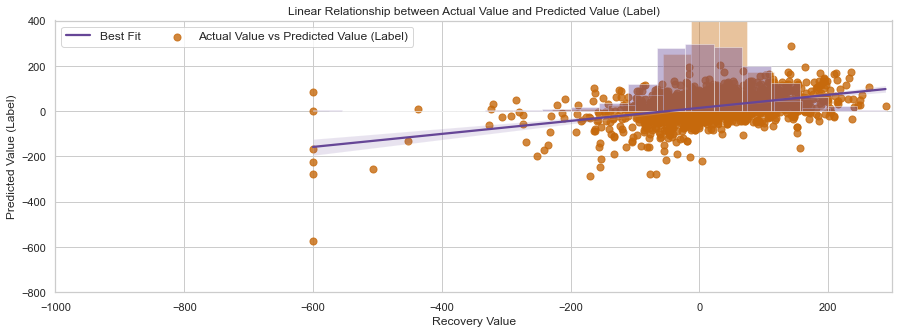

In [296]:
val_preds = modelCB.predict(test_X)
MAPE=np.mean(np.abs((test_y - val_preds) / test_y)) * 100
# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(val_preds, test_y))
print("Accuracy is : ",  100-MAPE)

def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None, 
                  title="Residual Plot", figsize=(9,6)):
    """ Residual plot to evaluate performance of our simple linear regressor """
    plt.figure(figsize=figsize)
    plt.scatter(train_preds, train_preds - train_labels, c='blue', alpha=0.1,
                marker='o', edgecolors='white', label='Training')
    
    if test_labels is not None:
        plt.scatter(test_preds, test_preds - test_labels, c='red', alpha=0.1,
                    marker='^', edgecolors='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    
    if test_labels is not None:
        plt.legend(loc='best')
    plt.title(title)
    plt.show()
    return

train_preds = modelCB.predict(train_X)

residual_plot(train_y, train_preds, 
              test_y, val_preds, 
              title="CatBoost Residual Plot")

import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_CATBOOST = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_CATBOOST["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_CATBOOST["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(( 'Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



# We can plot the Predicted Value (Label) and Actual Value over the entire dataset. 
sns.regplot(x="Real", y="Prediction", data=output_data_CATBOOST, lowess=False, scatter_kws ={'s':50}, line_kws={"color": "#664697"}, color="#c6690c")
plt.title("Linear Relationship between Actual Value and Predicted Value (Label)")
plt.ylabel("Predicted Value (Label)")
plt.xlabel("Recovery Value")
plt.xlim([-1000, 300])
plt.ylim([-800,400])
plt.legend(('Best Fit', 'Actual Value vs Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)

output_data_CATBOOST.head(50)
output_data_CATBOOST["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_CATBOOST["Prediction"]]
output_data_CATBOOST["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_CATBOOST["Real"]]

output_data_CATBOOST.head(50)
comparison_column = np.where(output_data_CATBOOST["Prediction_sign"] == output_data_CATBOOST["Real_sign"], True, False)

count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from catboost import cv
def cross_val(model):
    pred = cross_val_score(model, x, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square
#### Cat Boost
print('Test set evaluation:\n_____________________________________')
print_evaluate(test_y, val_preds)
print('Train set evaluation:\n_____________________________________')
print_evaluate(train_y, train_preds)


#### Light GBM 
results_bsic_Catboost = pd.DataFrame(data=[["Cat Boost", *evaluate(train_y, train_preds) ,cross_val(CatBoostRegressor())]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_bsic_Catboost




#feat_importances = modelCB.get_feature_importance(prettified=True)
#feat_importances
#plt.figure(figsize=(12, 10))
#sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:, :])
#plt.title('CatBoost features importance:')
#feat_importances.tail(100)
#feat_importances.loc[:, :]

In [297]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6524390243902439


$\textbf{We now add Uplift 2}$

* Λογαριασμός Προσαυξήσεων Ισχύος Εξισορρόπησης
* Χρησιμοποιείται για τον επιμερισμό του κόστους παροχής Ισχύος Εξισορρόπησης απο τους Παρόχους Υπηρεσιών Εξισορρόπησης
 $$Uplift = BALCAP_t \cdot \frac{MQ}{\sum MQ}$$

In [91]:
###### Add Uplift 2 to see if there is going to be any significant difference in the evaluation of our model
x = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[9],columns_data[14],columns_data[15],columns_data[16],columns_data[17]], axis=1)
x.head()

,Uplift Account 1 (€/MWh),Uplift Account 2 (€/MWh),RES,Load,Mandatory Hydro,Total FRR
2021-08-15 00:00:00,2.738548,0.662670,1820.0,5515.5,50.0,914.0
2021-08-15 01:00:00,2.375837,1.098814,1930.0,5299.0,50.0,939.0
2021-08-15 02:00:00,2.143069,1.201918,2000.0,5127.5,50.0,949.0
2021-08-15 03:00:00,2.043232,1.117085,2035.0,5038.0,63.0,939.0
2021-08-15 04:00:00,2.227400,1.156230,2055.0,4951.5,76.0,1079.0


In [92]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.25)

In [93]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = train_X.columns

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X)

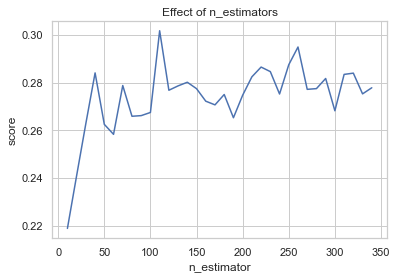

In [94]:
# Scale the data to be between -1 and 1
rf = RandomForestRegressor(n_jobs=-1)

# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 343, 10)
scores = []
for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(train_X, train_y)
    scores.append(rf.score(test_X, test_y))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [95]:
rf_score = cross_val_score(rf, x, y, cv=kfolds, scoring='neg_mean_squared_error')
rf_rmse =  np.sqrt(-rf_score.mean())
# Printing out Ridge Score and STD
print("Random Forest Model RMSE: ", rf_rmse)
print("Random Forest Model STD: ", rf_score.std())

Random Forest Model RMSE:  87.56460699353708
Random Forest Model STD:  541.6060295606619


In [96]:
preds_train=rf.predict(train_X)
preds1 = rf.predict(test_X)

Evaluation on test data
RMSE: 84.03
R2: 0.28
Adjusted R2: 0.28


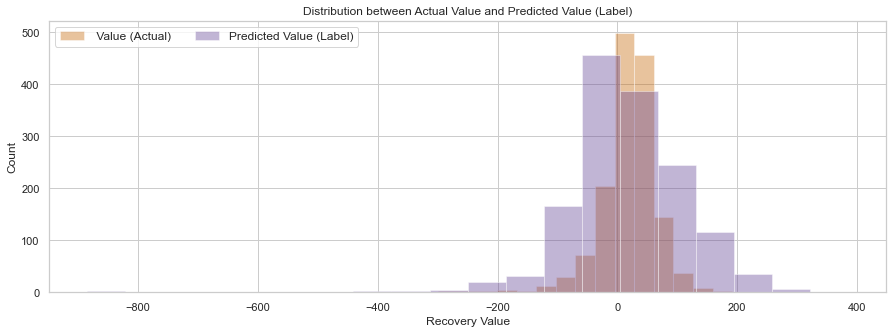

In [97]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_random_forest_with_uplift2 = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_random_forest_with_uplift2["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_random_forest_with_uplift2["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



In [98]:
output_data_random_forest.head(50)

output_data_random_forest["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Prediction"]]
output_data_random_forest["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Real"]]

In [99]:
output_data_random_forest.head(50)
comparison_column = np.where(output_data_random_forest["Prediction_sign"] == output_data_random_forest["Real_sign"], True, False)

In [100]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  983


In [102]:
print('Accuracy', count/len(comparison_column))

Accuracy 0.6659891598915989


$\textbf{Regression with a deep neural Network (DNN) Keras}$

In [180]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [181]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [182]:
dataset = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[7],columns_data[8],columns_data[9],columns_data[14],columns_data[16],columns_data[17]], axis=1)
dataset.head()



train_dataset = dataset.sample(frac=0.75, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [183]:
train_dataset.head()
test_dataset.head()
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RES,4428.0,1945.449036,1035.571408,260.00,1053.750000,1870.000000,2675.000000,5195.00000
Load,4428.0,5925.086871,1167.601717,220.00,5055.125000,5929.750000,6766.250000,9258.50000
Mandatory Hydro,4428.0,320.378952,432.948268,0.00,19.000000,106.000000,442.000000,1798.00000
Total FRR,4428.0,1396.218232,366.367226,0.00,1244.000000,1512.500000,1636.000000,2029.00000
Day_ahead_Balancing_diff,4428.0,16.768615,105.706552,-1015.24,-37.168252,15.202925,77.344871,362.62531


In [184]:
train_dataset.head()

,RES,Load,Mandatory Hydro,Total FRR,Day_ahead_Balancing_diff
2021-09-18 12:00:00,3490.0,6849.0,26.0,1574.0,-29.703505
2022-01-13 22:00:00,2435.0,6663.5,615.5,1846.0,-32.743655
2022-04-07 18:00:00,2460.0,6082.5,468.0,1746.0,-69.701767
2021-11-16 15:00:00,2140.0,6360.0,84.5,1729.0,13.535551
2021-09-03 08:00:00,3155.0,6798.5,320.0,1714.0,92.220675


In [185]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Day_ahead_Balancing_diff')
test_labels = test_features.pop('Day_ahead_Balancing_diff')

In [186]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [187]:
normalizer.adapt(np.array(train_features))

In [188]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 4)                9         
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                320       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [189]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 20.1 s


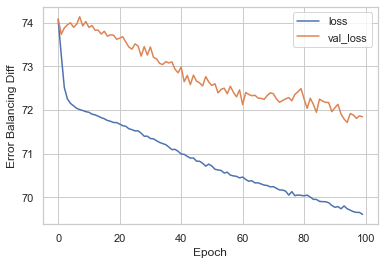

In [190]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')

  plt.xlabel('Epoch')
  plt.ylabel('Error Balancing Diff')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [191]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [192]:
test_results

{'dnn_model': 72.20266723632812}

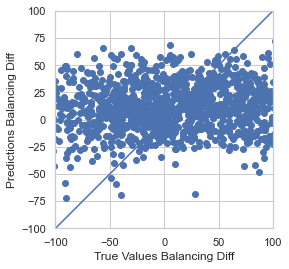

In [193]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values Balancing Diff')
plt.ylabel('Predictions Balancing Diff')
lims = [-100, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

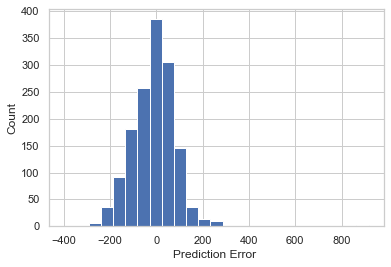

In [194]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error ')
_ = plt.ylabel('Count')

In [195]:
test_labels

2021-08-15 00:00:00     57.123433
2021-08-15 07:00:00     31.875812
2021-08-15 19:00:00     19.302691
2021-08-15 21:00:00     53.604033
2021-08-16 00:00:00     44.733231
                          ...    
2022-04-17 05:00:00    -11.875000
2022-04-17 07:00:00    105.435523
2022-04-17 08:00:00    -90.572857
2022-04-17 13:00:00   -173.203768
2022-04-17 21:00:00    -95.576083
Name: Day_ahead_Balancing_diff, Length: 1476, dtype: float64

In [196]:
test_predictions

array([ 17.798191  , -24.098473  , -10.896747  , ..., -35.622215  ,
        -3.7792625 ,  -0.48693445], dtype=float32)

Evaluation on test data
RMSE: 102.42
R2: 0.02
Adjusted R2: 0.02


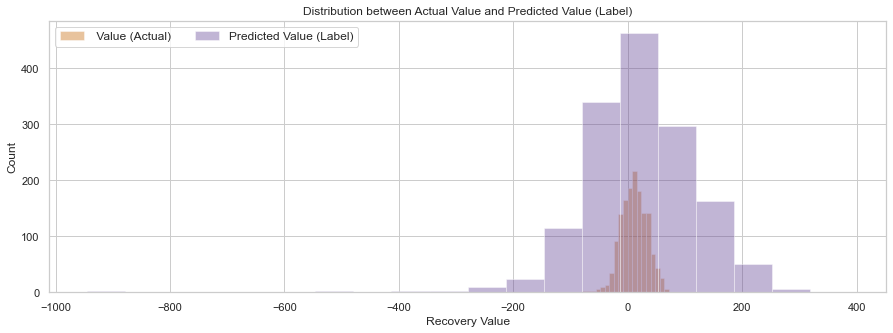

In [197]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_labels,test_predictions))
#R2 Score
r2_test = r2_score(test_labels,test_predictions)
# Adjusted R2 Score
n= train_features.shape[0] # total no of datapoints
p= train_features.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_keras = pd.DataFrame({
                      'Prediction': test_predictions,'Real': test_labels})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_keras["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_keras["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



In [198]:
output_keras.head(50)
output_keras["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_keras["Prediction"]]
output_keras["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_keras["Real"]]

comparison_column = np.where(output_keras["Prediction_sign"] == output_keras["Real_sign"], True, False)

count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

We have a total of True values :  853
Accuracy of True values compared to the total observations : 0.5779132791327913
